In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [4]:
def Act(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)
        Qlogits = tf.layers.dense(inputs=nl2, units=1, trainable=False)
        return states_logits, Qlogits

In [6]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    ################################################ a = act(s)
    actions_logits = Act(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ################################################ s', r = env(s, a)
    ################################################ s', Q = env(s, a)
    ################################################ ~s', ~Q = env(s, ~a)
    e_next_states_logits, eQs = Env(actions=actions_labels, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size)
    a_next_states_logits, aQs = Env(actions=actions_logits, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size, reuse=True)
    next_states_labels = tf.nn.sigmoid(next_states)
    eloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, 
                                                                   labels=next_states_labels)) # real loss
    eloss += -tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                     labels=next_states_labels)) # maximize loss
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                    labels=next_states_labels)) # minimize loss
    eQs_logits = tf.reshape(eQs, shape=[-1])
    aQs_logits = tf.reshape(aQs, shape=[-1])
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=eQs_logits, # GAN
                                                                    labels=rates)) # 0-1 real
    #################################################### s'', Q' = ~env(s', ~a')
    next_actions_logits = Act(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    _, aQs2 = Env(actions=next_actions_logits, states=next_states, hidden_size=hidden_size, 
                  action_size=action_size, state_size=state_size, reuse=True)
    aQs2_logits = tf.reshape(aQs2, shape=[-1]) * (1-dones)
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                    labels=tf.zeros_like(rates))) # min
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                     labels=tf.ones_like(rates))) # max
    ###################################################### Q(s,a)= r + Q'(s',a') # max
    ###################################################### ~Q(s,~a)= r # min
    ###################################################### ~Q(s,~a)= r + Q'(s',a') # max
    targetQs = rewards + (gamma * aQs2_logits)
    eloss += tf.reduce_mean(tf.square(eQs_logits - targetQs)) # real
    eloss += tf.reduce_mean((aQs_logits+aQs2_logits)/2) # min
    aloss2 += -tf.reduce_mean((aQs_logits+aQs2_logits)/2) # max
    return actions_logits, aloss, eloss, aloss2

In [7]:
def model_opt(a_loss, e_loss, a_loss2, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, e_opt, a_opt2

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        e_loss=self.e_loss,
                                                        a_loss2=self.a_loss2, 
                                                        a_learning_rate=a_learning_rate,
                                                        e_learning_rate=e_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
#         return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size
gamma=0.99

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, gamma=gamma,
              a_learning_rate=a_learning_rate, e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        state = env.reset()
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [14]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list, aloss2_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes for running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        aloss_batch, eloss_batch, aloss2_batch = [], [], []
        total_reward = 0
        state = env.reset()
        num_step = 0
        rate = -1

        # Training steps/batches
        while True:
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Training with the maxrated minibatch
            batch = memory.buffer
            #for idx in range(memory_size// batch_size):
            while True:
                idx = np.random.choice(np.arange(memory_size// batch_size))
                states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                states = states[rates >= np.max(rates)]
                actions = actions[rates >= np.max(rates)]
                next_states = next_states[rates >= np.max(rates)]
                rewards = rewards[rates >= np.max(rates)]
                dones = dones[rates >= np.max(rates)]
                rates = rates[rates >= np.max(rates)]
                if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
                    break
            aloss, _ = sess.run([model.a_loss, model.a_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            eloss, _ = sess.run([model.e_loss, model.e_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            aloss2, _= sess.run([model.a_loss2, model.a_opt2], 
                                 feed_dict = {model.states: states, 
                                              model.actions: actions,
                                              model.next_states: next_states,
                                              model.rewards: rewards,
                                              model.dones: dones,
                                              model.rates: rates})
            # print(len(dones), np.count_nonzero(dones), np.max(rates))
            aloss_batch.append(aloss)
            eloss_batch.append(eloss)
            aloss2_batch.append(aloss2)
            if done is True:
                break
                
        # Rating the latest played episode
        rate = total_reward/500 # update rate at the end/ when episode is done
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                memory.buffer[-1-idx][-1] = rate # rate the trajectory/data

        # Print out
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        aloss2_list.append([ep, np.mean(aloss2_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:16.0000 R:16.0000 rate:0.0320 aloss:0.6877 eloss:2.4513 aloss2:1.1830 exploreP:0.9984
Episode:1 meanR:22.0000 R:28.0000 rate:0.0560 aloss:0.7023 eloss:2.4812 aloss2:1.1846 exploreP:0.9957
Episode:2 meanR:29.6667 R:45.0000 rate:0.0900 aloss:0.6869 eloss:2.4934 aloss2:1.1599 exploreP:0.9912
Episode:3 meanR:26.5000 R:17.0000 rate:0.0340 aloss:0.7015 eloss:2.4394 aloss2:1.2059 exploreP:0.9896
Episode:4 meanR:25.6000 R:22.0000 rate:0.0440 aloss:0.6897 eloss:2.4280 aloss2:1.2039 exploreP:0.9874
Episode:5 meanR:23.6667 R:14.0000 rate:0.0280 aloss:0.6868 eloss:2.3457 aloss2:1.2545 exploreP:0.9860
Episode:6 meanR:23.0000 R:19.0000 rate:0.0380 aloss:0.6904 eloss:2.3671 aloss2:1.2325 exploreP:0.9842
Episode:7 meanR:24.6250 R:36.0000 rate:0.0720 aloss:0.6993 eloss:2.3256 aloss2:1.2648 exploreP:0.9807
Episode:8 meanR:23.5556 R:15.0000 rate:0.0300 aloss:0.6945 eloss:2.3227 aloss2:1.2631 exploreP:0.9792
Episode:9 meanR:24.9000 R:37.0000 rate:0.0740 aloss:0.6937 eloss:2.3171 aloss2:1.2

Episode:80 meanR:25.3086 R:20.0000 rate:0.0400 aloss:0.6767 eloss:1.8406 aloss2:1.6736 exploreP:0.8165
Episode:81 meanR:25.3293 R:27.0000 rate:0.0540 aloss:0.6805 eloss:1.8401 aloss2:1.6741 exploreP:0.8143
Episode:82 meanR:25.4819 R:38.0000 rate:0.0760 aloss:0.7074 eloss:1.8522 aloss2:1.6772 exploreP:0.8113
Episode:83 meanR:26.0714 R:75.0000 rate:0.1500 aloss:0.6794 eloss:1.8168 aloss2:1.6899 exploreP:0.8053
Episode:84 meanR:25.9647 R:17.0000 rate:0.0340 aloss:0.6883 eloss:1.8121 aloss2:1.6953 exploreP:0.8039
Episode:85 meanR:25.8953 R:20.0000 rate:0.0400 aloss:0.6840 eloss:1.8333 aloss2:1.6844 exploreP:0.8024
Episode:86 meanR:26.4253 R:72.0000 rate:0.1440 aloss:0.6812 eloss:1.8059 aloss2:1.6991 exploreP:0.7967
Episode:87 meanR:26.3409 R:19.0000 rate:0.0380 aloss:0.6840 eloss:1.8317 aloss2:1.6929 exploreP:0.7952
Episode:88 meanR:26.3708 R:29.0000 rate:0.0580 aloss:0.6819 eloss:1.8269 aloss2:1.6927 exploreP:0.7929
Episode:89 meanR:26.8889 R:73.0000 rate:0.1460 aloss:0.6762 eloss:1.8144 

Episode:159 meanR:40.8400 R:21.0000 rate:0.0420 aloss:0.6805 eloss:0.6348 aloss2:2.5874 exploreP:0.5771
Episode:160 meanR:40.3800 R:19.0000 rate:0.0380 aloss:0.6758 eloss:0.5762 aloss2:2.6339 exploreP:0.5761
Episode:161 meanR:40.7600 R:57.0000 rate:0.1140 aloss:0.6881 eloss:0.5266 aloss2:2.6500 exploreP:0.5728
Episode:162 meanR:40.9300 R:42.0000 rate:0.0840 aloss:0.6802 eloss:0.3519 aloss2:2.8075 exploreP:0.5705
Episode:163 meanR:41.1400 R:34.0000 rate:0.0680 aloss:0.6927 eloss:0.3232 aloss2:2.8143 exploreP:0.5686
Episode:164 meanR:41.1100 R:16.0000 rate:0.0320 aloss:0.6799 eloss:0.1953 aloss2:2.9354 exploreP:0.5677
Episode:165 meanR:41.1900 R:46.0000 rate:0.0920 aloss:0.6974 eloss:0.2218 aloss2:2.9003 exploreP:0.5651
Episode:166 meanR:41.1800 R:36.0000 rate:0.0720 aloss:0.6916 eloss:0.1117 aloss2:3.0033 exploreP:0.5631
Episode:167 meanR:41.1100 R:24.0000 rate:0.0480 aloss:0.6960 eloss:0.0898 aloss2:3.0139 exploreP:0.5618
Episode:168 meanR:40.9600 R:17.0000 rate:0.0340 aloss:0.7378 elo

Episode:238 meanR:32.1600 R:26.0000 rate:0.0520 aloss:0.6754 eloss:1.8473 aloss2:2.1274 exploreP:0.4605
Episode:239 meanR:32.1000 R:29.0000 rate:0.0580 aloss:0.6770 eloss:1.7984 aloss2:2.1629 exploreP:0.4592
Episode:240 meanR:32.5400 R:99.0000 rate:0.1980 aloss:0.6841 eloss:1.8357 aloss2:2.1454 exploreP:0.4547
Episode:241 meanR:33.6300 R:145.0000 rate:0.2900 aloss:0.6850 eloss:1.8662 aloss2:2.1204 exploreP:0.4483
Episode:242 meanR:33.5700 R:61.0000 rate:0.1220 aloss:0.6841 eloss:1.9192 aloss2:2.1029 exploreP:0.4457
Episode:243 meanR:33.0200 R:34.0000 rate:0.0680 aloss:0.6846 eloss:1.9105 aloss2:2.0898 exploreP:0.4442
Episode:244 meanR:33.4600 R:105.0000 rate:0.2100 aloss:0.6768 eloss:1.8937 aloss2:2.1085 exploreP:0.4397
Episode:245 meanR:34.9500 R:169.0000 rate:0.3380 aloss:0.6781 eloss:1.8977 aloss2:2.1051 exploreP:0.4325
Episode:246 meanR:35.7100 R:166.0000 rate:0.3320 aloss:0.6727 eloss:1.8490 aloss2:2.1159 exploreP:0.4255
Episode:247 meanR:37.5000 R:206.0000 rate:0.4120 aloss:0.673

Episode:316 meanR:104.4800 R:122.0000 rate:0.2440 aloss:0.6676 eloss:-2.7378 aloss2:12.5033 exploreP:0.1804
Episode:317 meanR:105.2000 R:99.0000 rate:0.1980 aloss:0.6669 eloss:-2.6158 aloss2:12.6865 exploreP:0.1787
Episode:318 meanR:106.5900 R:153.0000 rate:0.3060 aloss:0.6675 eloss:-2.9958 aloss2:13.0911 exploreP:0.1762
Episode:319 meanR:107.2000 R:79.0000 rate:0.1580 aloss:0.6683 eloss:-3.0338 aloss2:13.4484 exploreP:0.1748
Episode:320 meanR:108.2700 R:125.0000 rate:0.2500 aloss:0.6696 eloss:-2.7142 aloss2:13.6271 exploreP:0.1728
Episode:321 meanR:108.8400 R:84.0000 rate:0.1680 aloss:0.6758 eloss:-2.8100 aloss2:13.9342 exploreP:0.1714
Episode:322 meanR:109.8200 R:116.0000 rate:0.2320 aloss:0.6733 eloss:-3.1123 aloss2:14.2602 exploreP:0.1696
Episode:323 meanR:111.4100 R:173.0000 rate:0.3460 aloss:0.6636 eloss:-3.3253 aloss2:14.6500 exploreP:0.1668
Episode:324 meanR:113.3400 R:227.0000 rate:0.4540 aloss:0.6705 eloss:-3.3683 aloss2:15.1700 exploreP:0.1633
Episode:325 meanR:114.3600 R:11

Episode:393 meanR:146.0400 R:329.0000 rate:0.6580 aloss:0.6497 eloss:-6.8210 aloss2:39.4523 exploreP:0.0653
Episode:394 meanR:145.6200 R:114.0000 rate:0.2280 aloss:0.6680 eloss:-6.5527 aloss2:39.4245 exploreP:0.0647
Episode:395 meanR:146.3600 R:172.0000 rate:0.3440 aloss:0.6617 eloss:-6.7914 aloss2:39.8721 exploreP:0.0637
Episode:396 meanR:147.0400 R:250.0000 rate:0.5000 aloss:0.6612 eloss:-6.8239 aloss2:40.0760 exploreP:0.0624
Episode:397 meanR:147.2800 R:119.0000 rate:0.2380 aloss:0.6449 eloss:-7.0175 aloss2:40.3404 exploreP:0.0618
Episode:398 meanR:147.3200 R:131.0000 rate:0.2620 aloss:0.6558 eloss:-7.2248 aloss2:40.6534 exploreP:0.0611
Episode:399 meanR:147.1200 R:312.0000 rate:0.6240 aloss:0.6546 eloss:-7.6939 aloss2:40.9245 exploreP:0.0595
Episode:400 meanR:146.1800 R:82.0000 rate:0.1640 aloss:0.6515 eloss:-7.2678 aloss2:41.3347 exploreP:0.0591
Episode:401 meanR:145.2700 R:122.0000 rate:0.2440 aloss:0.6652 eloss:-5.7279 aloss2:41.3176 exploreP:0.0585
Episode:402 meanR:147.1300 R:

Episode:469 meanR:168.8500 R:101.0000 rate:0.2020 aloss:0.6204 eloss:-4.6470 aloss2:48.5234 exploreP:0.0253
Episode:470 meanR:168.3000 R:104.0000 rate:0.2080 aloss:0.6428 eloss:-7.0804 aloss2:48.6676 exploreP:0.0252
Episode:471 meanR:167.0900 R:103.0000 rate:0.2060 aloss:0.6244 eloss:-5.3425 aloss2:48.6519 exploreP:0.0250
Episode:472 meanR:166.4200 R:103.0000 rate:0.2060 aloss:0.6441 eloss:-5.5320 aloss2:48.5517 exploreP:0.0248
Episode:473 meanR:168.9600 R:356.0000 rate:0.7120 aloss:0.6344 eloss:-5.3742 aloss2:48.9452 exploreP:0.0243
Episode:474 meanR:169.2500 R:135.0000 rate:0.2700 aloss:0.6288 eloss:-4.6251 aloss2:48.8635 exploreP:0.0241
Episode:475 meanR:169.9300 R:149.0000 rate:0.2980 aloss:0.6311 eloss:-7.0752 aloss2:48.7379 exploreP:0.0239
Episode:476 meanR:171.5400 R:357.0000 rate:0.7140 aloss:0.6292 eloss:-6.4261 aloss2:48.7239 exploreP:0.0234
Episode:477 meanR:170.5100 R:102.0000 rate:0.2040 aloss:0.6185 eloss:-6.8595 aloss2:48.8949 exploreP:0.0233
Episode:478 meanR:170.9100 R

Episode:546 meanR:204.3100 R:245.0000 rate:0.4900 aloss:0.6010 eloss:-3.9868 aloss2:52.5316 exploreP:0.0129
Episode:547 meanR:206.6200 R:343.0000 rate:0.6860 aloss:0.6044 eloss:-4.0480 aloss2:52.4036 exploreP:0.0128
Episode:548 meanR:209.2200 R:491.0000 rate:0.9820 aloss:0.5975 eloss:-4.2966 aloss2:52.2356 exploreP:0.0127
Episode:549 meanR:210.5400 R:313.0000 rate:0.6260 aloss:0.5884 eloss:-5.1827 aloss2:52.1038 exploreP:0.0126
Episode:550 meanR:210.2100 R:82.0000 rate:0.1640 aloss:0.5853 eloss:-3.6978 aloss2:52.7775 exploreP:0.0126
Episode:551 meanR:209.8600 R:251.0000 rate:0.5020 aloss:0.5916 eloss:-1.9100 aloss2:52.1371 exploreP:0.0125
Episode:552 meanR:207.1400 R:96.0000 rate:0.1920 aloss:0.5828 eloss:-5.1796 aloss2:51.6730 exploreP:0.0125
Episode:553 meanR:204.7400 R:82.0000 rate:0.1640 aloss:0.6142 eloss:-5.0751 aloss2:52.1749 exploreP:0.0125
Episode:554 meanR:205.0200 R:190.0000 rate:0.3800 aloss:0.6055 eloss:-2.9179 aloss2:51.7509 exploreP:0.0124
Episode:555 meanR:205.6500 R:13

Episode:623 meanR:185.8400 R:500.0000 rate:1.0000 aloss:0.5911 eloss:-4.0665 aloss2:48.2686 exploreP:0.0108
Episode:624 meanR:186.1000 R:404.0000 rate:0.8080 aloss:0.5853 eloss:-3.0626 aloss2:48.0551 exploreP:0.0108
Episode:625 meanR:185.3300 R:286.0000 rate:0.5720 aloss:0.5901 eloss:-4.5958 aloss2:47.8558 exploreP:0.0107
Episode:626 meanR:188.0700 R:500.0000 rate:1.0000 aloss:0.5908 eloss:-3.9087 aloss2:47.9444 exploreP:0.0107
Episode:627 meanR:192.2100 R:500.0000 rate:1.0000 aloss:0.5907 eloss:-5.2571 aloss2:47.9401 exploreP:0.0107
Episode:628 meanR:194.4300 R:500.0000 rate:1.0000 aloss:0.5719 eloss:-2.9963 aloss2:47.7138 exploreP:0.0106
Episode:629 meanR:194.5700 R:346.0000 rate:0.6920 aloss:0.5710 eloss:-3.6508 aloss2:47.6349 exploreP:0.0106
Episode:630 meanR:198.5500 R:500.0000 rate:1.0000 aloss:0.5658 eloss:-3.3037 aloss2:47.5196 exploreP:0.0106
Episode:631 meanR:198.5300 R:95.0000 rate:0.1900 aloss:0.5701 eloss:-5.0214 aloss2:47.5135 exploreP:0.0106
Episode:632 meanR:200.9900 R:

Episode:700 meanR:240.6600 R:279.0000 rate:0.5580 aloss:0.4690 eloss:-3.3553 aloss2:44.6974 exploreP:0.0101
Episode:701 meanR:240.4000 R:89.0000 rate:0.1780 aloss:0.4433 eloss:-2.8872 aloss2:44.6793 exploreP:0.0101
Episode:702 meanR:241.7000 R:229.0000 rate:0.4580 aloss:0.4866 eloss:-2.4138 aloss2:44.6994 exploreP:0.0101
Episode:703 meanR:237.4700 R:77.0000 rate:0.1540 aloss:0.4598 eloss:-0.3206 aloss2:44.5385 exploreP:0.0101
Episode:704 meanR:239.0500 R:239.0000 rate:0.4780 aloss:0.4693 eloss:-2.2556 aloss2:44.4063 exploreP:0.0101
Episode:705 meanR:239.2900 R:95.0000 rate:0.1900 aloss:0.4333 eloss:-0.1649 aloss2:44.3981 exploreP:0.0101
Episode:706 meanR:239.5300 R:103.0000 rate:0.2060 aloss:0.4605 eloss:-2.6117 aloss2:44.3980 exploreP:0.0101
Episode:707 meanR:239.1500 R:86.0000 rate:0.1720 aloss:0.4345 eloss:-2.8616 aloss2:44.5824 exploreP:0.0101
Episode:708 meanR:239.8500 R:155.0000 rate:0.3100 aloss:0.4410 eloss:-2.4241 aloss2:44.5531 exploreP:0.0101
Episode:709 meanR:242.5400 R:386

Episode:777 meanR:219.1100 R:272.0000 rate:0.5440 aloss:0.2840 eloss:-1.5125 aloss2:40.8541 exploreP:0.0100
Episode:778 meanR:215.8900 R:178.0000 rate:0.3560 aloss:0.2789 eloss:1.2097 aloss2:40.7400 exploreP:0.0100
Episode:779 meanR:215.9400 R:92.0000 rate:0.1840 aloss:0.2966 eloss:0.3711 aloss2:40.8244 exploreP:0.0100
Episode:780 meanR:216.9100 R:409.0000 rate:0.8180 aloss:0.3011 eloss:-0.5337 aloss2:40.6577 exploreP:0.0100
Episode:781 meanR:217.1500 R:112.0000 rate:0.2240 aloss:0.2905 eloss:-1.4161 aloss2:40.6204 exploreP:0.0100
Episode:782 meanR:217.5200 R:132.0000 rate:0.2640 aloss:0.2790 eloss:-1.2178 aloss2:40.4885 exploreP:0.0100
Episode:783 meanR:217.7000 R:293.0000 rate:0.5860 aloss:0.2776 eloss:-0.5778 aloss2:40.7041 exploreP:0.0100
Episode:784 meanR:218.0000 R:116.0000 rate:0.2320 aloss:0.3328 eloss:-0.6221 aloss2:40.4094 exploreP:0.0100
Episode:785 meanR:218.1200 R:98.0000 rate:0.1960 aloss:0.2935 eloss:1.0424 aloss2:40.4518 exploreP:0.0100
Episode:786 meanR:220.2300 R:310.

Episode:854 meanR:230.1200 R:359.0000 rate:0.7180 aloss:0.2356 eloss:0.7243 aloss2:32.3965 exploreP:0.0100
Episode:855 meanR:231.6000 R:242.0000 rate:0.4840 aloss:0.2298 eloss:0.3820 aloss2:32.3768 exploreP:0.0100
Episode:856 meanR:230.6800 R:86.0000 rate:0.1720 aloss:0.2237 eloss:0.3869 aloss2:32.3082 exploreP:0.0100
Episode:857 meanR:233.0400 R:500.0000 rate:1.0000 aloss:0.2324 eloss:0.7124 aloss2:32.1081 exploreP:0.0100
Episode:858 meanR:237.0300 R:500.0000 rate:1.0000 aloss:0.2332 eloss:0.5159 aloss2:31.8072 exploreP:0.0100
Episode:859 meanR:232.8500 R:82.0000 rate:0.1640 aloss:0.2332 eloss:0.8248 aloss2:31.6906 exploreP:0.0100
Episode:860 meanR:231.6800 R:64.0000 rate:0.1280 aloss:0.2256 eloss:0.2922 aloss2:31.7507 exploreP:0.0100
Episode:861 meanR:233.3900 R:281.0000 rate:0.5620 aloss:0.2347 eloss:1.0587 aloss2:31.4936 exploreP:0.0100
Episode:862 meanR:234.6500 R:204.0000 rate:0.4080 aloss:0.2396 eloss:0.6690 aloss2:31.3609 exploreP:0.0100
Episode:863 meanR:234.5200 R:70.0000 rat

Episode:931 meanR:246.7200 R:107.0000 rate:0.2140 aloss:0.2157 eloss:1.0312 aloss2:22.7338 exploreP:0.0100
Episode:932 meanR:246.7200 R:500.0000 rate:1.0000 aloss:0.2162 eloss:1.0046 aloss2:22.6289 exploreP:0.0100
Episode:933 meanR:243.1000 R:74.0000 rate:0.1480 aloss:0.2282 eloss:0.8682 aloss2:22.4315 exploreP:0.0100
Episode:934 meanR:242.7900 R:81.0000 rate:0.1620 aloss:0.2283 eloss:0.5953 aloss2:22.3713 exploreP:0.0100
Episode:935 meanR:242.9400 R:114.0000 rate:0.2280 aloss:0.2262 eloss:1.0540 aloss2:22.2650 exploreP:0.0100
Episode:936 meanR:244.4400 R:252.0000 rate:0.5040 aloss:0.2163 eloss:0.9841 aloss2:22.1737 exploreP:0.0100
Episode:937 meanR:248.2000 R:482.0000 rate:0.9640 aloss:0.2229 eloss:1.1021 aloss2:22.0119 exploreP:0.0100
Episode:938 meanR:247.5100 R:102.0000 rate:0.2040 aloss:0.2219 eloss:0.9976 aloss2:21.7971 exploreP:0.0100
Episode:939 meanR:245.3300 R:68.0000 rate:0.1360 aloss:0.2248 eloss:1.0304 aloss2:21.6600 exploreP:0.0100
Episode:940 meanR:242.6100 R:143.0000 ra

Episode:1008 meanR:211.3600 R:262.0000 rate:0.5240 aloss:0.2341 eloss:0.8984 aloss2:15.3925 exploreP:0.0100
Episode:1009 meanR:211.3000 R:70.0000 rate:0.1400 aloss:0.2308 eloss:0.9131 aloss2:15.4110 exploreP:0.0100
Episode:1010 meanR:214.2600 R:370.0000 rate:0.7400 aloss:0.2411 eloss:0.9358 aloss2:15.3288 exploreP:0.0100
Episode:1011 meanR:215.3200 R:188.0000 rate:0.3760 aloss:0.2289 eloss:0.9382 aloss2:15.2669 exploreP:0.0100
Episode:1012 meanR:215.0400 R:81.0000 rate:0.1620 aloss:0.2372 eloss:0.9360 aloss2:15.1845 exploreP:0.0100
Episode:1013 meanR:214.5900 R:93.0000 rate:0.1860 aloss:0.2373 eloss:0.8846 aloss2:15.1705 exploreP:0.0100
Episode:1014 meanR:218.8400 R:500.0000 rate:1.0000 aloss:0.2379 eloss:1.1008 aloss2:15.0536 exploreP:0.0100
Episode:1015 meanR:219.0600 R:115.0000 rate:0.2300 aloss:0.2356 eloss:0.8226 aloss2:14.9708 exploreP:0.0100
Episode:1016 meanR:220.8300 R:251.0000 rate:0.5020 aloss:0.2367 eloss:0.8822 aloss2:14.9234 exploreP:0.0100
Episode:1017 meanR:220.9200 R:2

Episode:1085 meanR:197.0300 R:87.0000 rate:0.1740 aloss:0.2406 eloss:0.8167 aloss2:12.2480 exploreP:0.0100
Episode:1086 meanR:196.9700 R:64.0000 rate:0.1280 aloss:0.2523 eloss:0.9083 aloss2:12.2386 exploreP:0.0100
Episode:1087 meanR:197.9900 R:180.0000 rate:0.3600 aloss:0.2389 eloss:0.9436 aloss2:12.2173 exploreP:0.0100
Episode:1088 meanR:196.3500 R:82.0000 rate:0.1640 aloss:0.2430 eloss:1.2469 aloss2:12.1453 exploreP:0.0100
Episode:1089 meanR:192.4300 R:108.0000 rate:0.2160 aloss:0.2492 eloss:1.1932 aloss2:12.1424 exploreP:0.0100
Episode:1090 meanR:196.0100 R:432.0000 rate:0.8640 aloss:0.2505 eloss:0.8318 aloss2:12.1530 exploreP:0.0100
Episode:1091 meanR:191.7800 R:77.0000 rate:0.1540 aloss:0.2435 eloss:0.9629 aloss2:12.0429 exploreP:0.0100
Episode:1092 meanR:190.0400 R:133.0000 rate:0.2660 aloss:0.2528 eloss:0.8050 aloss2:12.0564 exploreP:0.0100
Episode:1093 meanR:192.4100 R:336.0000 rate:0.6720 aloss:0.2546 eloss:0.7740 aloss2:12.0883 exploreP:0.0100
Episode:1094 meanR:190.4800 R:23

Episode:1162 meanR:166.8300 R:95.0000 rate:0.1900 aloss:0.3057 eloss:0.4857 aloss2:12.8466 exploreP:0.0100
Episode:1163 meanR:166.3200 R:67.0000 rate:0.1340 aloss:0.3064 eloss:0.4705 aloss2:12.8545 exploreP:0.0100
Episode:1164 meanR:163.1400 R:65.0000 rate:0.1300 aloss:0.2967 eloss:0.3548 aloss2:12.7880 exploreP:0.0100
Episode:1165 meanR:163.5900 R:140.0000 rate:0.2800 aloss:0.2974 eloss:0.5502 aloss2:12.8313 exploreP:0.0100
Episode:1166 meanR:161.9500 R:87.0000 rate:0.1740 aloss:0.2975 eloss:0.5391 aloss2:12.7680 exploreP:0.0100
Episode:1167 meanR:162.0500 R:78.0000 rate:0.1560 aloss:0.3005 eloss:0.5606 aloss2:12.8545 exploreP:0.0100
Episode:1168 meanR:157.9900 R:94.0000 rate:0.1880 aloss:0.3052 eloss:0.4608 aloss2:12.8837 exploreP:0.0100
Episode:1169 meanR:154.0100 R:102.0000 rate:0.2040 aloss:0.3090 eloss:0.5181 aloss2:12.9452 exploreP:0.0100
Episode:1170 meanR:153.6900 R:88.0000 rate:0.1760 aloss:0.3019 eloss:0.4961 aloss2:12.8820 exploreP:0.0100
Episode:1171 meanR:152.7900 R:117.0

Episode:1239 meanR:110.9000 R:141.0000 rate:0.2820 aloss:0.2349 eloss:0.1064 aloss2:15.4928 exploreP:0.0100
Episode:1240 meanR:110.5700 R:153.0000 rate:0.3060 aloss:0.2334 eloss:0.4331 aloss2:15.4932 exploreP:0.0100
Episode:1241 meanR:111.0800 R:173.0000 rate:0.3460 aloss:0.2365 eloss:0.1548 aloss2:15.5310 exploreP:0.0100
Episode:1242 meanR:110.7600 R:80.0000 rate:0.1600 aloss:0.2284 eloss:0.2197 aloss2:15.7028 exploreP:0.0100
Episode:1243 meanR:110.5500 R:83.0000 rate:0.1660 aloss:0.2277 eloss:0.4888 aloss2:15.5498 exploreP:0.0100
Episode:1244 meanR:110.1000 R:80.0000 rate:0.1600 aloss:0.2322 eloss:0.1852 aloss2:15.6948 exploreP:0.0100
Episode:1245 meanR:110.2100 R:86.0000 rate:0.1720 aloss:0.2451 eloss:0.0756 aloss2:15.8979 exploreP:0.0100
Episode:1246 meanR:109.8200 R:83.0000 rate:0.1660 aloss:0.2453 eloss:0.5374 aloss2:15.7577 exploreP:0.0100
Episode:1247 meanR:110.8100 R:203.0000 rate:0.4060 aloss:0.2355 eloss:0.1906 aloss2:15.8237 exploreP:0.0100
Episode:1248 meanR:111.4900 R:188

Episode:1315 meanR:128.2900 R:120.0000 rate:0.2400 aloss:0.2694 eloss:-0.1862 aloss2:20.0926 exploreP:0.0100
Episode:1316 meanR:127.4700 R:77.0000 rate:0.1540 aloss:0.2860 eloss:-0.5269 aloss2:20.2493 exploreP:0.0100
Episode:1317 meanR:127.5000 R:108.0000 rate:0.2160 aloss:0.2854 eloss:-0.1563 aloss2:20.2208 exploreP:0.0100
Episode:1318 meanR:127.8100 R:122.0000 rate:0.2440 aloss:0.2794 eloss:-0.6671 aloss2:20.3998 exploreP:0.0100
Episode:1319 meanR:127.5900 R:113.0000 rate:0.2260 aloss:0.2755 eloss:0.1947 aloss2:20.4107 exploreP:0.0100
Episode:1320 meanR:127.7900 R:164.0000 rate:0.3280 aloss:0.2790 eloss:0.5245 aloss2:20.5290 exploreP:0.0100
Episode:1321 meanR:128.1000 R:132.0000 rate:0.2640 aloss:0.2788 eloss:-0.1460 aloss2:20.6997 exploreP:0.0100
Episode:1322 meanR:128.4500 R:160.0000 rate:0.3200 aloss:0.2767 eloss:-0.3282 aloss2:20.7182 exploreP:0.0100
Episode:1323 meanR:129.3400 R:184.0000 rate:0.3680 aloss:0.2719 eloss:0.3365 aloss2:20.7588 exploreP:0.0100
Episode:1324 meanR:128.

Episode:1391 meanR:125.1800 R:88.0000 rate:0.1760 aloss:0.2749 eloss:-1.2494 aloss2:26.1252 exploreP:0.0100
Episode:1392 meanR:125.4200 R:159.0000 rate:0.3180 aloss:0.2712 eloss:-1.5067 aloss2:26.2481 exploreP:0.0100
Episode:1393 meanR:125.0300 R:72.0000 rate:0.1440 aloss:0.2834 eloss:-0.5675 aloss2:26.5466 exploreP:0.0100
Episode:1394 meanR:124.9600 R:148.0000 rate:0.2960 aloss:0.2709 eloss:-1.4771 aloss2:26.2954 exploreP:0.0100
Episode:1395 meanR:124.4800 R:72.0000 rate:0.1440 aloss:0.2746 eloss:-1.6240 aloss2:26.4771 exploreP:0.0100
Episode:1396 meanR:123.7500 R:110.0000 rate:0.2200 aloss:0.2680 eloss:-1.1585 aloss2:26.6051 exploreP:0.0100
Episode:1397 meanR:125.9200 R:285.0000 rate:0.5700 aloss:0.2802 eloss:-1.3224 aloss2:26.5114 exploreP:0.0100
Episode:1398 meanR:126.3800 R:151.0000 rate:0.3020 aloss:0.2855 eloss:-0.8527 aloss2:26.5573 exploreP:0.0100
Episode:1399 meanR:126.2900 R:87.0000 rate:0.1740 aloss:0.2694 eloss:-2.0713 aloss2:26.6649 exploreP:0.0100
Episode:1400 meanR:125.

Episode:1467 meanR:111.7000 R:165.0000 rate:0.3300 aloss:0.2749 eloss:-2.0416 aloss2:30.1967 exploreP:0.0100
Episode:1468 meanR:111.0400 R:85.0000 rate:0.1700 aloss:0.2711 eloss:-1.6744 aloss2:30.2931 exploreP:0.0100
Episode:1469 meanR:108.8800 R:111.0000 rate:0.2220 aloss:0.2620 eloss:-0.9418 aloss2:30.2350 exploreP:0.0100
Episode:1470 meanR:107.9100 R:111.0000 rate:0.2220 aloss:0.2721 eloss:-2.4039 aloss2:30.3226 exploreP:0.0100
Episode:1471 meanR:107.9800 R:106.0000 rate:0.2120 aloss:0.2709 eloss:-1.2190 aloss2:30.4221 exploreP:0.0100
Episode:1472 meanR:108.4100 R:203.0000 rate:0.4060 aloss:0.2732 eloss:-1.0211 aloss2:30.4186 exploreP:0.0100
Episode:1473 meanR:109.6200 R:209.0000 rate:0.4180 aloss:0.2642 eloss:-2.1446 aloss2:30.3544 exploreP:0.0100
Episode:1474 meanR:109.8000 R:129.0000 rate:0.2580 aloss:0.2639 eloss:-2.5441 aloss2:30.5330 exploreP:0.0100
Episode:1475 meanR:109.5500 R:81.0000 rate:0.1620 aloss:0.2632 eloss:-1.4228 aloss2:30.5761 exploreP:0.0100
Episode:1476 meanR:10

Episode:1543 meanR:108.6300 R:123.0000 rate:0.2460 aloss:0.2875 eloss:-2.8055 aloss2:34.1102 exploreP:0.0100
Episode:1544 meanR:109.2000 R:122.0000 rate:0.2440 aloss:0.2901 eloss:-3.0573 aloss2:34.2227 exploreP:0.0100
Episode:1545 meanR:109.3800 R:134.0000 rate:0.2680 aloss:0.2913 eloss:-2.9129 aloss2:34.3095 exploreP:0.0100
Episode:1546 meanR:109.4900 R:114.0000 rate:0.2280 aloss:0.2976 eloss:-2.9536 aloss2:34.4195 exploreP:0.0100
Episode:1547 meanR:108.9400 R:35.0000 rate:0.0700 aloss:0.2915 eloss:-2.8171 aloss2:34.5351 exploreP:0.0100
Episode:1548 meanR:108.9100 R:80.0000 rate:0.1600 aloss:0.2929 eloss:-2.9116 aloss2:34.6092 exploreP:0.0100
Episode:1549 meanR:107.2200 R:83.0000 rate:0.1660 aloss:0.2975 eloss:-2.7793 aloss2:34.7310 exploreP:0.0100
Episode:1550 meanR:107.5900 R:124.0000 rate:0.2480 aloss:0.2958 eloss:-3.1661 aloss2:34.8675 exploreP:0.0100
Episode:1551 meanR:107.8700 R:121.0000 rate:0.2420 aloss:0.2989 eloss:-2.2946 aloss2:34.8981 exploreP:0.0100
Episode:1552 meanR:107

Episode:1619 meanR:100.4900 R:164.0000 rate:0.3280 aloss:0.3391 eloss:-3.1384 aloss2:39.0488 exploreP:0.0100
Episode:1620 meanR:99.7600 R:29.0000 rate:0.0580 aloss:0.3363 eloss:-2.2541 aloss2:38.8938 exploreP:0.0100
Episode:1621 meanR:99.9800 R:112.0000 rate:0.2240 aloss:0.3384 eloss:-4.6434 aloss2:39.1849 exploreP:0.0100
Episode:1622 meanR:100.3300 R:107.0000 rate:0.2140 aloss:0.3381 eloss:-2.2570 aloss2:39.1365 exploreP:0.0100
Episode:1623 meanR:100.3700 R:99.0000 rate:0.1980 aloss:0.3405 eloss:-3.8484 aloss2:39.3378 exploreP:0.0100
Episode:1624 meanR:100.1400 R:62.0000 rate:0.1240 aloss:0.3436 eloss:-1.6046 aloss2:39.2219 exploreP:0.0100
Episode:1625 meanR:100.0600 R:88.0000 rate:0.1760 aloss:0.3364 eloss:-3.5896 aloss2:39.2477 exploreP:0.0100
Episode:1626 meanR:99.6500 R:111.0000 rate:0.2220 aloss:0.3302 eloss:-1.8779 aloss2:39.1897 exploreP:0.0100
Episode:1627 meanR:99.7900 R:82.0000 rate:0.1640 aloss:0.3426 eloss:-1.7686 aloss2:39.3794 exploreP:0.0100
Episode:1628 meanR:99.7800 R

Episode:1696 meanR:93.6600 R:95.0000 rate:0.1900 aloss:0.3403 eloss:-5.5798 aloss2:43.4152 exploreP:0.0100
Episode:1697 meanR:93.5200 R:72.0000 rate:0.1440 aloss:0.3405 eloss:-5.1986 aloss2:43.4165 exploreP:0.0100
Episode:1698 meanR:93.6200 R:112.0000 rate:0.2240 aloss:0.3371 eloss:-4.0470 aloss2:43.1411 exploreP:0.0100
Episode:1699 meanR:94.2200 R:104.0000 rate:0.2080 aloss:0.3391 eloss:-5.3588 aloss2:43.6970 exploreP:0.0100
Episode:1700 meanR:94.4400 R:112.0000 rate:0.2240 aloss:0.3402 eloss:-5.6918 aloss2:43.8425 exploreP:0.0100
Episode:1701 meanR:94.0400 R:52.0000 rate:0.1040 aloss:0.3353 eloss:-5.1921 aloss2:43.6629 exploreP:0.0100
Episode:1702 meanR:93.6400 R:53.0000 rate:0.1060 aloss:0.3742 eloss:-3.4904 aloss2:43.8291 exploreP:0.0100
Episode:1703 meanR:93.0600 R:114.0000 rate:0.2280 aloss:0.3433 eloss:-4.2080 aloss2:43.9459 exploreP:0.0100
Episode:1704 meanR:92.3800 R:90.0000 rate:0.1800 aloss:0.3347 eloss:-6.2423 aloss2:43.9507 exploreP:0.0100
Episode:1705 meanR:93.1700 R:99.0

Episode:1773 meanR:97.6000 R:33.0000 rate:0.0660 aloss:0.3087 eloss:-7.3034 aloss2:48.1918 exploreP:0.0100
Episode:1774 meanR:97.5500 R:72.0000 rate:0.1440 aloss:0.3481 eloss:1.6250 aloss2:48.2237 exploreP:0.0100
Episode:1775 meanR:98.0900 R:141.0000 rate:0.2820 aloss:0.3451 eloss:0.6579 aloss2:48.1271 exploreP:0.0100
Episode:1776 meanR:97.4400 R:62.0000 rate:0.1240 aloss:0.3166 eloss:-5.5176 aloss2:48.5058 exploreP:0.0100
Episode:1777 meanR:96.9000 R:68.0000 rate:0.1360 aloss:0.3147 eloss:-7.5117 aloss2:48.3299 exploreP:0.0100
Episode:1778 meanR:96.9900 R:61.0000 rate:0.1220 aloss:0.3174 eloss:-5.4780 aloss2:48.4816 exploreP:0.0100
Episode:1779 meanR:96.0900 R:100.0000 rate:0.2000 aloss:0.3194 eloss:-6.2874 aloss2:48.2484 exploreP:0.0100
Episode:1780 meanR:95.9200 R:68.0000 rate:0.1360 aloss:0.3169 eloss:-6.3463 aloss2:48.5369 exploreP:0.0100
Episode:1781 meanR:96.1500 R:134.0000 rate:0.2680 aloss:0.3198 eloss:-5.5685 aloss2:48.3637 exploreP:0.0100
Episode:1782 meanR:96.2000 R:79.0000

Episode:1849 meanR:102.6700 R:42.0000 rate:0.0840 aloss:0.2849 eloss:-9.1908 aloss2:51.7431 exploreP:0.0100
Episode:1850 meanR:103.3500 R:148.0000 rate:0.2960 aloss:0.2861 eloss:-8.5660 aloss2:51.5670 exploreP:0.0100
Episode:1851 meanR:103.9700 R:92.0000 rate:0.1840 aloss:0.2865 eloss:0.5615 aloss2:51.0090 exploreP:0.0100
Episode:1852 meanR:104.4800 R:94.0000 rate:0.1880 aloss:0.2864 eloss:-6.5890 aloss2:51.4728 exploreP:0.0100
Episode:1853 meanR:103.9700 R:67.0000 rate:0.1340 aloss:0.2795 eloss:-8.1835 aloss2:51.6991 exploreP:0.0100
Episode:1854 meanR:104.5500 R:105.0000 rate:0.2100 aloss:0.2902 eloss:-6.2198 aloss2:51.7093 exploreP:0.0100
Episode:1855 meanR:104.7300 R:106.0000 rate:0.2120 aloss:0.3051 eloss:1.0878 aloss2:51.3643 exploreP:0.0100
Episode:1856 meanR:104.1900 R:74.0000 rate:0.1480 aloss:0.3493 eloss:2.3300 aloss2:51.1611 exploreP:0.0100
Episode:1857 meanR:103.4000 R:59.0000 rate:0.1180 aloss:0.2984 eloss:-5.6973 aloss2:51.2464 exploreP:0.0100
Episode:1858 meanR:103.4800 

Episode:1926 meanR:82.7400 R:65.0000 rate:0.1300 aloss:0.2773 eloss:-9.7840 aloss2:54.5938 exploreP:0.0100
Episode:1927 meanR:82.3200 R:109.0000 rate:0.2180 aloss:0.2785 eloss:-7.4285 aloss2:54.0818 exploreP:0.0100
Episode:1928 meanR:82.3300 R:94.0000 rate:0.1880 aloss:0.3066 eloss:-5.0126 aloss2:54.4971 exploreP:0.0100
Episode:1929 meanR:82.4500 R:89.0000 rate:0.1780 aloss:0.3125 eloss:-2.7587 aloss2:53.9711 exploreP:0.0100
Episode:1930 meanR:82.5600 R:93.0000 rate:0.1860 aloss:0.2904 eloss:-7.8053 aloss2:54.7430 exploreP:0.0100
Episode:1931 meanR:82.5800 R:72.0000 rate:0.1440 aloss:0.2887 eloss:-6.2214 aloss2:54.2195 exploreP:0.0100
Episode:1932 meanR:82.2100 R:77.0000 rate:0.1540 aloss:0.2752 eloss:-8.2161 aloss2:54.1220 exploreP:0.0100
Episode:1933 meanR:81.9400 R:59.0000 rate:0.1180 aloss:0.2780 eloss:-2.4381 aloss2:53.5780 exploreP:0.0100
Episode:1934 meanR:81.4500 R:51.0000 rate:0.1020 aloss:0.2797 eloss:-9.7601 aloss2:54.5492 exploreP:0.0100
Episode:1935 meanR:81.6300 R:76.0000

Episode:2003 meanR:87.7200 R:71.0000 rate:0.1420 aloss:0.2857 eloss:-7.6037 aloss2:57.2183 exploreP:0.0100
Episode:2004 meanR:87.6600 R:102.0000 rate:0.2040 aloss:0.2828 eloss:-6.2335 aloss2:57.0069 exploreP:0.0100
Episode:2005 meanR:87.9500 R:98.0000 rate:0.1960 aloss:0.2716 eloss:-10.1573 aloss2:57.3653 exploreP:0.0100
Episode:2006 meanR:87.1500 R:98.0000 rate:0.1960 aloss:0.2707 eloss:-11.0104 aloss2:57.6871 exploreP:0.0100
Episode:2007 meanR:86.5400 R:82.0000 rate:0.1640 aloss:0.2747 eloss:-10.7599 aloss2:57.8998 exploreP:0.0100
Episode:2008 meanR:86.0400 R:82.0000 rate:0.1640 aloss:0.3336 eloss:-6.0749 aloss2:58.1124 exploreP:0.0100
Episode:2009 meanR:87.6000 R:220.0000 rate:0.4400 aloss:0.3082 eloss:-7.7213 aloss2:57.4249 exploreP:0.0100
Episode:2010 meanR:87.3200 R:33.0000 rate:0.0660 aloss:0.2694 eloss:-11.9984 aloss2:57.4184 exploreP:0.0100
Episode:2011 meanR:87.1600 R:49.0000 rate:0.0980 aloss:0.2787 eloss:-11.4342 aloss2:57.9854 exploreP:0.0100
Episode:2012 meanR:86.1400 R:7

Episode:2079 meanR:100.9600 R:69.0000 rate:0.1380 aloss:0.2624 eloss:-12.4567 aloss2:62.5376 exploreP:0.0100
Episode:2080 meanR:100.9600 R:63.0000 rate:0.1260 aloss:0.2582 eloss:-13.0246 aloss2:62.7348 exploreP:0.0100
Episode:2081 meanR:100.7000 R:86.0000 rate:0.1720 aloss:0.2945 eloss:-8.9458 aloss2:62.0105 exploreP:0.0100
Episode:2082 meanR:100.4500 R:65.0000 rate:0.1300 aloss:0.3102 eloss:-4.5940 aloss2:61.5005 exploreP:0.0100
Episode:2083 meanR:100.3300 R:65.0000 rate:0.1300 aloss:0.3188 eloss:-9.3840 aloss2:62.4937 exploreP:0.0100
Episode:2084 meanR:100.1100 R:75.0000 rate:0.1500 aloss:0.3492 eloss:-8.8907 aloss2:62.7832 exploreP:0.0100
Episode:2085 meanR:100.1800 R:45.0000 rate:0.0900 aloss:0.3013 eloss:-9.3063 aloss2:62.9397 exploreP:0.0100
Episode:2086 meanR:100.4600 R:93.0000 rate:0.1860 aloss:0.2670 eloss:-12.2483 aloss2:62.6891 exploreP:0.0100
Episode:2087 meanR:101.4400 R:133.0000 rate:0.2660 aloss:0.2612 eloss:-10.6903 aloss2:62.3418 exploreP:0.0100
Episode:2088 meanR:101.

Episode:2155 meanR:102.5900 R:80.0000 rate:0.1600 aloss:0.2734 eloss:-12.2476 aloss2:68.6393 exploreP:0.0100
Episode:2156 meanR:99.3900 R:38.0000 rate:0.0760 aloss:0.2660 eloss:-12.5128 aloss2:68.5751 exploreP:0.0100
Episode:2157 meanR:98.1700 R:74.0000 rate:0.1480 aloss:0.2686 eloss:-9.3384 aloss2:67.4592 exploreP:0.0100
Episode:2158 meanR:96.6300 R:144.0000 rate:0.2880 aloss:0.2863 eloss:-13.8303 aloss2:69.0503 exploreP:0.0100
Episode:2159 meanR:95.3500 R:73.0000 rate:0.1460 aloss:0.2856 eloss:-5.6519 aloss2:69.4261 exploreP:0.0100
Episode:2160 meanR:94.3500 R:55.0000 rate:0.1100 aloss:0.2656 eloss:-8.6034 aloss2:66.8340 exploreP:0.0100
Episode:2161 meanR:94.4000 R:159.0000 rate:0.3180 aloss:0.3008 eloss:-12.3718 aloss2:68.2199 exploreP:0.0100
Episode:2162 meanR:93.6700 R:85.0000 rate:0.1700 aloss:0.2679 eloss:-13.4589 aloss2:69.1808 exploreP:0.0100
Episode:2163 meanR:94.5800 R:138.0000 rate:0.2760 aloss:0.2740 eloss:-13.3052 aloss2:68.6347 exploreP:0.0100
Episode:2164 meanR:94.0100 

Episode:2231 meanR:81.1300 R:59.0000 rate:0.1180 aloss:0.3470 eloss:-5.6919 aloss2:73.6125 exploreP:0.0100
Episode:2232 meanR:81.7200 R:100.0000 rate:0.2000 aloss:0.3215 eloss:-15.3346 aloss2:74.1610 exploreP:0.0100
Episode:2233 meanR:80.7100 R:50.0000 rate:0.1000 aloss:0.3120 eloss:-14.2415 aloss2:75.6814 exploreP:0.0100
Episode:2234 meanR:79.7800 R:36.0000 rate:0.0720 aloss:0.3377 eloss:-13.1112 aloss2:75.1283 exploreP:0.0100
Episode:2235 meanR:79.9200 R:64.0000 rate:0.1280 aloss:0.4172 eloss:-11.2966 aloss2:74.4924 exploreP:0.0100
Episode:2236 meanR:80.4900 R:116.0000 rate:0.2320 aloss:0.3595 eloss:-10.9616 aloss2:73.6084 exploreP:0.0100
Episode:2237 meanR:79.9900 R:78.0000 rate:0.1560 aloss:0.3794 eloss:-10.0777 aloss2:74.7300 exploreP:0.0100
Episode:2238 meanR:80.5500 R:91.0000 rate:0.1820 aloss:0.3170 eloss:-15.7562 aloss2:74.7457 exploreP:0.0100
Episode:2239 meanR:80.9300 R:118.0000 rate:0.2360 aloss:0.3145 eloss:-12.0445 aloss2:73.5177 exploreP:0.0100
Episode:2240 meanR:80.3300

Episode:2307 meanR:65.8000 R:54.0000 rate:0.1080 aloss:0.3034 eloss:-14.1853 aloss2:78.4524 exploreP:0.0100
Episode:2308 meanR:65.1700 R:87.0000 rate:0.1740 aloss:0.3084 eloss:-12.0161 aloss2:76.8011 exploreP:0.0100
Episode:2309 meanR:64.7200 R:40.0000 rate:0.0800 aloss:0.3277 eloss:-13.0429 aloss2:79.0642 exploreP:0.0100
Episode:2310 meanR:65.6900 R:116.0000 rate:0.2320 aloss:0.3018 eloss:-14.7156 aloss2:78.4653 exploreP:0.0100
Episode:2311 meanR:65.1700 R:32.0000 rate:0.0640 aloss:0.3248 eloss:-15.6379 aloss2:79.1341 exploreP:0.0100
Episode:2312 meanR:65.5000 R:96.0000 rate:0.1920 aloss:0.2983 eloss:-15.0334 aloss2:78.9732 exploreP:0.0100
Episode:2313 meanR:65.1400 R:34.0000 rate:0.0680 aloss:0.3181 eloss:-12.7252 aloss2:80.0114 exploreP:0.0100
Episode:2314 meanR:65.3400 R:112.0000 rate:0.2240 aloss:0.3519 eloss:-8.0875 aloss2:77.1076 exploreP:0.0100
Episode:2315 meanR:65.6500 R:78.0000 rate:0.1560 aloss:0.3317 eloss:-7.5406 aloss2:78.7508 exploreP:0.0100
Episode:2316 meanR:65.6700 R

Episode:2383 meanR:66.7100 R:47.0000 rate:0.0940 aloss:0.2982 eloss:-16.0367 aloss2:80.7127 exploreP:0.0100
Episode:2384 meanR:66.7500 R:59.0000 rate:0.1180 aloss:0.2972 eloss:-16.7673 aloss2:81.0006 exploreP:0.0100
Episode:2385 meanR:65.9400 R:81.0000 rate:0.1620 aloss:0.2987 eloss:-16.4164 aloss2:80.7333 exploreP:0.0100
Episode:2386 meanR:66.2200 R:95.0000 rate:0.1900 aloss:0.2970 eloss:-10.6462 aloss2:81.2146 exploreP:0.0100
Episode:2387 meanR:66.0000 R:49.0000 rate:0.0980 aloss:0.2818 eloss:-15.7579 aloss2:80.6276 exploreP:0.0100
Episode:2388 meanR:65.8400 R:72.0000 rate:0.1440 aloss:0.2960 eloss:-14.8302 aloss2:80.5259 exploreP:0.0100
Episode:2389 meanR:66.0500 R:63.0000 rate:0.1260 aloss:0.3117 eloss:-11.8975 aloss2:78.7351 exploreP:0.0100
Episode:2390 meanR:66.2100 R:58.0000 rate:0.1160 aloss:0.3314 eloss:-8.9325 aloss2:80.3369 exploreP:0.0100
Episode:2391 meanR:66.5200 R:65.0000 rate:0.1300 aloss:0.2981 eloss:-15.8553 aloss2:81.2071 exploreP:0.0100
Episode:2392 meanR:66.4300 R:

Episode:2459 meanR:56.3200 R:46.0000 rate:0.0920 aloss:0.3011 eloss:-14.2444 aloss2:83.9382 exploreP:0.0100
Episode:2460 meanR:56.2000 R:51.0000 rate:0.1020 aloss:0.3243 eloss:-11.9277 aloss2:84.5802 exploreP:0.0100
Episode:2461 meanR:55.4900 R:21.0000 rate:0.0420 aloss:0.3368 eloss:-17.3676 aloss2:84.9175 exploreP:0.0100
Episode:2462 meanR:55.8800 R:83.0000 rate:0.1660 aloss:0.3469 eloss:-13.4712 aloss2:84.5189 exploreP:0.0100
Episode:2463 meanR:55.9600 R:55.0000 rate:0.1100 aloss:0.3078 eloss:-15.4407 aloss2:83.3400 exploreP:0.0100
Episode:2464 meanR:56.5400 R:124.0000 rate:0.2480 aloss:0.3401 eloss:-10.3404 aloss2:83.9053 exploreP:0.0100
Episode:2465 meanR:56.3200 R:14.0000 rate:0.0280 aloss:0.3025 eloss:-16.0220 aloss2:84.7246 exploreP:0.0100
Episode:2466 meanR:56.0300 R:14.0000 rate:0.0280 aloss:0.3086 eloss:-12.0540 aloss2:77.7748 exploreP:0.0100
Episode:2467 meanR:55.7100 R:19.0000 rate:0.0380 aloss:0.3074 eloss:-16.9455 aloss2:83.9827 exploreP:0.0100
Episode:2468 meanR:55.6200 

Episode:2535 meanR:47.3500 R:35.0000 rate:0.0700 aloss:0.3031 eloss:-18.7092 aloss2:86.1359 exploreP:0.0100
Episode:2536 meanR:47.9500 R:88.0000 rate:0.1760 aloss:0.3064 eloss:-17.7549 aloss2:86.5936 exploreP:0.0100
Episode:2537 meanR:48.0300 R:42.0000 rate:0.0840 aloss:0.2969 eloss:-18.9157 aloss2:84.4160 exploreP:0.0100
Episode:2538 meanR:47.4900 R:15.0000 rate:0.0300 aloss:0.2951 eloss:-15.9580 aloss2:81.4937 exploreP:0.0100
Episode:2539 meanR:47.6200 R:62.0000 rate:0.1240 aloss:0.3315 eloss:-15.7995 aloss2:84.0406 exploreP:0.0100
Episode:2540 meanR:47.6600 R:48.0000 rate:0.0960 aloss:0.3232 eloss:-16.0079 aloss2:85.2149 exploreP:0.0100
Episode:2541 meanR:47.3100 R:16.0000 rate:0.0320 aloss:0.3182 eloss:-18.2100 aloss2:87.4230 exploreP:0.0100
Episode:2542 meanR:47.1600 R:51.0000 rate:0.1020 aloss:0.3221 eloss:-15.8534 aloss2:84.8832 exploreP:0.0100
Episode:2543 meanR:48.0900 R:110.0000 rate:0.2200 aloss:0.3168 eloss:-14.4753 aloss2:84.1776 exploreP:0.0100
Episode:2544 meanR:48.5100 

Episode:2611 meanR:46.1000 R:34.0000 rate:0.0680 aloss:0.3357 eloss:-16.6614 aloss2:89.7433 exploreP:0.0100
Episode:2612 meanR:45.7800 R:26.0000 rate:0.0520 aloss:0.3205 eloss:-20.5175 aloss2:89.0500 exploreP:0.0100
Episode:2613 meanR:45.2900 R:14.0000 rate:0.0280 aloss:0.3513 eloss:-19.5136 aloss2:89.8851 exploreP:0.0100
Episode:2614 meanR:45.2000 R:12.0000 rate:0.0240 aloss:0.3272 eloss:-16.9359 aloss2:91.5458 exploreP:0.0100
Episode:2615 meanR:44.9700 R:18.0000 rate:0.0360 aloss:0.3198 eloss:-16.4025 aloss2:87.3949 exploreP:0.0100
Episode:2616 meanR:44.9900 R:23.0000 rate:0.0460 aloss:0.3258 eloss:-18.7086 aloss2:90.3392 exploreP:0.0100
Episode:2617 meanR:45.5500 R:89.0000 rate:0.1780 aloss:0.3814 eloss:-3.0364 aloss2:88.3962 exploreP:0.0100
Episode:2618 meanR:45.0100 R:38.0000 rate:0.0760 aloss:0.3135 eloss:-12.6568 aloss2:88.2400 exploreP:0.0100
Episode:2619 meanR:45.8500 R:95.0000 rate:0.1900 aloss:0.3197 eloss:-12.6192 aloss2:90.0133 exploreP:0.0100
Episode:2620 meanR:45.8600 R:

Episode:2687 meanR:40.2500 R:18.0000 rate:0.0360 aloss:0.3410 eloss:-18.0977 aloss2:91.4465 exploreP:0.0100
Episode:2688 meanR:40.1400 R:30.0000 rate:0.0600 aloss:0.3135 eloss:-16.7338 aloss2:91.1561 exploreP:0.0100
Episode:2689 meanR:40.1000 R:15.0000 rate:0.0300 aloss:0.4116 eloss:-12.8269 aloss2:91.8045 exploreP:0.0100
Episode:2690 meanR:39.6000 R:15.0000 rate:0.0300 aloss:0.3491 eloss:-15.7832 aloss2:90.1085 exploreP:0.0100
Episode:2691 meanR:39.6200 R:42.0000 rate:0.0840 aloss:0.3540 eloss:-15.8941 aloss2:90.5367 exploreP:0.0100
Episode:2692 meanR:38.9400 R:22.0000 rate:0.0440 aloss:0.3356 eloss:-17.8400 aloss2:92.1386 exploreP:0.0100
Episode:2693 meanR:38.4300 R:26.0000 rate:0.0520 aloss:0.5833 eloss:-4.8969 aloss2:90.3636 exploreP:0.0100
Episode:2694 meanR:38.7100 R:52.0000 rate:0.1040 aloss:0.3626 eloss:-13.3247 aloss2:87.8481 exploreP:0.0100
Episode:2695 meanR:38.8300 R:45.0000 rate:0.0900 aloss:0.3406 eloss:-15.1747 aloss2:88.9068 exploreP:0.0100
Episode:2696 meanR:38.7700 R:

Episode:2763 meanR:36.9800 R:32.0000 rate:0.0640 aloss:0.3791 eloss:6.4932 aloss2:93.4467 exploreP:0.0100
Episode:2764 meanR:36.7100 R:15.0000 rate:0.0300 aloss:0.3239 eloss:-21.7257 aloss2:89.9324 exploreP:0.0100
Episode:2765 meanR:36.5100 R:12.0000 rate:0.0240 aloss:0.3398 eloss:-11.9991 aloss2:88.0516 exploreP:0.0100
Episode:2766 meanR:36.4700 R:12.0000 rate:0.0240 aloss:0.2720 eloss:-21.6440 aloss2:90.8547 exploreP:0.0100
Episode:2767 meanR:36.2400 R:13.0000 rate:0.0260 aloss:0.3161 eloss:-15.6312 aloss2:90.8479 exploreP:0.0100
Episode:2768 meanR:35.8200 R:21.0000 rate:0.0420 aloss:0.3075 eloss:-14.7070 aloss2:92.1355 exploreP:0.0100
Episode:2769 meanR:36.2200 R:77.0000 rate:0.1540 aloss:0.3358 eloss:-17.3157 aloss2:91.9207 exploreP:0.0100
Episode:2770 meanR:36.4200 R:38.0000 rate:0.0760 aloss:0.3237 eloss:-19.7980 aloss2:93.7585 exploreP:0.0100
Episode:2771 meanR:36.0800 R:35.0000 rate:0.0700 aloss:0.3455 eloss:-17.4969 aloss2:94.8100 exploreP:0.0100
Episode:2772 meanR:35.5700 R:1

Episode:2839 meanR:35.0000 R:23.0000 rate:0.0460 aloss:0.3277 eloss:-20.5005 aloss2:92.1589 exploreP:0.0100
Episode:2840 meanR:35.7500 R:115.0000 rate:0.2300 aloss:0.3370 eloss:-18.3428 aloss2:94.4667 exploreP:0.0100
Episode:2841 meanR:36.3900 R:84.0000 rate:0.1680 aloss:0.3318 eloss:-17.1278 aloss2:91.4969 exploreP:0.0100
Episode:2842 meanR:36.4300 R:29.0000 rate:0.0580 aloss:0.3398 eloss:-19.4459 aloss2:94.8484 exploreP:0.0100
Episode:2843 meanR:36.4700 R:17.0000 rate:0.0340 aloss:0.3336 eloss:-21.1141 aloss2:95.1332 exploreP:0.0100
Episode:2844 meanR:36.1600 R:29.0000 rate:0.0580 aloss:0.3199 eloss:-21.2569 aloss2:92.0884 exploreP:0.0100
Episode:2845 meanR:35.9900 R:11.0000 rate:0.0220 aloss:0.3509 eloss:-19.1592 aloss2:97.1146 exploreP:0.0100
Episode:2846 meanR:35.4700 R:13.0000 rate:0.0260 aloss:0.3299 eloss:-13.9220 aloss2:91.4827 exploreP:0.0100
Episode:2847 meanR:34.9900 R:21.0000 rate:0.0420 aloss:0.3288 eloss:-21.2209 aloss2:95.2276 exploreP:0.0100
Episode:2848 meanR:35.5200 

Episode:2915 meanR:34.0900 R:29.0000 rate:0.0580 aloss:0.3389 eloss:-18.9481 aloss2:96.0419 exploreP:0.0100
Episode:2916 meanR:33.9800 R:13.0000 rate:0.0260 aloss:0.2989 eloss:-20.5691 aloss2:97.0725 exploreP:0.0100
Episode:2917 meanR:34.0700 R:29.0000 rate:0.0580 aloss:0.3256 eloss:-18.4701 aloss2:92.9064 exploreP:0.0100
Episode:2918 meanR:33.9700 R:10.0000 rate:0.0200 aloss:0.3144 eloss:-19.9657 aloss2:98.0756 exploreP:0.0100
Episode:2919 meanR:33.8800 R:12.0000 rate:0.0240 aloss:0.3992 eloss:-17.2425 aloss2:96.1161 exploreP:0.0100
Episode:2920 meanR:33.3600 R:17.0000 rate:0.0340 aloss:0.3222 eloss:-20.3482 aloss2:96.2297 exploreP:0.0100
Episode:2921 meanR:33.8300 R:65.0000 rate:0.1300 aloss:0.4108 eloss:-6.9878 aloss2:96.6068 exploreP:0.0100
Episode:2922 meanR:33.9000 R:81.0000 rate:0.1620 aloss:0.3383 eloss:-18.3874 aloss2:95.2790 exploreP:0.0100
Episode:2923 meanR:33.5600 R:14.0000 rate:0.0280 aloss:0.4598 eloss:-4.0242 aloss2:97.0073 exploreP:0.0100
Episode:2924 meanR:33.3400 R:1

Episode:2991 meanR:31.9200 R:12.0000 rate:0.0240 aloss:0.3668 eloss:-16.6413 aloss2:101.0157 exploreP:0.0100
Episode:2992 meanR:31.9400 R:14.0000 rate:0.0280 aloss:0.3731 eloss:-16.6029 aloss2:99.6565 exploreP:0.0100
Episode:2993 meanR:32.5000 R:75.0000 rate:0.1500 aloss:0.3610 eloss:-11.1823 aloss2:94.7976 exploreP:0.0100
Episode:2994 meanR:32.5100 R:13.0000 rate:0.0260 aloss:0.2897 eloss:-23.5243 aloss2:93.4154 exploreP:0.0100
Episode:2995 meanR:32.5900 R:20.0000 rate:0.0400 aloss:0.3531 eloss:-6.8053 aloss2:96.2488 exploreP:0.0100
Episode:2996 meanR:32.7900 R:67.0000 rate:0.1340 aloss:0.3693 eloss:-12.8214 aloss2:95.0841 exploreP:0.0100
Episode:2997 meanR:32.4400 R:65.0000 rate:0.1300 aloss:0.3270 eloss:-19.4517 aloss2:95.1709 exploreP:0.0100
Episode:2998 meanR:33.0300 R:69.0000 rate:0.1380 aloss:0.3212 eloss:-5.7467 aloss2:96.8232 exploreP:0.0100
Episode:2999 meanR:33.1100 R:31.0000 rate:0.0620 aloss:0.3405 eloss:-20.9433 aloss2:97.4459 exploreP:0.0100
Episode:3000 meanR:32.5200 R:

Episode:3067 meanR:33.7300 R:18.0000 rate:0.0360 aloss:0.3070 eloss:-17.8882 aloss2:95.5535 exploreP:0.0100
Episode:3068 meanR:34.3400 R:73.0000 rate:0.1460 aloss:0.3175 eloss:-22.7706 aloss2:98.2521 exploreP:0.0100
Episode:3069 meanR:34.4200 R:18.0000 rate:0.0360 aloss:0.3444 eloss:-19.6853 aloss2:97.7110 exploreP:0.0100
Episode:3070 meanR:34.4300 R:22.0000 rate:0.0440 aloss:0.3590 eloss:-19.4620 aloss2:98.9967 exploreP:0.0100
Episode:3071 meanR:34.6600 R:52.0000 rate:0.1040 aloss:0.3652 eloss:-16.1151 aloss2:98.1500 exploreP:0.0100
Episode:3072 meanR:34.8700 R:74.0000 rate:0.1480 aloss:0.3359 eloss:-17.0214 aloss2:99.2364 exploreP:0.0100
Episode:3073 meanR:34.9200 R:23.0000 rate:0.0460 aloss:0.3285 eloss:-21.1521 aloss2:99.5591 exploreP:0.0100
Episode:3074 meanR:34.7400 R:15.0000 rate:0.0300 aloss:0.3513 eloss:-23.3190 aloss2:96.3318 exploreP:0.0100
Episode:3075 meanR:34.9600 R:36.0000 rate:0.0720 aloss:0.3288 eloss:-20.9998 aloss2:98.0623 exploreP:0.0100
Episode:3076 meanR:34.6900 R

Episode:3143 meanR:36.4600 R:16.0000 rate:0.0320 aloss:0.3382 eloss:-18.8770 aloss2:98.3088 exploreP:0.0100
Episode:3144 meanR:36.5300 R:28.0000 rate:0.0560 aloss:0.3370 eloss:-20.9508 aloss2:99.9703 exploreP:0.0100
Episode:3145 meanR:36.6500 R:32.0000 rate:0.0640 aloss:0.3640 eloss:-11.6516 aloss2:100.8831 exploreP:0.0100
Episode:3146 meanR:36.6500 R:15.0000 rate:0.0300 aloss:0.3243 eloss:-20.2812 aloss2:97.1011 exploreP:0.0100
Episode:3147 meanR:36.5500 R:13.0000 rate:0.0260 aloss:0.3569 eloss:-21.1760 aloss2:99.7468 exploreP:0.0100
Episode:3148 meanR:36.4600 R:12.0000 rate:0.0240 aloss:0.2988 eloss:-23.8811 aloss2:99.6017 exploreP:0.0100
Episode:3149 meanR:36.5100 R:17.0000 rate:0.0340 aloss:0.3548 eloss:-19.5108 aloss2:100.5134 exploreP:0.0100
Episode:3150 meanR:35.7800 R:10.0000 rate:0.0200 aloss:0.3921 eloss:-9.7079 aloss2:98.0365 exploreP:0.0100
Episode:3151 meanR:35.7700 R:25.0000 rate:0.0500 aloss:0.3046 eloss:-16.7303 aloss2:94.8055 exploreP:0.0100
Episode:3152 meanR:35.0300 

Episode:3219 meanR:30.2500 R:13.0000 rate:0.0260 aloss:0.3820 eloss:-16.2407 aloss2:100.5755 exploreP:0.0100
Episode:3220 meanR:30.8800 R:76.0000 rate:0.1520 aloss:0.4285 eloss:-14.9025 aloss2:101.5397 exploreP:0.0100
Episode:3221 meanR:30.6900 R:20.0000 rate:0.0400 aloss:0.3114 eloss:-24.7383 aloss2:101.0366 exploreP:0.0100
Episode:3222 meanR:30.7300 R:23.0000 rate:0.0460 aloss:0.3681 eloss:-20.8240 aloss2:101.0256 exploreP:0.0100
Episode:3223 meanR:30.7200 R:11.0000 rate:0.0220 aloss:0.3212 eloss:-18.5906 aloss2:93.4333 exploreP:0.0100
Episode:3224 meanR:30.6600 R:11.0000 rate:0.0220 aloss:0.3285 eloss:-21.7693 aloss2:103.3388 exploreP:0.0100
Episode:3225 meanR:30.0900 R:12.0000 rate:0.0240 aloss:0.3448 eloss:-22.9995 aloss2:100.0998 exploreP:0.0100
Episode:3226 meanR:30.1200 R:16.0000 rate:0.0320 aloss:0.3527 eloss:-21.7757 aloss2:102.8277 exploreP:0.0100
Episode:3227 meanR:30.3200 R:44.0000 rate:0.0880 aloss:0.4168 eloss:-10.7397 aloss2:102.7753 exploreP:0.0100
Episode:3228 meanR:3

Episode:3295 meanR:26.5500 R:12.0000 rate:0.0240 aloss:0.3745 eloss:-21.3551 aloss2:99.0444 exploreP:0.0100
Episode:3296 meanR:26.2400 R:23.0000 rate:0.0460 aloss:0.4201 eloss:-15.2323 aloss2:100.9128 exploreP:0.0100
Episode:3297 meanR:26.3300 R:21.0000 rate:0.0420 aloss:0.3557 eloss:-21.8875 aloss2:102.0092 exploreP:0.0100
Episode:3298 meanR:26.2200 R:85.0000 rate:0.1700 aloss:0.3492 eloss:-21.8065 aloss2:101.7486 exploreP:0.0100
Episode:3299 meanR:26.0500 R:13.0000 rate:0.0260 aloss:0.3898 eloss:-19.2092 aloss2:103.1324 exploreP:0.0100
Episode:3300 meanR:26.2800 R:51.0000 rate:0.1020 aloss:0.3861 eloss:-14.8508 aloss2:102.6028 exploreP:0.0100
Episode:3301 meanR:26.1100 R:25.0000 rate:0.0500 aloss:0.3685 eloss:-23.2490 aloss2:102.0924 exploreP:0.0100
Episode:3302 meanR:26.2200 R:36.0000 rate:0.0720 aloss:0.4366 eloss:-15.6835 aloss2:101.4401 exploreP:0.0100
Episode:3303 meanR:26.2300 R:14.0000 rate:0.0280 aloss:0.3353 eloss:-24.6747 aloss2:99.2029 exploreP:0.0100
Episode:3304 meanR:26

Episode:3371 meanR:28.2400 R:44.0000 rate:0.0880 aloss:0.3571 eloss:-19.8189 aloss2:101.4343 exploreP:0.0100
Episode:3372 meanR:28.3500 R:28.0000 rate:0.0560 aloss:0.4021 eloss:-20.8108 aloss2:104.4950 exploreP:0.0100
Episode:3373 meanR:28.3200 R:9.0000 rate:0.0180 aloss:0.3907 eloss:-20.9696 aloss2:103.5462 exploreP:0.0100
Episode:3374 meanR:28.2200 R:10.0000 rate:0.0200 aloss:0.3671 eloss:-22.5478 aloss2:104.4965 exploreP:0.0100
Episode:3375 meanR:28.2800 R:38.0000 rate:0.0760 aloss:0.4075 eloss:-17.2544 aloss2:102.9091 exploreP:0.0100
Episode:3376 meanR:28.7100 R:54.0000 rate:0.1080 aloss:0.3676 eloss:-22.1551 aloss2:101.9889 exploreP:0.0100
Episode:3377 meanR:28.8200 R:24.0000 rate:0.0480 aloss:0.4060 eloss:-19.7481 aloss2:104.4500 exploreP:0.0100
Episode:3378 meanR:28.6700 R:9.0000 rate:0.0180 aloss:0.3604 eloss:-21.7441 aloss2:105.8254 exploreP:0.0100
Episode:3379 meanR:29.3900 R:84.0000 rate:0.1680 aloss:0.3562 eloss:-20.3570 aloss2:102.9472 exploreP:0.0100
Episode:3380 meanR:29

Episode:3447 meanR:30.3500 R:14.0000 rate:0.0280 aloss:0.3497 eloss:-24.8591 aloss2:98.7300 exploreP:0.0100
Episode:3448 meanR:30.6600 R:67.0000 rate:0.1340 aloss:0.3517 eloss:-19.6528 aloss2:98.2027 exploreP:0.0100
Episode:3449 meanR:30.5700 R:17.0000 rate:0.0340 aloss:0.3685 eloss:-24.6564 aloss2:102.0570 exploreP:0.0100
Episode:3450 meanR:30.8200 R:91.0000 rate:0.1820 aloss:0.4028 eloss:-16.2102 aloss2:103.9368 exploreP:0.0100
Episode:3451 meanR:30.7300 R:16.0000 rate:0.0320 aloss:0.3446 eloss:-24.7023 aloss2:103.2600 exploreP:0.0100
Episode:3452 meanR:30.8300 R:28.0000 rate:0.0560 aloss:0.3486 eloss:-25.0940 aloss2:102.4216 exploreP:0.0100
Episode:3453 meanR:30.9300 R:34.0000 rate:0.0680 aloss:0.3448 eloss:-21.9989 aloss2:98.1992 exploreP:0.0100
Episode:3454 meanR:30.3700 R:10.0000 rate:0.0200 aloss:0.4184 eloss:-3.4956 aloss2:101.2683 exploreP:0.0100
Episode:3455 meanR:29.5900 R:17.0000 rate:0.0340 aloss:0.3212 eloss:-19.3912 aloss2:96.2693 exploreP:0.0100
Episode:3456 meanR:29.58

Episode:3523 meanR:31.4600 R:15.0000 rate:0.0300 aloss:0.3613 eloss:-24.3701 aloss2:105.6315 exploreP:0.0100
Episode:3524 meanR:31.3000 R:14.0000 rate:0.0280 aloss:0.6637 eloss:2.7044 aloss2:97.9014 exploreP:0.0100
Episode:3525 meanR:31.4500 R:26.0000 rate:0.0520 aloss:0.3555 eloss:-23.1004 aloss2:97.8844 exploreP:0.0100
Episode:3526 meanR:31.5800 R:26.0000 rate:0.0520 aloss:0.3923 eloss:-22.2150 aloss2:105.1725 exploreP:0.0100
Episode:3527 meanR:31.6900 R:28.0000 rate:0.0560 aloss:0.3932 eloss:-20.0018 aloss2:100.2845 exploreP:0.0100
Episode:3528 meanR:31.6100 R:12.0000 rate:0.0240 aloss:0.5043 eloss:-8.2564 aloss2:100.5364 exploreP:0.0100
Episode:3529 meanR:31.5200 R:11.0000 rate:0.0220 aloss:0.3628 eloss:-23.7367 aloss2:104.5748 exploreP:0.0100
Episode:3530 meanR:31.4000 R:15.0000 rate:0.0300 aloss:0.3677 eloss:-25.7097 aloss2:103.1489 exploreP:0.0100
Episode:3531 meanR:30.3000 R:10.0000 rate:0.0200 aloss:0.3884 eloss:-25.7434 aloss2:105.1437 exploreP:0.0100
Episode:3532 meanR:30.22

Episode:3599 meanR:30.0600 R:14.0000 rate:0.0280 aloss:0.4105 eloss:-23.4516 aloss2:108.1126 exploreP:0.0100
Episode:3600 meanR:30.0500 R:11.0000 rate:0.0220 aloss:0.4126 eloss:-23.8192 aloss2:107.6171 exploreP:0.0100
Episode:3601 meanR:30.0200 R:11.0000 rate:0.0220 aloss:0.3817 eloss:-20.2528 aloss2:103.5098 exploreP:0.0100
Episode:3602 meanR:30.0800 R:16.0000 rate:0.0320 aloss:0.3747 eloss:-19.9221 aloss2:104.3974 exploreP:0.0100
Episode:3603 meanR:30.0600 R:13.0000 rate:0.0260 aloss:0.4126 eloss:-20.6940 aloss2:110.1687 exploreP:0.0100
Episode:3604 meanR:29.5600 R:17.0000 rate:0.0340 aloss:0.4325 eloss:-21.9628 aloss2:107.1020 exploreP:0.0100
Episode:3605 meanR:29.5000 R:20.0000 rate:0.0400 aloss:0.4042 eloss:-22.7424 aloss2:108.2611 exploreP:0.0100
Episode:3606 meanR:29.4800 R:13.0000 rate:0.0260 aloss:0.3754 eloss:-23.8992 aloss2:107.5957 exploreP:0.0100
Episode:3607 meanR:29.4500 R:11.0000 rate:0.0220 aloss:0.3585 eloss:-26.7799 aloss2:104.9363 exploreP:0.0100
Episode:3608 meanR:

Episode:3675 meanR:28.7600 R:35.0000 rate:0.0700 aloss:0.4324 eloss:-22.7334 aloss2:109.3005 exploreP:0.0100
Episode:3676 meanR:29.3100 R:65.0000 rate:0.1300 aloss:0.4012 eloss:-24.9616 aloss2:108.6254 exploreP:0.0100
Episode:3677 meanR:29.6600 R:50.0000 rate:0.1000 aloss:0.4164 eloss:-22.4694 aloss2:108.0286 exploreP:0.0100
Episode:3678 meanR:29.6200 R:24.0000 rate:0.0480 aloss:0.4942 eloss:-11.8813 aloss2:108.0870 exploreP:0.0100
Episode:3679 meanR:29.5300 R:17.0000 rate:0.0340 aloss:0.4239 eloss:-19.5168 aloss2:110.6196 exploreP:0.0100
Episode:3680 meanR:29.5800 R:16.0000 rate:0.0320 aloss:0.3896 eloss:-23.9689 aloss2:110.5128 exploreP:0.0100
Episode:3681 meanR:29.1100 R:15.0000 rate:0.0300 aloss:0.3769 eloss:-10.1943 aloss2:103.0387 exploreP:0.0100
Episode:3682 meanR:29.1200 R:16.0000 rate:0.0320 aloss:0.3330 eloss:-26.5540 aloss2:107.0720 exploreP:0.0100
Episode:3683 meanR:29.3400 R:37.0000 rate:0.0740 aloss:0.4447 eloss:-17.6472 aloss2:108.7837 exploreP:0.0100
Episode:3684 meanR:

Episode:3751 meanR:34.4700 R:18.0000 rate:0.0360 aloss:0.4245 eloss:-20.2964 aloss2:108.7023 exploreP:0.0100
Episode:3752 meanR:33.7000 R:17.0000 rate:0.0340 aloss:0.3748 eloss:-20.5917 aloss2:103.6099 exploreP:0.0100
Episode:3753 meanR:33.5500 R:15.0000 rate:0.0300 aloss:0.3994 eloss:-17.9493 aloss2:107.7884 exploreP:0.0100
Episode:3754 meanR:34.0700 R:62.0000 rate:0.1240 aloss:0.4023 eloss:-23.7516 aloss2:111.2560 exploreP:0.0100
Episode:3755 meanR:33.6900 R:18.0000 rate:0.0360 aloss:0.4006 eloss:5.7555 aloss2:110.8460 exploreP:0.0100
Episode:3756 meanR:33.7200 R:14.0000 rate:0.0280 aloss:0.3669 eloss:-22.2764 aloss2:107.2349 exploreP:0.0100
Episode:3757 meanR:33.6600 R:22.0000 rate:0.0440 aloss:0.3894 eloss:-25.8771 aloss2:109.2504 exploreP:0.0100
Episode:3758 meanR:33.8100 R:40.0000 rate:0.0800 aloss:0.3895 eloss:-25.7722 aloss2:108.8123 exploreP:0.0100
Episode:3759 meanR:33.8500 R:15.0000 rate:0.0300 aloss:0.4048 eloss:-22.9831 aloss2:105.9839 exploreP:0.0100
Episode:3760 meanR:33

Episode:3827 meanR:32.2100 R:28.0000 rate:0.0560 aloss:0.4167 eloss:-24.2339 aloss2:110.0911 exploreP:0.0100
Episode:3828 meanR:32.3300 R:30.0000 rate:0.0600 aloss:0.4081 eloss:-17.1218 aloss2:108.4201 exploreP:0.0100
Episode:3829 meanR:31.8200 R:11.0000 rate:0.0220 aloss:0.4265 eloss:-22.0963 aloss2:110.8647 exploreP:0.0100
Episode:3830 meanR:31.3000 R:18.0000 rate:0.0360 aloss:0.3923 eloss:-27.0747 aloss2:112.0411 exploreP:0.0100
Episode:3831 meanR:31.1000 R:10.0000 rate:0.0200 aloss:0.3344 eloss:-31.5219 aloss2:109.8214 exploreP:0.0100
Episode:3832 meanR:31.2500 R:28.0000 rate:0.0560 aloss:0.3949 eloss:-25.6198 aloss2:107.3338 exploreP:0.0100
Episode:3833 meanR:31.3400 R:24.0000 rate:0.0480 aloss:0.4377 eloss:-22.5883 aloss2:113.3361 exploreP:0.0100
Episode:3834 meanR:31.3500 R:12.0000 rate:0.0240 aloss:0.4516 eloss:-17.8609 aloss2:112.7685 exploreP:0.0100
Episode:3835 meanR:31.3500 R:15.0000 rate:0.0300 aloss:0.4023 eloss:-25.4719 aloss2:110.9558 exploreP:0.0100
Episode:3836 meanR:

Episode:3903 meanR:38.3200 R:15.0000 rate:0.0300 aloss:0.3701 eloss:-28.6601 aloss2:113.2345 exploreP:0.0100
Episode:3904 meanR:38.7000 R:73.0000 rate:0.1460 aloss:0.4738 eloss:-12.0815 aloss2:109.9195 exploreP:0.0100
Episode:3905 meanR:38.5000 R:24.0000 rate:0.0480 aloss:0.3874 eloss:-25.9510 aloss2:112.5254 exploreP:0.0100
Episode:3906 meanR:38.5400 R:20.0000 rate:0.0400 aloss:0.3915 eloss:-23.8632 aloss2:113.3572 exploreP:0.0100
Episode:3907 meanR:38.1700 R:16.0000 rate:0.0320 aloss:0.4585 eloss:-19.9229 aloss2:113.6396 exploreP:0.0100
Episode:3908 meanR:37.8100 R:13.0000 rate:0.0260 aloss:0.3698 eloss:-22.2925 aloss2:107.8917 exploreP:0.0100
Episode:3909 meanR:38.2900 R:62.0000 rate:0.1240 aloss:0.4293 eloss:-7.1826 aloss2:111.4916 exploreP:0.0100
Episode:3910 meanR:38.3300 R:16.0000 rate:0.0320 aloss:0.3725 eloss:-19.1179 aloss2:109.1699 exploreP:0.0100
Episode:3911 meanR:38.1100 R:58.0000 rate:0.1160 aloss:0.3758 eloss:-22.8855 aloss2:111.5140 exploreP:0.0100
Episode:3912 meanR:3

Episode:3979 meanR:42.0700 R:16.0000 rate:0.0320 aloss:0.3879 eloss:-25.8382 aloss2:113.4459 exploreP:0.0100
Episode:3980 meanR:41.9100 R:14.0000 rate:0.0280 aloss:0.3784 eloss:-27.2098 aloss2:114.7975 exploreP:0.0100
Episode:3981 meanR:41.8200 R:15.0000 rate:0.0300 aloss:0.4117 eloss:-23.5317 aloss2:115.7599 exploreP:0.0100
Episode:3982 meanR:41.6800 R:58.0000 rate:0.1160 aloss:0.4291 eloss:-19.3766 aloss2:111.8949 exploreP:0.0100
Episode:3983 meanR:41.4300 R:57.0000 rate:0.1140 aloss:0.4157 eloss:-23.1834 aloss2:111.3645 exploreP:0.0100
Episode:3984 meanR:41.5700 R:29.0000 rate:0.0580 aloss:0.4067 eloss:-24.5513 aloss2:116.7454 exploreP:0.0100
Episode:3985 meanR:41.1700 R:21.0000 rate:0.0420 aloss:0.3997 eloss:-23.5066 aloss2:113.3371 exploreP:0.0100
Episode:3986 meanR:40.7200 R:47.0000 rate:0.0940 aloss:0.4011 eloss:-25.8120 aloss2:111.7803 exploreP:0.0100
Episode:3987 meanR:40.5700 R:12.0000 rate:0.0240 aloss:0.3644 eloss:-25.9845 aloss2:115.1561 exploreP:0.0100
Episode:3988 meanR:

Episode:4055 meanR:41.5100 R:11.0000 rate:0.0220 aloss:0.3839 eloss:-25.8666 aloss2:117.4532 exploreP:0.0100
Episode:4056 meanR:41.4800 R:28.0000 rate:0.0560 aloss:0.4140 eloss:-27.9429 aloss2:113.8329 exploreP:0.0100
Episode:4057 meanR:41.5800 R:37.0000 rate:0.0740 aloss:0.4427 eloss:-21.3290 aloss2:107.7087 exploreP:0.0100
Episode:4058 meanR:41.6600 R:24.0000 rate:0.0480 aloss:0.4027 eloss:-28.3731 aloss2:113.4206 exploreP:0.0100
Episode:4059 meanR:41.0300 R:23.0000 rate:0.0460 aloss:0.4790 eloss:-5.9702 aloss2:108.3958 exploreP:0.0100
Episode:4060 meanR:40.5800 R:15.0000 rate:0.0300 aloss:0.4170 eloss:-28.1959 aloss2:112.1392 exploreP:0.0100
Episode:4061 meanR:40.1400 R:23.0000 rate:0.0460 aloss:0.4479 eloss:-23.9063 aloss2:116.0410 exploreP:0.0100
Episode:4062 meanR:39.4500 R:13.0000 rate:0.0260 aloss:0.3980 eloss:-28.8564 aloss2:116.4779 exploreP:0.0100
Episode:4063 meanR:39.5200 R:26.0000 rate:0.0520 aloss:0.3833 eloss:-30.0297 aloss2:116.5467 exploreP:0.0100
Episode:4064 meanR:3

Episode:4131 meanR:32.1600 R:11.0000 rate:0.0220 aloss:0.4383 eloss:-24.7102 aloss2:116.6658 exploreP:0.0100
Episode:4132 meanR:31.6800 R:22.0000 rate:0.0440 aloss:0.4963 eloss:-17.6300 aloss2:114.4260 exploreP:0.0100
Episode:4133 meanR:31.6800 R:20.0000 rate:0.0400 aloss:0.4256 eloss:-23.5580 aloss2:113.3887 exploreP:0.0100
Episode:4134 meanR:31.7900 R:24.0000 rate:0.0480 aloss:0.4439 eloss:-29.1611 aloss2:118.7350 exploreP:0.0100
Episode:4135 meanR:31.9700 R:29.0000 rate:0.0580 aloss:0.4731 eloss:-25.7211 aloss2:119.2650 exploreP:0.0100
Episode:4136 meanR:31.9800 R:17.0000 rate:0.0340 aloss:0.4019 eloss:-27.8420 aloss2:118.7479 exploreP:0.0100
Episode:4137 meanR:31.9100 R:23.0000 rate:0.0460 aloss:0.4583 eloss:-27.6826 aloss2:120.3601 exploreP:0.0100
Episode:4138 meanR:32.0300 R:90.0000 rate:0.1800 aloss:0.4625 eloss:-21.8017 aloss2:120.1441 exploreP:0.0100
Episode:4139 meanR:31.8900 R:10.0000 rate:0.0200 aloss:0.3613 eloss:-9.8994 aloss2:119.3885 exploreP:0.0100
Episode:4140 meanR:3

Episode:4207 meanR:34.2600 R:93.0000 rate:0.1860 aloss:0.4988 eloss:-18.7559 aloss2:121.4513 exploreP:0.0100
Episode:4208 meanR:34.3500 R:18.0000 rate:0.0360 aloss:0.4664 eloss:-25.1923 aloss2:123.7411 exploreP:0.0100
Episode:4209 meanR:34.8600 R:95.0000 rate:0.1900 aloss:0.4289 eloss:-7.4275 aloss2:119.4609 exploreP:0.0100
Episode:4210 meanR:35.1000 R:39.0000 rate:0.0780 aloss:0.4397 eloss:-23.4595 aloss2:122.5530 exploreP:0.0100
Episode:4211 meanR:34.7400 R:18.0000 rate:0.0360 aloss:0.5457 eloss:2.2494 aloss2:120.8504 exploreP:0.0100
Episode:4212 meanR:34.7300 R:35.0000 rate:0.0700 aloss:0.3492 eloss:-21.6994 aloss2:117.1949 exploreP:0.0100
Episode:4213 meanR:34.7200 R:34.0000 rate:0.0680 aloss:0.4265 eloss:-20.5950 aloss2:122.5349 exploreP:0.0100
Episode:4214 meanR:34.5600 R:15.0000 rate:0.0300 aloss:0.4218 eloss:-25.7397 aloss2:124.8671 exploreP:0.0100
Episode:4215 meanR:34.4600 R:16.0000 rate:0.0320 aloss:0.4250 eloss:-25.8167 aloss2:119.1236 exploreP:0.0100
Episode:4216 meanR:34.

Episode:4283 meanR:29.7200 R:14.0000 rate:0.0280 aloss:0.4151 eloss:-29.0448 aloss2:118.7150 exploreP:0.0100
Episode:4284 meanR:29.7100 R:11.0000 rate:0.0220 aloss:0.4705 eloss:-20.5051 aloss2:111.2584 exploreP:0.0100
Episode:4285 meanR:29.7300 R:17.0000 rate:0.0340 aloss:0.4059 eloss:-30.8974 aloss2:125.0807 exploreP:0.0100
Episode:4286 meanR:29.7900 R:21.0000 rate:0.0420 aloss:0.3762 eloss:-34.2381 aloss2:122.5918 exploreP:0.0100
Episode:4287 meanR:29.0300 R:17.0000 rate:0.0340 aloss:0.4752 eloss:-17.9452 aloss2:125.5892 exploreP:0.0100
Episode:4288 meanR:29.1700 R:26.0000 rate:0.0520 aloss:0.3995 eloss:-28.3576 aloss2:124.5736 exploreP:0.0100
Episode:4289 meanR:29.1900 R:23.0000 rate:0.0460 aloss:0.3805 eloss:-31.3341 aloss2:125.5325 exploreP:0.0100
Episode:4290 meanR:29.1100 R:14.0000 rate:0.0280 aloss:0.5524 eloss:2.4367 aloss2:123.7185 exploreP:0.0100
Episode:4291 meanR:29.0900 R:13.0000 rate:0.0260 aloss:0.3961 eloss:-27.7273 aloss2:114.7542 exploreP:0.0100
Episode:4292 meanR:29

Episode:4359 meanR:28.4900 R:18.0000 rate:0.0360 aloss:0.3735 eloss:-28.7978 aloss2:116.8673 exploreP:0.0100
Episode:4360 meanR:28.3700 R:18.0000 rate:0.0360 aloss:0.4065 eloss:-20.4068 aloss2:116.8912 exploreP:0.0100
Episode:4361 meanR:28.0000 R:14.0000 rate:0.0280 aloss:0.4416 eloss:-25.8973 aloss2:123.7313 exploreP:0.0100
Episode:4362 meanR:28.4700 R:68.0000 rate:0.1360 aloss:0.4078 eloss:-25.5777 aloss2:125.1861 exploreP:0.0100
Episode:4363 meanR:28.4500 R:17.0000 rate:0.0340 aloss:0.4167 eloss:-25.7693 aloss2:127.5677 exploreP:0.0100
Episode:4364 meanR:28.7200 R:42.0000 rate:0.0840 aloss:0.3980 eloss:-30.7037 aloss2:125.4451 exploreP:0.0100
Episode:4365 meanR:28.4600 R:16.0000 rate:0.0320 aloss:0.4454 eloss:-27.5975 aloss2:123.6659 exploreP:0.0100
Episode:4366 meanR:28.4700 R:20.0000 rate:0.0400 aloss:0.4239 eloss:-30.5712 aloss2:126.4169 exploreP:0.0100
Episode:4367 meanR:28.5100 R:15.0000 rate:0.0300 aloss:0.4364 eloss:-31.1790 aloss2:127.4119 exploreP:0.0100
Episode:4368 meanR:

Episode:4435 meanR:28.2200 R:17.0000 rate:0.0340 aloss:0.4441 eloss:-30.4352 aloss2:131.6794 exploreP:0.0100
Episode:4436 meanR:28.2200 R:12.0000 rate:0.0240 aloss:0.4209 eloss:-34.1146 aloss2:128.6084 exploreP:0.0100
Episode:4437 meanR:28.2500 R:14.0000 rate:0.0280 aloss:0.4457 eloss:-27.0879 aloss2:126.8715 exploreP:0.0100
Episode:4438 meanR:28.5900 R:45.0000 rate:0.0900 aloss:0.4244 eloss:-30.5406 aloss2:129.1072 exploreP:0.0100
Episode:4439 meanR:28.5500 R:25.0000 rate:0.0500 aloss:0.4383 eloss:-30.3518 aloss2:128.4402 exploreP:0.0100
Episode:4440 meanR:28.1600 R:16.0000 rate:0.0320 aloss:0.4105 eloss:-29.5441 aloss2:131.2443 exploreP:0.0100
Episode:4441 meanR:28.1500 R:19.0000 rate:0.0380 aloss:0.4280 eloss:-28.7591 aloss2:131.4521 exploreP:0.0100
Episode:4442 meanR:28.1200 R:16.0000 rate:0.0320 aloss:0.4135 eloss:-29.8243 aloss2:127.4992 exploreP:0.0100
Episode:4443 meanR:27.9900 R:14.0000 rate:0.0280 aloss:0.4482 eloss:-26.7245 aloss2:135.2273 exploreP:0.0100
Episode:4444 meanR:

Episode:4511 meanR:28.2600 R:17.0000 rate:0.0340 aloss:0.4454 eloss:-30.3745 aloss2:132.7007 exploreP:0.0100
Episode:4512 meanR:28.7400 R:62.0000 rate:0.1240 aloss:0.4599 eloss:-26.6476 aloss2:131.1481 exploreP:0.0100
Episode:4513 meanR:28.4600 R:15.0000 rate:0.0300 aloss:0.4298 eloss:-23.4405 aloss2:133.4223 exploreP:0.0100
Episode:4514 meanR:28.5400 R:42.0000 rate:0.0840 aloss:0.4290 eloss:-22.7098 aloss2:132.3388 exploreP:0.0100
Episode:4515 meanR:28.8000 R:40.0000 rate:0.0800 aloss:0.4312 eloss:-26.9555 aloss2:130.2900 exploreP:0.0100
Episode:4516 meanR:28.7100 R:12.0000 rate:0.0240 aloss:0.4381 eloss:-25.2607 aloss2:120.7122 exploreP:0.0100
Episode:4517 meanR:29.0200 R:53.0000 rate:0.1060 aloss:0.4572 eloss:-10.7703 aloss2:129.9962 exploreP:0.0100
Episode:4518 meanR:29.5200 R:62.0000 rate:0.1240 aloss:0.4263 eloss:-8.2379 aloss2:130.8686 exploreP:0.0100
Episode:4519 meanR:29.7200 R:34.0000 rate:0.0680 aloss:0.4209 eloss:-27.0894 aloss2:129.4584 exploreP:0.0100
Episode:4520 meanR:2

Episode:4587 meanR:32.0700 R:14.0000 rate:0.0280 aloss:0.4061 eloss:-32.3711 aloss2:133.9052 exploreP:0.0100
Episode:4588 meanR:32.0900 R:19.0000 rate:0.0380 aloss:0.3892 eloss:-30.8665 aloss2:125.4344 exploreP:0.0100
Episode:4589 meanR:33.0600 R:119.0000 rate:0.2380 aloss:0.4027 eloss:-29.3487 aloss2:130.6697 exploreP:0.0100
Episode:4590 meanR:33.0800 R:24.0000 rate:0.0480 aloss:0.4072 eloss:-28.3908 aloss2:134.3817 exploreP:0.0100
Episode:4591 meanR:33.0900 R:14.0000 rate:0.0280 aloss:0.4050 eloss:-12.4522 aloss2:126.7307 exploreP:0.0100
Episode:4592 meanR:33.7400 R:78.0000 rate:0.1560 aloss:0.3940 eloss:-33.1511 aloss2:131.4853 exploreP:0.0100
Episode:4593 meanR:33.4100 R:18.0000 rate:0.0360 aloss:0.4073 eloss:-25.2398 aloss2:134.4769 exploreP:0.0100
Episode:4594 meanR:33.4000 R:14.0000 rate:0.0280 aloss:0.4114 eloss:-26.7112 aloss2:128.0618 exploreP:0.0100
Episode:4595 meanR:33.3200 R:11.0000 rate:0.0220 aloss:0.4073 eloss:-29.9615 aloss2:127.2651 exploreP:0.0100
Episode:4596 meanR

Episode:4663 meanR:28.7100 R:14.0000 rate:0.0280 aloss:0.3757 eloss:-17.3722 aloss2:135.1823 exploreP:0.0100
Episode:4664 meanR:27.9600 R:17.0000 rate:0.0340 aloss:0.4465 eloss:-2.5908 aloss2:128.4987 exploreP:0.0100
Episode:4665 meanR:28.0700 R:25.0000 rate:0.0500 aloss:0.4391 eloss:4.2224 aloss2:129.3758 exploreP:0.0100
Episode:4666 meanR:27.7500 R:15.0000 rate:0.0300 aloss:0.4327 eloss:-29.0116 aloss2:136.6481 exploreP:0.0100
Episode:4667 meanR:27.7200 R:14.0000 rate:0.0280 aloss:0.4084 eloss:-22.1068 aloss2:122.5199 exploreP:0.0100
Episode:4668 meanR:27.6600 R:21.0000 rate:0.0420 aloss:0.4048 eloss:-35.1587 aloss2:133.8289 exploreP:0.0100
Episode:4669 meanR:28.5800 R:134.0000 rate:0.2680 aloss:0.4327 eloss:-30.2647 aloss2:134.2616 exploreP:0.0100
Episode:4670 meanR:28.5800 R:14.0000 rate:0.0280 aloss:0.4784 eloss:-30.1429 aloss2:137.2979 exploreP:0.0100
Episode:4671 meanR:28.2000 R:26.0000 rate:0.0520 aloss:0.4184 eloss:-34.6182 aloss2:135.4106 exploreP:0.0100
Episode:4672 meanR:28

Episode:4739 meanR:28.2900 R:32.0000 rate:0.0640 aloss:0.4650 eloss:-32.5640 aloss2:138.8007 exploreP:0.0100
Episode:4740 meanR:28.2300 R:16.0000 rate:0.0320 aloss:0.4038 eloss:-26.4377 aloss2:133.7875 exploreP:0.0100
Episode:4741 meanR:28.0700 R:13.0000 rate:0.0260 aloss:0.4284 eloss:-31.8039 aloss2:129.3712 exploreP:0.0100
Episode:4742 meanR:28.0000 R:11.0000 rate:0.0220 aloss:0.3728 eloss:-32.4622 aloss2:133.1858 exploreP:0.0100
Episode:4743 meanR:28.3200 R:54.0000 rate:0.1080 aloss:0.4131 eloss:-33.3635 aloss2:135.9736 exploreP:0.0100
Episode:4744 meanR:28.3200 R:14.0000 rate:0.0280 aloss:0.4466 eloss:-23.3133 aloss2:136.9648 exploreP:0.0100
Episode:4745 meanR:28.2800 R:26.0000 rate:0.0520 aloss:0.3957 eloss:-29.0270 aloss2:135.8239 exploreP:0.0100
Episode:4746 meanR:28.2600 R:15.0000 rate:0.0300 aloss:0.3911 eloss:-33.4530 aloss2:137.4028 exploreP:0.0100
Episode:4747 meanR:28.7900 R:72.0000 rate:0.1440 aloss:0.4085 eloss:-28.8482 aloss2:137.6650 exploreP:0.0100
Episode:4748 meanR:

Episode:4815 meanR:26.5400 R:34.0000 rate:0.0680 aloss:0.4360 eloss:-5.0859 aloss2:136.3458 exploreP:0.0100
Episode:4816 meanR:25.8200 R:12.0000 rate:0.0240 aloss:0.4089 eloss:-34.7536 aloss2:140.0619 exploreP:0.0100
Episode:4817 meanR:26.2200 R:54.0000 rate:0.1080 aloss:0.4495 eloss:-35.7385 aloss2:139.0512 exploreP:0.0100
Episode:4818 meanR:26.1300 R:24.0000 rate:0.0480 aloss:0.5118 eloss:-15.2794 aloss2:142.8577 exploreP:0.0100
Episode:4819 meanR:26.1200 R:16.0000 rate:0.0320 aloss:0.4833 eloss:-34.2793 aloss2:136.7005 exploreP:0.0100
Episode:4820 meanR:25.9800 R:17.0000 rate:0.0340 aloss:0.3840 eloss:-30.9792 aloss2:141.8117 exploreP:0.0100
Episode:4821 meanR:26.2100 R:40.0000 rate:0.0800 aloss:0.4574 eloss:-31.4284 aloss2:141.4449 exploreP:0.0100
Episode:4822 meanR:26.1600 R:39.0000 rate:0.0780 aloss:0.3994 eloss:-22.1115 aloss2:139.6610 exploreP:0.0100
Episode:4823 meanR:26.1800 R:15.0000 rate:0.0300 aloss:0.3734 eloss:-34.6394 aloss2:138.8393 exploreP:0.0100
Episode:4824 meanR:2

Episode:4891 meanR:27.4400 R:28.0000 rate:0.0560 aloss:0.4174 eloss:-29.0699 aloss2:143.1366 exploreP:0.0100
Episode:4892 meanR:27.3300 R:16.0000 rate:0.0320 aloss:0.4259 eloss:-14.5025 aloss2:133.5975 exploreP:0.0100
Episode:4893 meanR:27.4000 R:29.0000 rate:0.0580 aloss:0.3835 eloss:-38.0273 aloss2:138.3337 exploreP:0.0100
Episode:4894 meanR:27.3800 R:17.0000 rate:0.0340 aloss:0.4481 eloss:-32.9942 aloss2:142.0582 exploreP:0.0100
Episode:4895 meanR:27.2700 R:18.0000 rate:0.0360 aloss:0.4656 eloss:-32.9568 aloss2:140.9548 exploreP:0.0100
Episode:4896 meanR:26.9800 R:20.0000 rate:0.0400 aloss:0.4063 eloss:-0.1684 aloss2:138.9083 exploreP:0.0100
Episode:4897 meanR:26.9800 R:16.0000 rate:0.0320 aloss:0.4695 eloss:-27.9158 aloss2:138.0765 exploreP:0.0100
Episode:4898 meanR:26.9200 R:19.0000 rate:0.0380 aloss:0.3806 eloss:-34.7567 aloss2:138.3012 exploreP:0.0100
Episode:4899 meanR:26.9900 R:25.0000 rate:0.0500 aloss:0.4266 eloss:-35.1481 aloss2:139.3455 exploreP:0.0100
Episode:4900 meanR:2

Episode:4967 meanR:25.7300 R:63.0000 rate:0.1260 aloss:0.3822 eloss:-32.5241 aloss2:143.0294 exploreP:0.0100
Episode:4968 meanR:26.2300 R:97.0000 rate:0.1940 aloss:0.4013 eloss:-30.0444 aloss2:141.7187 exploreP:0.0100
Episode:4969 meanR:26.1200 R:22.0000 rate:0.0440 aloss:0.4169 eloss:-32.6147 aloss2:143.5473 exploreP:0.0100
Episode:4970 meanR:26.1100 R:23.0000 rate:0.0460 aloss:0.4113 eloss:-33.9357 aloss2:143.0040 exploreP:0.0100
Episode:4971 meanR:25.8600 R:14.0000 rate:0.0280 aloss:0.3686 eloss:-36.5959 aloss2:140.0893 exploreP:0.0100
Episode:4972 meanR:26.0800 R:36.0000 rate:0.0720 aloss:0.4248 eloss:-29.4384 aloss2:144.1633 exploreP:0.0100
Episode:4973 meanR:26.0400 R:11.0000 rate:0.0220 aloss:0.4859 eloss:-32.9427 aloss2:144.8800 exploreP:0.0100
Episode:4974 meanR:26.1200 R:24.0000 rate:0.0480 aloss:0.4331 eloss:-31.6333 aloss2:142.0338 exploreP:0.0100
Episode:4975 meanR:26.1200 R:14.0000 rate:0.0280 aloss:0.4529 eloss:-32.0582 aloss2:143.5636 exploreP:0.0100
Episode:4976 meanR:

Episode:5043 meanR:26.4500 R:45.0000 rate:0.0900 aloss:0.3874 eloss:-33.6594 aloss2:144.6327 exploreP:0.0100
Episode:5044 meanR:26.8300 R:60.0000 rate:0.1200 aloss:0.4141 eloss:-33.8579 aloss2:143.1664 exploreP:0.0100
Episode:5045 meanR:26.9300 R:28.0000 rate:0.0560 aloss:0.4506 eloss:-31.1926 aloss2:143.0914 exploreP:0.0100
Episode:5046 meanR:26.9300 R:14.0000 rate:0.0280 aloss:0.4583 eloss:-26.6867 aloss2:148.0513 exploreP:0.0100
Episode:5047 meanR:26.9200 R:11.0000 rate:0.0220 aloss:0.4669 eloss:-24.6002 aloss2:134.9782 exploreP:0.0100
Episode:5048 meanR:26.8400 R:22.0000 rate:0.0440 aloss:0.4207 eloss:-29.6805 aloss2:143.5955 exploreP:0.0100
Episode:5049 meanR:26.9700 R:25.0000 rate:0.0500 aloss:0.4756 eloss:-34.4806 aloss2:145.0690 exploreP:0.0100
Episode:5050 meanR:27.1100 R:24.0000 rate:0.0480 aloss:0.4464 eloss:-33.8074 aloss2:139.4058 exploreP:0.0100
Episode:5051 meanR:27.1500 R:14.0000 rate:0.0280 aloss:0.3866 eloss:-33.7868 aloss2:144.0581 exploreP:0.0100
Episode:5052 meanR:

Episode:5119 meanR:25.0800 R:105.0000 rate:0.2100 aloss:0.3857 eloss:-31.7568 aloss2:143.5062 exploreP:0.0100
Episode:5120 meanR:25.1400 R:19.0000 rate:0.0380 aloss:0.3913 eloss:-13.0014 aloss2:146.5076 exploreP:0.0100
Episode:5121 meanR:25.0100 R:18.0000 rate:0.0360 aloss:0.4719 eloss:-21.3847 aloss2:146.7383 exploreP:0.0100
Episode:5122 meanR:25.3000 R:46.0000 rate:0.0920 aloss:0.3878 eloss:-32.7986 aloss2:145.7150 exploreP:0.0100
Episode:5123 meanR:25.2300 R:12.0000 rate:0.0240 aloss:0.3838 eloss:-28.1906 aloss2:144.3575 exploreP:0.0100
Episode:5124 meanR:25.5400 R:48.0000 rate:0.0960 aloss:0.4257 eloss:-32.7070 aloss2:141.4927 exploreP:0.0100
Episode:5125 meanR:25.7400 R:33.0000 rate:0.0660 aloss:0.4404 eloss:-29.4619 aloss2:145.4969 exploreP:0.0100
Episode:5126 meanR:25.8100 R:23.0000 rate:0.0460 aloss:0.4724 eloss:-30.4005 aloss2:138.3295 exploreP:0.0100
Episode:5127 meanR:25.8400 R:23.0000 rate:0.0460 aloss:0.4428 eloss:-31.7609 aloss2:143.1180 exploreP:0.0100
Episode:5128 meanR

Episode:5195 meanR:25.0100 R:19.0000 rate:0.0380 aloss:0.4267 eloss:-33.0966 aloss2:146.6968 exploreP:0.0100
Episode:5196 meanR:25.0400 R:22.0000 rate:0.0440 aloss:0.4631 eloss:-31.6245 aloss2:142.9764 exploreP:0.0100
Episode:5197 meanR:25.1800 R:27.0000 rate:0.0540 aloss:0.4148 eloss:-12.7473 aloss2:147.5146 exploreP:0.0100
Episode:5198 meanR:25.1800 R:13.0000 rate:0.0260 aloss:0.4250 eloss:-34.5889 aloss2:141.2962 exploreP:0.0100
Episode:5199 meanR:25.2500 R:30.0000 rate:0.0600 aloss:0.4220 eloss:-24.4847 aloss2:146.7980 exploreP:0.0100
Episode:5200 meanR:25.8700 R:78.0000 rate:0.1560 aloss:0.4024 eloss:-28.1393 aloss2:147.7423 exploreP:0.0100
Episode:5201 meanR:25.9100 R:15.0000 rate:0.0300 aloss:0.4161 eloss:-34.5231 aloss2:146.2401 exploreP:0.0100
Episode:5202 meanR:26.0800 R:33.0000 rate:0.0660 aloss:0.4038 eloss:-32.7725 aloss2:145.2883 exploreP:0.0100
Episode:5203 meanR:26.0900 R:20.0000 rate:0.0400 aloss:0.4338 eloss:-37.5861 aloss2:144.3162 exploreP:0.0100
Episode:5204 meanR:

Episode:5271 meanR:23.4200 R:62.0000 rate:0.1240 aloss:0.4632 eloss:-18.8837 aloss2:141.0650 exploreP:0.0100
Episode:5272 meanR:23.2400 R:13.0000 rate:0.0260 aloss:0.4330 eloss:-23.6249 aloss2:145.8610 exploreP:0.0100
Episode:5273 meanR:23.1800 R:15.0000 rate:0.0300 aloss:0.4934 eloss:-25.9892 aloss2:147.4587 exploreP:0.0100
Episode:5274 meanR:23.1300 R:24.0000 rate:0.0480 aloss:0.4092 eloss:-21.7577 aloss2:142.7038 exploreP:0.0100
Episode:5275 meanR:23.0300 R:13.0000 rate:0.0260 aloss:0.4100 eloss:-40.4105 aloss2:143.7363 exploreP:0.0100
Episode:5276 meanR:22.8700 R:13.0000 rate:0.0260 aloss:0.3968 eloss:-37.7339 aloss2:144.6465 exploreP:0.0100
Episode:5277 meanR:22.9100 R:16.0000 rate:0.0320 aloss:0.4284 eloss:-42.1448 aloss2:142.3495 exploreP:0.0100
Episode:5278 meanR:23.1100 R:49.0000 rate:0.0980 aloss:0.4232 eloss:-35.7156 aloss2:145.6589 exploreP:0.0100
Episode:5279 meanR:23.1100 R:15.0000 rate:0.0300 aloss:0.4155 eloss:-32.8157 aloss2:148.3136 exploreP:0.0100
Episode:5280 meanR:

Episode:5347 meanR:25.0300 R:107.0000 rate:0.2140 aloss:0.4290 eloss:-33.6185 aloss2:145.6729 exploreP:0.0100
Episode:5348 meanR:25.0300 R:15.0000 rate:0.0300 aloss:0.4231 eloss:-33.5795 aloss2:146.2851 exploreP:0.0100
Episode:5349 meanR:25.2600 R:37.0000 rate:0.0740 aloss:0.4347 eloss:-31.0373 aloss2:147.5995 exploreP:0.0100
Episode:5350 meanR:24.6600 R:22.0000 rate:0.0440 aloss:0.4215 eloss:-2.0090 aloss2:146.0322 exploreP:0.0100
Episode:5351 meanR:24.9700 R:49.0000 rate:0.0980 aloss:0.4112 eloss:33.5611 aloss2:144.7333 exploreP:0.0100
Episode:5352 meanR:25.1500 R:36.0000 rate:0.0720 aloss:0.4297 eloss:-36.8555 aloss2:140.1751 exploreP:0.0100
Episode:5353 meanR:25.0500 R:17.0000 rate:0.0340 aloss:0.3967 eloss:-29.1399 aloss2:147.5915 exploreP:0.0100
Episode:5354 meanR:24.8800 R:14.0000 rate:0.0280 aloss:0.4373 eloss:-29.9635 aloss2:143.1780 exploreP:0.0100
Episode:5355 meanR:24.9100 R:20.0000 rate:0.0400 aloss:0.4162 eloss:-41.1733 aloss2:141.8504 exploreP:0.0100
Episode:5356 meanR:2

Episode:5423 meanR:25.3200 R:23.0000 rate:0.0460 aloss:0.4534 eloss:-36.6635 aloss2:145.6851 exploreP:0.0100
Episode:5424 meanR:25.3000 R:14.0000 rate:0.0280 aloss:0.4059 eloss:-26.2623 aloss2:149.3874 exploreP:0.0100
Episode:5425 meanR:25.2400 R:15.0000 rate:0.0300 aloss:0.4863 eloss:-39.0528 aloss2:146.8466 exploreP:0.0100
Episode:5426 meanR:25.2700 R:13.0000 rate:0.0260 aloss:0.4548 eloss:-31.5969 aloss2:148.3862 exploreP:0.0100
Episode:5427 meanR:25.3500 R:18.0000 rate:0.0360 aloss:0.4612 eloss:-32.7934 aloss2:144.4347 exploreP:0.0100
Episode:5428 meanR:25.3400 R:16.0000 rate:0.0320 aloss:0.5445 eloss:-27.3061 aloss2:142.2749 exploreP:0.0100
Episode:5429 meanR:25.0500 R:11.0000 rate:0.0220 aloss:0.4193 eloss:-40.0334 aloss2:140.6982 exploreP:0.0100
Episode:5430 meanR:24.9000 R:14.0000 rate:0.0280 aloss:0.4282 eloss:-29.4732 aloss2:150.0269 exploreP:0.0100
Episode:5431 meanR:24.9900 R:28.0000 rate:0.0560 aloss:0.4462 eloss:-32.2576 aloss2:137.6806 exploreP:0.0100
Episode:5432 meanR:

Episode:5499 meanR:19.6400 R:35.0000 rate:0.0700 aloss:0.4277 eloss:-37.1689 aloss2:146.6964 exploreP:0.0100
Episode:5500 meanR:19.5800 R:14.0000 rate:0.0280 aloss:0.4242 eloss:-41.2382 aloss2:145.0041 exploreP:0.0100
Episode:5501 meanR:19.5500 R:11.0000 rate:0.0220 aloss:0.4184 eloss:-30.4466 aloss2:150.2925 exploreP:0.0100
Episode:5502 meanR:19.6400 R:25.0000 rate:0.0500 aloss:0.4345 eloss:-31.6608 aloss2:150.4210 exploreP:0.0100
Episode:5503 meanR:19.6400 R:16.0000 rate:0.0320 aloss:0.4304 eloss:-30.9216 aloss2:150.9877 exploreP:0.0100
Episode:5504 meanR:19.8000 R:32.0000 rate:0.0640 aloss:0.4373 eloss:-36.5641 aloss2:145.7759 exploreP:0.0100
Episode:5505 meanR:20.1100 R:45.0000 rate:0.0900 aloss:0.5020 eloss:-25.0587 aloss2:148.1355 exploreP:0.0100
Episode:5506 meanR:20.1600 R:22.0000 rate:0.0440 aloss:0.4432 eloss:-34.0075 aloss2:149.8714 exploreP:0.0100
Episode:5507 meanR:20.2800 R:27.0000 rate:0.0540 aloss:0.4491 eloss:-33.7230 aloss2:146.5345 exploreP:0.0100
Episode:5508 meanR:

Episode:5575 meanR:21.8100 R:26.0000 rate:0.0520 aloss:0.5155 eloss:-26.5209 aloss2:145.5347 exploreP:0.0100
Episode:5576 meanR:21.7400 R:14.0000 rate:0.0280 aloss:0.5038 eloss:-26.4478 aloss2:150.9571 exploreP:0.0100
Episode:5577 meanR:21.2200 R:17.0000 rate:0.0340 aloss:0.4677 eloss:-28.7111 aloss2:150.9320 exploreP:0.0100
Episode:5578 meanR:21.0200 R:21.0000 rate:0.0420 aloss:0.4763 eloss:-36.7737 aloss2:145.1631 exploreP:0.0100
Episode:5579 meanR:21.1000 R:20.0000 rate:0.0400 aloss:0.4968 eloss:-28.2453 aloss2:146.8733 exploreP:0.0100
Episode:5580 meanR:21.0800 R:30.0000 rate:0.0600 aloss:0.4499 eloss:-10.5828 aloss2:143.7259 exploreP:0.0100
Episode:5581 meanR:21.0500 R:12.0000 rate:0.0240 aloss:0.4630 eloss:-29.8027 aloss2:146.7282 exploreP:0.0100
Episode:5582 meanR:21.0700 R:17.0000 rate:0.0340 aloss:0.4321 eloss:-33.6338 aloss2:141.8087 exploreP:0.0100
Episode:5583 meanR:21.1700 R:26.0000 rate:0.0520 aloss:0.4383 eloss:-22.7990 aloss2:144.0238 exploreP:0.0100
Episode:5584 meanR:

Episode:5651 meanR:19.5800 R:24.0000 rate:0.0480 aloss:0.4589 eloss:-35.8287 aloss2:146.4610 exploreP:0.0100
Episode:5652 meanR:19.5200 R:15.0000 rate:0.0300 aloss:0.4103 eloss:-40.6970 aloss2:147.6663 exploreP:0.0100
Episode:5653 meanR:19.4800 R:17.0000 rate:0.0340 aloss:0.4314 eloss:-35.3037 aloss2:142.1786 exploreP:0.0100
Episode:5654 meanR:19.4500 R:14.0000 rate:0.0280 aloss:0.4026 eloss:-26.2560 aloss2:149.1781 exploreP:0.0100
Episode:5655 meanR:19.4000 R:17.0000 rate:0.0340 aloss:0.5093 eloss:-26.0042 aloss2:147.2036 exploreP:0.0100
Episode:5656 meanR:19.4400 R:20.0000 rate:0.0400 aloss:0.4979 eloss:-29.0426 aloss2:151.4770 exploreP:0.0100
Episode:5657 meanR:19.5400 R:24.0000 rate:0.0480 aloss:0.5634 eloss:-10.7046 aloss2:152.3766 exploreP:0.0100
Episode:5658 meanR:19.3200 R:17.0000 rate:0.0340 aloss:0.4380 eloss:-32.6905 aloss2:150.7135 exploreP:0.0100
Episode:5659 meanR:19.0400 R:15.0000 rate:0.0300 aloss:0.4421 eloss:-29.5779 aloss2:145.3321 exploreP:0.0100
Episode:5660 meanR:

Episode:5727 meanR:18.9500 R:15.0000 rate:0.0300 aloss:0.4271 eloss:-26.2352 aloss2:152.4523 exploreP:0.0100
Episode:5728 meanR:18.9400 R:12.0000 rate:0.0240 aloss:0.4761 eloss:-31.6940 aloss2:146.2058 exploreP:0.0100
Episode:5729 meanR:19.5500 R:76.0000 rate:0.1520 aloss:0.4605 eloss:-18.6308 aloss2:145.4183 exploreP:0.0100
Episode:5730 meanR:19.4400 R:10.0000 rate:0.0200 aloss:0.4395 eloss:-28.2551 aloss2:151.4770 exploreP:0.0100
Episode:5731 meanR:19.5400 R:24.0000 rate:0.0480 aloss:0.4584 eloss:-31.6417 aloss2:150.2458 exploreP:0.0100
Episode:5732 meanR:19.5800 R:31.0000 rate:0.0620 aloss:0.4521 eloss:-33.5259 aloss2:150.5225 exploreP:0.0100
Episode:5733 meanR:19.6200 R:17.0000 rate:0.0340 aloss:0.4582 eloss:-38.2841 aloss2:142.3028 exploreP:0.0100
Episode:5734 meanR:19.6000 R:13.0000 rate:0.0260 aloss:0.4469 eloss:-32.4271 aloss2:149.6553 exploreP:0.0100
Episode:5735 meanR:19.5600 R:10.0000 rate:0.0200 aloss:0.4227 eloss:-34.2510 aloss2:138.0692 exploreP:0.0100
Episode:5736 meanR:

Episode:5803 meanR:19.4200 R:15.0000 rate:0.0300 aloss:0.4853 eloss:-32.6192 aloss2:152.0299 exploreP:0.0100
Episode:5804 meanR:19.4100 R:11.0000 rate:0.0220 aloss:0.5123 eloss:-18.8355 aloss2:147.4380 exploreP:0.0100
Episode:5805 meanR:19.4200 R:15.0000 rate:0.0300 aloss:0.4056 eloss:-23.3120 aloss2:151.5939 exploreP:0.0100
Episode:5806 meanR:19.3900 R:33.0000 rate:0.0660 aloss:0.4696 eloss:-28.7562 aloss2:144.8456 exploreP:0.0100
Episode:5807 meanR:19.3600 R:13.0000 rate:0.0260 aloss:0.4439 eloss:-34.8283 aloss2:149.3253 exploreP:0.0100
Episode:5808 meanR:19.3700 R:17.0000 rate:0.0340 aloss:0.4385 eloss:-30.6416 aloss2:148.6994 exploreP:0.0100
Episode:5809 meanR:19.2100 R:19.0000 rate:0.0380 aloss:0.4237 eloss:-19.5166 aloss2:142.8265 exploreP:0.0100
Episode:5810 meanR:19.1500 R:10.0000 rate:0.0200 aloss:0.4740 eloss:-40.2385 aloss2:144.5271 exploreP:0.0100
Episode:5811 meanR:19.1400 R:14.0000 rate:0.0280 aloss:0.4523 eloss:-31.8176 aloss2:148.3542 exploreP:0.0100
Episode:5812 meanR:

Episode:5879 meanR:19.4800 R:11.0000 rate:0.0220 aloss:0.4430 eloss:-38.6784 aloss2:151.0536 exploreP:0.0100
Episode:5880 meanR:19.4700 R:14.0000 rate:0.0280 aloss:0.4228 eloss:-33.8289 aloss2:148.2611 exploreP:0.0100
Episode:5881 meanR:19.6300 R:33.0000 rate:0.0660 aloss:0.4479 eloss:-24.7314 aloss2:145.3953 exploreP:0.0100
Episode:5882 meanR:19.6500 R:13.0000 rate:0.0260 aloss:0.4219 eloss:-32.2245 aloss2:148.0128 exploreP:0.0100
Episode:5883 meanR:19.6800 R:15.0000 rate:0.0300 aloss:0.4531 eloss:-40.1582 aloss2:147.6019 exploreP:0.0100
Episode:5884 meanR:19.6800 R:12.0000 rate:0.0240 aloss:0.4768 eloss:-21.2762 aloss2:136.3703 exploreP:0.0100
Episode:5885 meanR:19.6300 R:13.0000 rate:0.0260 aloss:0.4401 eloss:-36.7532 aloss2:151.6120 exploreP:0.0100
Episode:5886 meanR:20.4200 R:91.0000 rate:0.1820 aloss:0.4486 eloss:-28.9273 aloss2:148.4674 exploreP:0.0100
Episode:5887 meanR:20.3900 R:17.0000 rate:0.0340 aloss:0.3900 eloss:-24.3913 aloss2:150.7671 exploreP:0.0100
Episode:5888 meanR:

Episode:5955 meanR:21.0600 R:17.0000 rate:0.0340 aloss:0.4106 eloss:-24.7159 aloss2:148.4036 exploreP:0.0100
Episode:5956 meanR:21.0400 R:14.0000 rate:0.0280 aloss:0.4507 eloss:-31.6952 aloss2:152.3654 exploreP:0.0100
Episode:5957 meanR:21.0800 R:16.0000 rate:0.0320 aloss:0.4376 eloss:-28.4518 aloss2:152.0036 exploreP:0.0100
Episode:5958 meanR:21.1000 R:14.0000 rate:0.0280 aloss:0.4511 eloss:-29.9339 aloss2:148.6623 exploreP:0.0100
Episode:5959 meanR:21.2500 R:33.0000 rate:0.0660 aloss:0.4327 eloss:-34.8814 aloss2:149.1979 exploreP:0.0100
Episode:5960 meanR:21.2400 R:12.0000 rate:0.0240 aloss:0.4168 eloss:-39.2597 aloss2:148.1909 exploreP:0.0100
Episode:5961 meanR:21.1900 R:10.0000 rate:0.0200 aloss:0.4205 eloss:-37.4141 aloss2:146.9127 exploreP:0.0100
Episode:5962 meanR:21.2100 R:16.0000 rate:0.0320 aloss:0.4333 eloss:-32.4782 aloss2:150.9344 exploreP:0.0100
Episode:5963 meanR:20.8100 R:12.0000 rate:0.0240 aloss:0.4411 eloss:-34.0154 aloss2:149.9620 exploreP:0.0100
Episode:5964 meanR:

Episode:6031 meanR:20.0900 R:14.0000 rate:0.0280 aloss:0.4222 eloss:-33.9416 aloss2:148.8646 exploreP:0.0100
Episode:6032 meanR:20.1500 R:18.0000 rate:0.0360 aloss:0.4262 eloss:-37.1174 aloss2:149.5795 exploreP:0.0100
Episode:6033 meanR:20.1200 R:14.0000 rate:0.0280 aloss:0.4284 eloss:-21.3579 aloss2:145.4908 exploreP:0.0100
Episode:6034 meanR:20.1100 R:12.0000 rate:0.0240 aloss:0.4179 eloss:-38.9350 aloss2:144.7221 exploreP:0.0100
Episode:6035 meanR:20.1600 R:17.0000 rate:0.0340 aloss:0.4380 eloss:-35.9006 aloss2:146.1014 exploreP:0.0100
Episode:6036 meanR:20.1100 R:20.0000 rate:0.0400 aloss:0.4197 eloss:-36.5363 aloss2:148.0988 exploreP:0.0100
Episode:6037 meanR:20.0900 R:13.0000 rate:0.0260 aloss:0.3900 eloss:-23.3127 aloss2:151.5784 exploreP:0.0100
Episode:6038 meanR:20.1400 R:16.0000 rate:0.0320 aloss:0.4632 eloss:-33.3216 aloss2:143.8270 exploreP:0.0100
Episode:6039 meanR:20.1500 R:21.0000 rate:0.0420 aloss:0.4556 eloss:-30.0167 aloss2:143.5428 exploreP:0.0100
Episode:6040 meanR:

Episode:6107 meanR:18.5300 R:16.0000 rate:0.0320 aloss:0.4113 eloss:-28.7756 aloss2:144.1167 exploreP:0.0100
Episode:6108 meanR:18.6100 R:22.0000 rate:0.0440 aloss:0.4141 eloss:-40.1822 aloss2:148.1675 exploreP:0.0100
Episode:6109 meanR:18.5600 R:11.0000 rate:0.0220 aloss:0.4514 eloss:-38.9238 aloss2:151.0914 exploreP:0.0100
Episode:6110 meanR:18.6300 R:19.0000 rate:0.0380 aloss:0.4121 eloss:-30.7300 aloss2:150.6179 exploreP:0.0100
Episode:6111 meanR:18.6000 R:12.0000 rate:0.0240 aloss:0.4167 eloss:-15.5287 aloss2:144.9325 exploreP:0.0100
Episode:6112 meanR:18.6500 R:17.0000 rate:0.0340 aloss:0.4563 eloss:-33.1734 aloss2:149.8537 exploreP:0.0100
Episode:6113 meanR:18.5700 R:27.0000 rate:0.0540 aloss:0.4226 eloss:-39.9596 aloss2:149.6400 exploreP:0.0100
Episode:6114 meanR:18.1700 R:17.0000 rate:0.0340 aloss:0.4405 eloss:-32.4657 aloss2:150.9870 exploreP:0.0100
Episode:6115 meanR:18.0500 R:31.0000 rate:0.0620 aloss:0.4323 eloss:-37.5458 aloss2:149.5396 exploreP:0.0100
Episode:6116 meanR:

Episode:6183 meanR:19.8300 R:12.0000 rate:0.0240 aloss:0.3735 eloss:-31.9644 aloss2:151.4335 exploreP:0.0100
Episode:6184 meanR:19.8600 R:13.0000 rate:0.0260 aloss:0.4363 eloss:-24.3410 aloss2:131.6550 exploreP:0.0100
Episode:6185 meanR:19.4500 R:10.0000 rate:0.0200 aloss:0.3619 eloss:-25.4302 aloss2:153.9580 exploreP:0.0100
Episode:6186 meanR:19.4400 R:12.0000 rate:0.0240 aloss:0.4248 eloss:-35.5955 aloss2:149.1122 exploreP:0.0100
Episode:6187 meanR:19.5500 R:26.0000 rate:0.0520 aloss:0.3925 eloss:-32.3459 aloss2:149.7967 exploreP:0.0100
Episode:6188 meanR:20.0400 R:69.0000 rate:0.1380 aloss:0.4138 eloss:-30.1925 aloss2:151.8802 exploreP:0.0100
Episode:6189 meanR:20.0600 R:15.0000 rate:0.0300 aloss:0.3894 eloss:-34.6053 aloss2:149.0147 exploreP:0.0100
Episode:6190 meanR:20.0900 R:15.0000 rate:0.0300 aloss:0.3742 eloss:-31.9811 aloss2:151.5698 exploreP:0.0100
Episode:6191 meanR:20.3600 R:56.0000 rate:0.1120 aloss:0.4283 eloss:-26.2924 aloss2:150.3522 exploreP:0.0100
Episode:6192 meanR:

Episode:6259 meanR:22.2300 R:10.0000 rate:0.0200 aloss:0.3820 eloss:-20.7863 aloss2:156.3924 exploreP:0.0100
Episode:6260 meanR:22.2400 R:13.0000 rate:0.0260 aloss:0.3740 eloss:-38.5786 aloss2:151.2685 exploreP:0.0100
Episode:6261 meanR:22.3300 R:23.0000 rate:0.0460 aloss:0.3916 eloss:-33.2732 aloss2:153.0179 exploreP:0.0100
Episode:6262 meanR:22.2500 R:10.0000 rate:0.0200 aloss:0.4146 eloss:-33.5439 aloss2:155.5815 exploreP:0.0100
Episode:6263 meanR:22.4300 R:32.0000 rate:0.0640 aloss:0.3899 eloss:-35.2461 aloss2:150.6766 exploreP:0.0100
Episode:6264 meanR:22.4400 R:12.0000 rate:0.0240 aloss:0.3617 eloss:-38.1668 aloss2:150.0874 exploreP:0.0100
Episode:6265 meanR:23.0600 R:74.0000 rate:0.1480 aloss:0.3930 eloss:-31.6815 aloss2:147.2649 exploreP:0.0100
Episode:6266 meanR:23.0700 R:16.0000 rate:0.0320 aloss:0.4188 eloss:-40.8925 aloss2:151.2397 exploreP:0.0100
Episode:6267 meanR:23.3500 R:38.0000 rate:0.0760 aloss:0.4078 eloss:-27.1553 aloss2:152.1541 exploreP:0.0100
Episode:6268 meanR:

Episode:6335 meanR:20.6300 R:12.0000 rate:0.0240 aloss:0.4273 eloss:-22.6013 aloss2:137.4943 exploreP:0.0100
Episode:6336 meanR:20.6500 R:12.0000 rate:0.0240 aloss:0.4112 eloss:-32.0785 aloss2:146.7476 exploreP:0.0100
Episode:6337 meanR:20.6300 R:13.0000 rate:0.0260 aloss:0.3849 eloss:-28.1215 aloss2:132.0750 exploreP:0.0100
Episode:6338 meanR:19.9500 R:13.0000 rate:0.0260 aloss:0.4066 eloss:-32.2342 aloss2:154.3679 exploreP:0.0100
Episode:6339 meanR:20.4100 R:62.0000 rate:0.1240 aloss:0.3917 eloss:-27.7997 aloss2:150.8047 exploreP:0.0100
Episode:6340 meanR:20.3700 R:10.0000 rate:0.0200 aloss:0.3927 eloss:-29.3376 aloss2:154.9334 exploreP:0.0100
Episode:6341 meanR:20.3900 R:13.0000 rate:0.0260 aloss:0.4064 eloss:-36.2388 aloss2:149.8736 exploreP:0.0100
Episode:6342 meanR:20.2700 R:10.0000 rate:0.0200 aloss:0.3526 eloss:-39.5395 aloss2:152.8814 exploreP:0.0100
Episode:6343 meanR:20.2300 R:10.0000 rate:0.0200 aloss:0.4065 eloss:-22.2764 aloss2:157.6888 exploreP:0.0100
Episode:6344 meanR:

Episode:6411 meanR:20.5500 R:25.0000 rate:0.0500 aloss:0.3930 eloss:-21.2818 aloss2:146.0593 exploreP:0.0100
Episode:6412 meanR:20.5000 R:11.0000 rate:0.0220 aloss:0.3363 eloss:-32.7376 aloss2:153.8677 exploreP:0.0100
Episode:6413 meanR:20.5300 R:14.0000 rate:0.0280 aloss:0.3480 eloss:-38.9312 aloss2:149.5010 exploreP:0.0100
Episode:6414 meanR:20.2700 R:16.0000 rate:0.0320 aloss:0.3721 eloss:-40.4128 aloss2:149.6988 exploreP:0.0100
Episode:6415 meanR:20.2800 R:16.0000 rate:0.0320 aloss:0.3514 eloss:-37.6998 aloss2:153.0210 exploreP:0.0100
Episode:6416 meanR:20.3500 R:22.0000 rate:0.0440 aloss:0.3557 eloss:-33.6160 aloss2:152.3140 exploreP:0.0100
Episode:6417 meanR:20.3500 R:15.0000 rate:0.0300 aloss:0.3470 eloss:-23.2187 aloss2:149.3598 exploreP:0.0100
Episode:6418 meanR:20.7600 R:64.0000 rate:0.1280 aloss:0.3759 eloss:-26.3936 aloss2:148.5948 exploreP:0.0100
Episode:6419 meanR:20.7400 R:13.0000 rate:0.0260 aloss:0.3492 eloss:-20.4589 aloss2:150.8634 exploreP:0.0100
Episode:6420 meanR:

Episode:6487 meanR:22.1100 R:15.0000 rate:0.0300 aloss:0.3643 eloss:-39.8506 aloss2:153.3638 exploreP:0.0100
Episode:6488 meanR:21.9100 R:26.0000 rate:0.0520 aloss:0.3488 eloss:-37.0733 aloss2:151.8268 exploreP:0.0100
Episode:6489 meanR:21.5400 R:17.0000 rate:0.0340 aloss:0.3371 eloss:-36.9720 aloss2:148.5057 exploreP:0.0100
Episode:6490 meanR:21.5800 R:19.0000 rate:0.0380 aloss:0.3843 eloss:-31.8969 aloss2:153.7587 exploreP:0.0100
Episode:6491 meanR:21.8400 R:40.0000 rate:0.0800 aloss:0.3737 eloss:-26.7318 aloss2:151.8846 exploreP:0.0100
Episode:6492 meanR:21.8200 R:12.0000 rate:0.0240 aloss:0.3735 eloss:-40.1796 aloss2:152.1476 exploreP:0.0100
Episode:6493 meanR:21.8300 R:12.0000 rate:0.0240 aloss:0.3484 eloss:-38.6398 aloss2:153.5995 exploreP:0.0100
Episode:6494 meanR:21.7800 R:25.0000 rate:0.0500 aloss:0.3755 eloss:-30.7305 aloss2:150.7940 exploreP:0.0100
Episode:6495 meanR:21.7700 R:12.0000 rate:0.0240 aloss:0.3513 eloss:-42.4075 aloss2:150.2788 exploreP:0.0100
Episode:6496 meanR:

Episode:6563 meanR:22.0800 R:12.0000 rate:0.0240 aloss:0.3577 eloss:-36.4492 aloss2:151.4852 exploreP:0.0100
Episode:6564 meanR:22.7200 R:73.0000 rate:0.1460 aloss:0.3878 eloss:-25.8046 aloss2:151.5636 exploreP:0.0100
Episode:6565 meanR:22.7700 R:19.0000 rate:0.0380 aloss:0.4175 eloss:-33.2249 aloss2:147.2103 exploreP:0.0100
Episode:6566 meanR:22.8000 R:14.0000 rate:0.0280 aloss:0.3451 eloss:-34.8410 aloss2:153.8928 exploreP:0.0100
Episode:6567 meanR:22.7800 R:11.0000 rate:0.0220 aloss:0.3734 eloss:-37.9846 aloss2:152.3701 exploreP:0.0100
Episode:6568 meanR:22.2300 R:11.0000 rate:0.0220 aloss:0.3394 eloss:-35.8854 aloss2:137.5471 exploreP:0.0100
Episode:6569 meanR:22.2300 R:11.0000 rate:0.0220 aloss:0.3810 eloss:-28.1347 aloss2:147.8029 exploreP:0.0100
Episode:6570 meanR:22.2000 R:15.0000 rate:0.0300 aloss:0.3417 eloss:-41.3091 aloss2:151.2610 exploreP:0.0100
Episode:6571 meanR:21.7500 R:12.0000 rate:0.0240 aloss:0.4018 eloss:-28.4806 aloss2:154.6547 exploreP:0.0100
Episode:6572 meanR:

Episode:6639 meanR:22.5500 R:15.0000 rate:0.0300 aloss:0.3707 eloss:-33.4263 aloss2:155.6064 exploreP:0.0100
Episode:6640 meanR:22.5800 R:16.0000 rate:0.0320 aloss:0.3659 eloss:-26.5152 aloss2:149.6766 exploreP:0.0100
Episode:6641 meanR:22.7400 R:28.0000 rate:0.0560 aloss:0.3530 eloss:-30.7669 aloss2:154.1108 exploreP:0.0100
Episode:6642 meanR:22.7400 R:10.0000 rate:0.0200 aloss:0.3166 eloss:-41.7059 aloss2:154.8633 exploreP:0.0100
Episode:6643 meanR:22.4200 R:16.0000 rate:0.0320 aloss:0.3704 eloss:-32.0583 aloss2:155.8340 exploreP:0.0100
Episode:6644 meanR:22.4100 R:11.0000 rate:0.0220 aloss:0.3739 eloss:-34.7088 aloss2:156.2171 exploreP:0.0100
Episode:6645 meanR:22.3300 R:10.0000 rate:0.0200 aloss:0.3379 eloss:-35.9114 aloss2:154.6100 exploreP:0.0100
Episode:6646 meanR:22.8700 R:68.0000 rate:0.1360 aloss:0.3482 eloss:-33.6061 aloss2:151.3209 exploreP:0.0100
Episode:6647 meanR:22.8700 R:13.0000 rate:0.0260 aloss:0.3352 eloss:-38.2052 aloss2:153.6729 exploreP:0.0100
Episode:6648 meanR:

Episode:6715 meanR:21.8600 R:14.0000 rate:0.0280 aloss:0.4200 eloss:-24.9943 aloss2:150.7104 exploreP:0.0100
Episode:6716 meanR:21.2900 R:12.0000 rate:0.0240 aloss:0.3599 eloss:-18.0023 aloss2:150.7190 exploreP:0.0100
Episode:6717 meanR:21.1900 R:10.0000 rate:0.0200 aloss:0.3821 eloss:-31.7441 aloss2:146.9971 exploreP:0.0100
Episode:6718 meanR:21.1900 R:11.0000 rate:0.0220 aloss:0.3395 eloss:-28.8614 aloss2:146.7552 exploreP:0.0100
Episode:6719 meanR:21.1100 R:12.0000 rate:0.0240 aloss:0.3554 eloss:-39.9339 aloss2:154.3273 exploreP:0.0100
Episode:6720 meanR:21.3400 R:34.0000 rate:0.0680 aloss:0.4213 eloss:-13.0857 aloss2:154.9039 exploreP:0.0100
Episode:6721 meanR:21.5400 R:34.0000 rate:0.0680 aloss:0.3783 eloss:-33.2954 aloss2:154.7300 exploreP:0.0100
Episode:6722 meanR:21.5400 R:13.0000 rate:0.0260 aloss:0.3649 eloss:-41.3216 aloss2:153.9444 exploreP:0.0100
Episode:6723 meanR:21.6200 R:20.0000 rate:0.0400 aloss:0.3819 eloss:-33.6983 aloss2:154.3793 exploreP:0.0100
Episode:6724 meanR:

Episode:6791 meanR:18.0300 R:13.0000 rate:0.0260 aloss:0.4431 eloss:-17.4147 aloss2:154.8512 exploreP:0.0100
Episode:6792 meanR:18.0500 R:16.0000 rate:0.0320 aloss:0.4165 eloss:3.2290 aloss2:152.3189 exploreP:0.0100
Episode:6793 meanR:18.0700 R:12.0000 rate:0.0240 aloss:0.3588 eloss:-44.2562 aloss2:152.3632 exploreP:0.0100
Episode:6794 meanR:18.1600 R:20.0000 rate:0.0400 aloss:0.4422 eloss:-33.6710 aloss2:157.8785 exploreP:0.0100
Episode:6795 meanR:18.1600 R:11.0000 rate:0.0220 aloss:0.4095 eloss:-29.4430 aloss2:160.3051 exploreP:0.0100
Episode:6796 meanR:18.1800 R:26.0000 rate:0.0520 aloss:0.3621 eloss:-37.7933 aloss2:152.9559 exploreP:0.0100
Episode:6797 meanR:18.1900 R:13.0000 rate:0.0260 aloss:0.3855 eloss:-28.2307 aloss2:158.9737 exploreP:0.0100
Episode:6798 meanR:18.1900 R:13.0000 rate:0.0260 aloss:0.3744 eloss:-29.0003 aloss2:157.3013 exploreP:0.0100
Episode:6799 meanR:18.2800 R:23.0000 rate:0.0460 aloss:0.3928 eloss:-18.0645 aloss2:155.9336 exploreP:0.0100
Episode:6800 meanR:18

Episode:6867 meanR:19.3400 R:12.0000 rate:0.0240 aloss:0.4108 eloss:-29.2038 aloss2:153.1118 exploreP:0.0100
Episode:6868 meanR:19.3200 R:14.0000 rate:0.0280 aloss:0.3779 eloss:-36.8275 aloss2:152.9258 exploreP:0.0100
Episode:6869 meanR:19.5700 R:36.0000 rate:0.0720 aloss:0.3825 eloss:-30.0526 aloss2:153.3081 exploreP:0.0100
Episode:6870 meanR:19.5700 R:11.0000 rate:0.0220 aloss:0.3641 eloss:-34.1973 aloss2:145.3616 exploreP:0.0100
Episode:6871 meanR:19.5400 R:9.0000 rate:0.0180 aloss:0.3369 eloss:-0.2011 aloss2:156.1099 exploreP:0.0100
Episode:6872 meanR:19.5500 R:12.0000 rate:0.0240 aloss:0.3495 eloss:-42.5318 aloss2:155.2121 exploreP:0.0100
Episode:6873 meanR:19.4400 R:11.0000 rate:0.0220 aloss:0.4891 eloss:-19.8713 aloss2:159.3139 exploreP:0.0100
Episode:6874 meanR:19.2200 R:12.0000 rate:0.0240 aloss:0.4135 eloss:-28.3533 aloss2:138.4939 exploreP:0.0100
Episode:6875 meanR:19.4000 R:32.0000 rate:0.0640 aloss:0.3987 eloss:-31.6534 aloss2:156.4284 exploreP:0.0100
Episode:6876 meanR:19

Episode:6943 meanR:20.3500 R:14.0000 rate:0.0280 aloss:0.3393 eloss:-26.8818 aloss2:144.8168 exploreP:0.0100
Episode:6944 meanR:19.9400 R:11.0000 rate:0.0220 aloss:0.4934 eloss:39.0655 aloss2:150.1873 exploreP:0.0100
Episode:6945 meanR:19.4900 R:10.0000 rate:0.0200 aloss:0.3820 eloss:-35.7895 aloss2:149.9563 exploreP:0.0100
Episode:6946 meanR:19.4700 R:11.0000 rate:0.0220 aloss:0.3940 eloss:-33.6721 aloss2:154.1456 exploreP:0.0100
Episode:6947 meanR:19.5000 R:13.0000 rate:0.0260 aloss:0.4367 eloss:-35.0757 aloss2:157.4056 exploreP:0.0100
Episode:6948 meanR:19.9400 R:58.0000 rate:0.1160 aloss:0.3679 eloss:-34.5073 aloss2:153.9285 exploreP:0.0100
Episode:6949 meanR:20.0100 R:36.0000 rate:0.0720 aloss:0.3560 eloss:-36.5786 aloss2:155.5452 exploreP:0.0100
Episode:6950 meanR:19.9300 R:10.0000 rate:0.0200 aloss:0.3420 eloss:-35.7337 aloss2:155.1312 exploreP:0.0100
Episode:6951 meanR:20.2700 R:50.0000 rate:0.1000 aloss:0.3721 eloss:-34.7452 aloss2:151.7906 exploreP:0.0100
Episode:6952 meanR:2

Episode:7019 meanR:21.4200 R:14.0000 rate:0.0280 aloss:0.4512 eloss:2.6762 aloss2:154.1176 exploreP:0.0100
Episode:7020 meanR:21.4400 R:13.0000 rate:0.0260 aloss:0.3807 eloss:-22.3694 aloss2:150.6369 exploreP:0.0100
Episode:7021 meanR:21.4000 R:10.0000 rate:0.0200 aloss:0.4605 eloss:-28.2078 aloss2:159.8161 exploreP:0.0100
Episode:7022 meanR:21.4100 R:13.0000 rate:0.0260 aloss:0.4713 eloss:-16.2932 aloss2:156.6256 exploreP:0.0100
Episode:7023 meanR:21.4200 R:15.0000 rate:0.0300 aloss:0.3979 eloss:-32.5791 aloss2:156.7153 exploreP:0.0100
Episode:7024 meanR:21.4200 R:11.0000 rate:0.0220 aloss:0.3405 eloss:-36.6585 aloss2:150.4473 exploreP:0.0100
Episode:7025 meanR:21.4100 R:12.0000 rate:0.0240 aloss:0.3959 eloss:-34.6510 aloss2:157.1082 exploreP:0.0100
Episode:7026 meanR:21.3700 R:16.0000 rate:0.0320 aloss:0.3917 eloss:-33.1937 aloss2:155.0918 exploreP:0.0100
Episode:7027 meanR:21.3100 R:9.0000 rate:0.0180 aloss:0.3867 eloss:-36.2166 aloss2:157.2910 exploreP:0.0100
Episode:7028 meanR:21.

Episode:7095 meanR:19.4600 R:10.0000 rate:0.0200 aloss:0.4742 eloss:-28.8557 aloss2:155.8822 exploreP:0.0100
Episode:7096 meanR:19.4000 R:18.0000 rate:0.0360 aloss:0.3783 eloss:-34.0231 aloss2:158.0894 exploreP:0.0100
Episode:7097 meanR:19.3500 R:11.0000 rate:0.0220 aloss:0.4198 eloss:-38.2957 aloss2:156.5589 exploreP:0.0100
Episode:7098 meanR:19.3100 R:53.0000 rate:0.1060 aloss:0.3618 eloss:-35.7870 aloss2:153.5816 exploreP:0.0100
Episode:7099 meanR:19.2900 R:14.0000 rate:0.0280 aloss:0.3430 eloss:-42.4120 aloss2:156.2626 exploreP:0.0100
Episode:7100 meanR:19.3000 R:12.0000 rate:0.0240 aloss:0.4061 eloss:-32.5479 aloss2:151.3333 exploreP:0.0100
Episode:7101 meanR:19.2300 R:13.0000 rate:0.0260 aloss:0.4930 eloss:-18.3192 aloss2:158.1293 exploreP:0.0100
Episode:7102 meanR:19.1700 R:12.0000 rate:0.0240 aloss:0.3798 eloss:-35.4682 aloss2:156.7266 exploreP:0.0100
Episode:7103 meanR:19.3900 R:36.0000 rate:0.0720 aloss:0.3766 eloss:-34.7500 aloss2:157.1798 exploreP:0.0100
Episode:7104 meanR:

Episode:7171 meanR:18.2700 R:28.0000 rate:0.0560 aloss:0.3850 eloss:-31.8679 aloss2:157.2319 exploreP:0.0100
Episode:7172 meanR:19.1100 R:96.0000 rate:0.1920 aloss:0.3807 eloss:-32.5495 aloss2:154.0272 exploreP:0.0100
Episode:7173 meanR:18.7400 R:18.0000 rate:0.0360 aloss:0.4317 eloss:-22.9740 aloss2:153.5461 exploreP:0.0100
Episode:7174 meanR:18.7400 R:18.0000 rate:0.0360 aloss:0.4547 eloss:-27.9843 aloss2:159.1124 exploreP:0.0100
Episode:7175 meanR:18.6700 R:11.0000 rate:0.0220 aloss:0.3189 eloss:-35.1656 aloss2:155.7288 exploreP:0.0100
Episode:7176 meanR:18.6800 R:12.0000 rate:0.0240 aloss:0.3161 eloss:-39.9217 aloss2:154.9238 exploreP:0.0100
Episode:7177 meanR:18.6300 R:9.0000 rate:0.0180 aloss:0.4931 eloss:-8.2600 aloss2:157.2819 exploreP:0.0100
Episode:7178 meanR:18.9200 R:38.0000 rate:0.0760 aloss:0.4153 eloss:-10.2769 aloss2:156.5466 exploreP:0.0100
Episode:7179 meanR:19.1300 R:33.0000 rate:0.0660 aloss:0.3813 eloss:-30.1200 aloss2:151.8709 exploreP:0.0100
Episode:7180 meanR:19

Episode:7247 meanR:21.1400 R:52.0000 rate:0.1040 aloss:0.3685 eloss:-23.7251 aloss2:153.8196 exploreP:0.0100
Episode:7248 meanR:21.1600 R:13.0000 rate:0.0260 aloss:0.3530 eloss:-31.3742 aloss2:155.5197 exploreP:0.0100
Episode:7249 meanR:21.1700 R:11.0000 rate:0.0220 aloss:0.3714 eloss:-30.2346 aloss2:152.2612 exploreP:0.0100
Episode:7250 meanR:21.7300 R:67.0000 rate:0.1340 aloss:0.3243 eloss:-35.7943 aloss2:155.2012 exploreP:0.0100
Episode:7251 meanR:22.2300 R:63.0000 rate:0.1260 aloss:0.3618 eloss:-30.0533 aloss2:155.0258 exploreP:0.0100
Episode:7252 meanR:22.3900 R:32.0000 rate:0.0640 aloss:0.3884 eloss:-34.1026 aloss2:154.2063 exploreP:0.0100
Episode:7253 meanR:22.4200 R:14.0000 rate:0.0280 aloss:0.3379 eloss:-33.4859 aloss2:154.1148 exploreP:0.0100
Episode:7254 meanR:22.3300 R:13.0000 rate:0.0260 aloss:0.3915 eloss:-35.2261 aloss2:158.1711 exploreP:0.0100
Episode:7255 meanR:22.3300 R:10.0000 rate:0.0200 aloss:0.3457 eloss:-38.3917 aloss2:145.0405 exploreP:0.0100
Episode:7256 meanR:

Episode:7323 meanR:23.4400 R:12.0000 rate:0.0240 aloss:0.4141 eloss:-31.4450 aloss2:160.1025 exploreP:0.0100
Episode:7324 meanR:23.5000 R:16.0000 rate:0.0320 aloss:0.4644 eloss:-25.7663 aloss2:159.7216 exploreP:0.0100
Episode:7325 meanR:23.5200 R:13.0000 rate:0.0260 aloss:0.4457 eloss:-23.1512 aloss2:155.9588 exploreP:0.0100
Episode:7326 meanR:23.5000 R:11.0000 rate:0.0220 aloss:0.3108 eloss:-39.9363 aloss2:155.4354 exploreP:0.0100
Episode:7327 meanR:23.4700 R:10.0000 rate:0.0200 aloss:0.3671 eloss:-22.5913 aloss2:134.8397 exploreP:0.0100
Episode:7328 meanR:22.9700 R:10.0000 rate:0.0200 aloss:0.3506 eloss:-37.7447 aloss2:157.5563 exploreP:0.0100
Episode:7329 meanR:23.0000 R:16.0000 rate:0.0320 aloss:0.3522 eloss:-35.9352 aloss2:155.2674 exploreP:0.0100
Episode:7330 meanR:23.0200 R:14.0000 rate:0.0280 aloss:0.3268 eloss:-42.0330 aloss2:157.1894 exploreP:0.0100
Episode:7331 meanR:23.0000 R:11.0000 rate:0.0220 aloss:0.3628 eloss:-34.9701 aloss2:157.6398 exploreP:0.0100
Episode:7332 meanR:

Episode:7399 meanR:18.8900 R:36.0000 rate:0.0720 aloss:0.3689 eloss:-35.7143 aloss2:156.3323 exploreP:0.0100
Episode:7400 meanR:18.9000 R:10.0000 rate:0.0200 aloss:0.3113 eloss:-32.9562 aloss2:156.3209 exploreP:0.0100
Episode:7401 meanR:19.0000 R:22.0000 rate:0.0440 aloss:0.3618 eloss:-34.9342 aloss2:153.4573 exploreP:0.0100
Episode:7402 meanR:19.1400 R:36.0000 rate:0.0720 aloss:0.3893 eloss:-30.3781 aloss2:155.0358 exploreP:0.0100
Episode:7403 meanR:19.1500 R:14.0000 rate:0.0280 aloss:0.3500 eloss:-39.7694 aloss2:158.5708 exploreP:0.0100
Episode:7404 meanR:19.1500 R:13.0000 rate:0.0260 aloss:0.3428 eloss:-31.9609 aloss2:157.4456 exploreP:0.0100
Episode:7405 meanR:19.1200 R:9.0000 rate:0.0180 aloss:0.3376 eloss:-43.2170 aloss2:152.9744 exploreP:0.0100
Episode:7406 meanR:19.6800 R:69.0000 rate:0.1380 aloss:0.3851 eloss:-37.2210 aloss2:156.9599 exploreP:0.0100
Episode:7407 meanR:19.7700 R:20.0000 rate:0.0400 aloss:0.4653 eloss:-28.3877 aloss2:157.0625 exploreP:0.0100
Episode:7408 meanR:2

Episode:7475 meanR:25.7400 R:9.0000 rate:0.0180 aloss:0.3158 eloss:-37.7860 aloss2:158.1731 exploreP:0.0100
Episode:7476 meanR:25.5700 R:12.0000 rate:0.0240 aloss:0.3998 eloss:-37.3776 aloss2:157.3084 exploreP:0.0100
Episode:7477 meanR:25.5000 R:11.0000 rate:0.0220 aloss:0.3945 eloss:36.8354 aloss2:151.6101 exploreP:0.0100
Episode:7478 meanR:25.4600 R:9.0000 rate:0.0180 aloss:0.3547 eloss:-40.2427 aloss2:155.6075 exploreP:0.0100
Episode:7479 meanR:25.4800 R:13.0000 rate:0.0260 aloss:0.3723 eloss:-40.3636 aloss2:158.6197 exploreP:0.0100
Episode:7480 meanR:25.4500 R:10.0000 rate:0.0200 aloss:0.4075 eloss:-18.0101 aloss2:159.6944 exploreP:0.0100
Episode:7481 meanR:24.9000 R:12.0000 rate:0.0240 aloss:0.4458 eloss:-23.9504 aloss2:154.3739 exploreP:0.0100
Episode:7482 meanR:24.7800 R:12.0000 rate:0.0240 aloss:0.3857 eloss:-31.5969 aloss2:161.9635 exploreP:0.0100
Episode:7483 meanR:24.7200 R:10.0000 rate:0.0200 aloss:0.3935 eloss:-42.0086 aloss2:156.4505 exploreP:0.0100
Episode:7484 meanR:24.

Episode:7551 meanR:21.2800 R:10.0000 rate:0.0200 aloss:0.4369 eloss:-32.0938 aloss2:152.6950 exploreP:0.0100
Episode:7552 meanR:21.1700 R:11.0000 rate:0.0220 aloss:0.4014 eloss:-30.8711 aloss2:156.2031 exploreP:0.0100
Episode:7553 meanR:21.2800 R:20.0000 rate:0.0400 aloss:0.3596 eloss:-32.9394 aloss2:157.8868 exploreP:0.0100
Episode:7554 meanR:21.3000 R:12.0000 rate:0.0240 aloss:0.3224 eloss:-32.7204 aloss2:159.0749 exploreP:0.0100
Episode:7555 meanR:21.5000 R:32.0000 rate:0.0640 aloss:0.4195 eloss:-32.6781 aloss2:158.5851 exploreP:0.0100
Episode:7556 meanR:21.0200 R:18.0000 rate:0.0360 aloss:0.3653 eloss:-36.3464 aloss2:156.0100 exploreP:0.0100
Episode:7557 meanR:21.0200 R:11.0000 rate:0.0220 aloss:0.4164 eloss:-28.1059 aloss2:160.5095 exploreP:0.0100
Episode:7558 meanR:20.9900 R:10.0000 rate:0.0200 aloss:0.3602 eloss:-42.1516 aloss2:157.8608 exploreP:0.0100
Episode:7559 meanR:20.8900 R:36.0000 rate:0.0720 aloss:0.3852 eloss:-34.7193 aloss2:155.3737 exploreP:0.0100
Episode:7560 meanR:

Episode:7627 meanR:20.7300 R:34.0000 rate:0.0680 aloss:0.5358 eloss:19.7526 aloss2:154.4072 exploreP:0.0100
Episode:7628 meanR:20.7400 R:13.0000 rate:0.0260 aloss:0.4457 eloss:-30.8629 aloss2:158.4409 exploreP:0.0100
Episode:7629 meanR:20.6100 R:11.0000 rate:0.0220 aloss:0.4049 eloss:-20.8280 aloss2:153.9155 exploreP:0.0100
Episode:7630 meanR:20.6000 R:13.0000 rate:0.0260 aloss:0.4264 eloss:-37.7615 aloss2:156.9953 exploreP:0.0100
Episode:7631 meanR:20.4500 R:13.0000 rate:0.0260 aloss:0.3176 eloss:-28.5938 aloss2:158.3385 exploreP:0.0100
Episode:7632 meanR:20.3400 R:13.0000 rate:0.0260 aloss:0.4346 eloss:-35.5197 aloss2:159.4987 exploreP:0.0100
Episode:7633 meanR:20.5300 R:30.0000 rate:0.0600 aloss:0.4066 eloss:18.7865 aloss2:156.7568 exploreP:0.0100
Episode:7634 meanR:20.6000 R:16.0000 rate:0.0320 aloss:0.3266 eloss:-40.3827 aloss2:159.0399 exploreP:0.0100
Episode:7635 meanR:20.6200 R:14.0000 rate:0.0280 aloss:0.4423 eloss:-34.7196 aloss2:157.8708 exploreP:0.0100
Episode:7636 meanR:20

Episode:7703 meanR:19.3800 R:19.0000 rate:0.0380 aloss:0.4381 eloss:-28.8590 aloss2:161.0936 exploreP:0.0100
Episode:7704 meanR:19.4400 R:17.0000 rate:0.0340 aloss:0.4021 eloss:-26.6063 aloss2:161.3018 exploreP:0.0100
Episode:7705 meanR:19.5000 R:18.0000 rate:0.0360 aloss:0.4179 eloss:-35.1826 aloss2:159.9836 exploreP:0.0100
Episode:7706 meanR:19.4700 R:10.0000 rate:0.0200 aloss:0.3515 eloss:-31.9658 aloss2:157.6498 exploreP:0.0100
Episode:7707 meanR:18.6900 R:12.0000 rate:0.0240 aloss:0.3183 eloss:-36.4833 aloss2:156.8184 exploreP:0.0100
Episode:7708 meanR:18.7200 R:36.0000 rate:0.0720 aloss:0.3784 eloss:-33.6607 aloss2:159.4984 exploreP:0.0100
Episode:7709 meanR:18.7100 R:10.0000 rate:0.0200 aloss:0.3253 eloss:-29.6629 aloss2:159.0576 exploreP:0.0100
Episode:7710 meanR:18.6800 R:10.0000 rate:0.0200 aloss:0.3497 eloss:-38.9967 aloss2:154.7511 exploreP:0.0100
Episode:7711 meanR:18.7500 R:20.0000 rate:0.0400 aloss:0.3870 eloss:-26.7422 aloss2:151.7724 exploreP:0.0100
Episode:7712 meanR:

Episode:7779 meanR:19.2500 R:48.0000 rate:0.0960 aloss:0.3718 eloss:-30.1388 aloss2:152.6380 exploreP:0.0100
Episode:7780 meanR:19.2600 R:14.0000 rate:0.0280 aloss:0.3044 eloss:-31.2826 aloss2:158.8440 exploreP:0.0100
Episode:7781 meanR:19.1600 R:10.0000 rate:0.0200 aloss:0.4536 eloss:-20.4976 aloss2:159.0034 exploreP:0.0100
Episode:7782 meanR:19.0200 R:14.0000 rate:0.0280 aloss:0.5124 eloss:-7.7827 aloss2:158.5972 exploreP:0.0100
Episode:7783 meanR:19.0300 R:13.0000 rate:0.0260 aloss:0.3678 eloss:-34.1821 aloss2:159.7244 exploreP:0.0100
Episode:7784 meanR:19.1900 R:28.0000 rate:0.0560 aloss:0.3220 eloss:-37.7745 aloss2:157.4712 exploreP:0.0100
Episode:7785 meanR:19.1800 R:12.0000 rate:0.0240 aloss:0.3512 eloss:-38.2940 aloss2:159.7469 exploreP:0.0100
Episode:7786 meanR:18.9200 R:14.0000 rate:0.0280 aloss:0.3742 eloss:-24.9137 aloss2:149.1521 exploreP:0.0100
Episode:7787 meanR:19.0000 R:21.0000 rate:0.0420 aloss:0.4149 eloss:36.0818 aloss2:154.3708 exploreP:0.0100
Episode:7788 meanR:18

Episode:7855 meanR:20.4600 R:12.0000 rate:0.0240 aloss:0.3574 eloss:-32.8331 aloss2:158.7838 exploreP:0.0100
Episode:7856 meanR:20.4900 R:16.0000 rate:0.0320 aloss:0.3089 eloss:-22.8136 aloss2:154.5367 exploreP:0.0100
Episode:7857 meanR:20.4900 R:11.0000 rate:0.0220 aloss:0.3932 eloss:-33.9090 aloss2:162.2994 exploreP:0.0100
Episode:7858 meanR:20.6700 R:28.0000 rate:0.0560 aloss:0.4319 eloss:-33.6535 aloss2:157.3759 exploreP:0.0100
Episode:7859 meanR:20.5500 R:11.0000 rate:0.0220 aloss:0.4796 eloss:-26.6536 aloss2:160.1224 exploreP:0.0100
Episode:7860 meanR:20.5700 R:17.0000 rate:0.0340 aloss:0.3544 eloss:-32.7861 aloss2:156.1076 exploreP:0.0100
Episode:7861 meanR:20.7300 R:27.0000 rate:0.0540 aloss:0.3686 eloss:-32.6898 aloss2:153.9719 exploreP:0.0100
Episode:7862 meanR:20.6300 R:11.0000 rate:0.0220 aloss:0.3982 eloss:-36.3554 aloss2:151.7277 exploreP:0.0100
Episode:7863 meanR:20.5300 R:12.0000 rate:0.0240 aloss:0.3541 eloss:-37.8695 aloss2:159.5650 exploreP:0.0100
Episode:7864 meanR:

Episode:7931 meanR:19.0100 R:50.0000 rate:0.1000 aloss:0.3731 eloss:-34.3753 aloss2:161.2539 exploreP:0.0100
Episode:7932 meanR:19.0400 R:12.0000 rate:0.0240 aloss:0.3386 eloss:-32.7220 aloss2:162.7970 exploreP:0.0100
Episode:7933 meanR:19.1100 R:20.0000 rate:0.0400 aloss:0.4384 eloss:-32.9238 aloss2:157.3141 exploreP:0.0100
Episode:7934 meanR:19.1300 R:11.0000 rate:0.0220 aloss:0.3286 eloss:-41.7816 aloss2:159.8233 exploreP:0.0100
Episode:7935 meanR:19.0400 R:10.0000 rate:0.0200 aloss:0.4164 eloss:-26.8855 aloss2:159.0621 exploreP:0.0100
Episode:7936 meanR:18.9500 R:14.0000 rate:0.0280 aloss:0.3268 eloss:-41.9735 aloss2:157.3390 exploreP:0.0100
Episode:7937 meanR:18.9500 R:11.0000 rate:0.0220 aloss:0.3583 eloss:-31.7501 aloss2:157.7796 exploreP:0.0100
Episode:7938 meanR:18.5800 R:20.0000 rate:0.0400 aloss:0.3265 eloss:-39.4397 aloss2:160.5849 exploreP:0.0100
Episode:7939 meanR:17.9200 R:10.0000 rate:0.0200 aloss:0.3363 eloss:-41.1587 aloss2:156.4670 exploreP:0.0100
Episode:7940 meanR:

Episode:8007 meanR:20.3100 R:11.0000 rate:0.0220 aloss:0.3936 eloss:-39.7859 aloss2:158.3381 exploreP:0.0100
Episode:8008 meanR:20.2800 R:13.0000 rate:0.0260 aloss:0.3509 eloss:-38.2830 aloss2:159.9680 exploreP:0.0100
Episode:8009 meanR:20.3100 R:16.0000 rate:0.0320 aloss:0.3315 eloss:-42.8918 aloss2:158.3003 exploreP:0.0100
Episode:8010 meanR:20.3400 R:16.0000 rate:0.0320 aloss:0.3169 eloss:-40.6877 aloss2:157.6659 exploreP:0.0100
Episode:8011 meanR:20.2200 R:12.0000 rate:0.0240 aloss:0.4087 eloss:-35.2251 aloss2:161.6092 exploreP:0.0100
Episode:8012 meanR:19.6300 R:14.0000 rate:0.0280 aloss:0.4670 eloss:-26.7616 aloss2:161.6216 exploreP:0.0100
Episode:8013 meanR:19.9800 R:47.0000 rate:0.0940 aloss:0.3527 eloss:-38.2072 aloss2:161.0030 exploreP:0.0100
Episode:8014 meanR:19.7300 R:11.0000 rate:0.0220 aloss:0.3139 eloss:-36.0190 aloss2:158.5858 exploreP:0.0100
Episode:8015 meanR:19.1800 R:18.0000 rate:0.0360 aloss:0.3536 eloss:-37.5116 aloss2:161.3856 exploreP:0.0100
Episode:8016 meanR:

Episode:8083 meanR:22.6600 R:12.0000 rate:0.0240 aloss:0.3848 eloss:-39.7401 aloss2:161.2402 exploreP:0.0100
Episode:8084 meanR:22.9900 R:44.0000 rate:0.0880 aloss:0.4019 eloss:-36.8603 aloss2:158.6261 exploreP:0.0100
Episode:8085 meanR:22.6700 R:10.0000 rate:0.0200 aloss:0.4350 eloss:-0.0142 aloss2:150.5232 exploreP:0.0100
Episode:8086 meanR:22.2500 R:11.0000 rate:0.0220 aloss:0.3434 eloss:-39.9732 aloss2:162.8612 exploreP:0.0100
Episode:8087 meanR:22.3400 R:30.0000 rate:0.0600 aloss:0.4261 eloss:-32.7344 aloss2:161.5706 exploreP:0.0100
Episode:8088 meanR:22.5300 R:32.0000 rate:0.0640 aloss:0.3880 eloss:-23.2061 aloss2:160.0919 exploreP:0.0100
Episode:8089 meanR:22.2000 R:18.0000 rate:0.0360 aloss:0.3834 eloss:-37.9349 aloss2:164.3309 exploreP:0.0100
Episode:8090 meanR:21.8200 R:13.0000 rate:0.0260 aloss:0.3861 eloss:-37.5382 aloss2:158.2963 exploreP:0.0100
Episode:8091 meanR:21.9700 R:26.0000 rate:0.0520 aloss:0.3397 eloss:-33.8702 aloss2:154.5852 exploreP:0.0100
Episode:8092 meanR:2

Episode:8159 meanR:20.6300 R:9.0000 rate:0.0180 aloss:0.3639 eloss:-18.2062 aloss2:153.8183 exploreP:0.0100
Episode:8160 meanR:20.6100 R:21.0000 rate:0.0420 aloss:0.4073 eloss:-32.2153 aloss2:165.0528 exploreP:0.0100
Episode:8161 meanR:20.8800 R:36.0000 rate:0.0720 aloss:0.3475 eloss:-30.0175 aloss2:159.6027 exploreP:0.0100
Episode:8162 meanR:20.7700 R:13.0000 rate:0.0260 aloss:0.3727 eloss:-38.8283 aloss2:159.1836 exploreP:0.0100
Episode:8163 meanR:20.2000 R:10.0000 rate:0.0200 aloss:0.3615 eloss:-40.2896 aloss2:164.2204 exploreP:0.0100
Episode:8164 meanR:20.2400 R:16.0000 rate:0.0320 aloss:0.3869 eloss:-37.2564 aloss2:160.2410 exploreP:0.0100
Episode:8165 meanR:19.8200 R:11.0000 rate:0.0220 aloss:0.3815 eloss:-17.5195 aloss2:163.1534 exploreP:0.0100
Episode:8166 meanR:19.5500 R:18.0000 rate:0.0360 aloss:0.4538 eloss:-24.1802 aloss2:159.3056 exploreP:0.0100
Episode:8167 meanR:19.5900 R:13.0000 rate:0.0260 aloss:0.3933 eloss:-35.2877 aloss2:161.0649 exploreP:0.0100
Episode:8168 meanR:1

Episode:8235 meanR:17.3900 R:12.0000 rate:0.0240 aloss:0.3302 eloss:-38.3708 aloss2:165.8520 exploreP:0.0100
Episode:8236 meanR:17.3700 R:12.0000 rate:0.0240 aloss:0.3696 eloss:-45.1497 aloss2:162.2593 exploreP:0.0100
Episode:8237 meanR:17.3700 R:13.0000 rate:0.0260 aloss:0.3014 eloss:-33.2687 aloss2:148.6046 exploreP:0.0100
Episode:8238 meanR:17.3100 R:10.0000 rate:0.0200 aloss:0.3594 eloss:-29.7699 aloss2:149.4519 exploreP:0.0100
Episode:8239 meanR:17.2900 R:16.0000 rate:0.0320 aloss:0.3398 eloss:-25.4561 aloss2:153.6923 exploreP:0.0100
Episode:8240 meanR:17.2900 R:28.0000 rate:0.0560 aloss:0.4354 eloss:-41.4180 aloss2:160.8130 exploreP:0.0100
Episode:8241 meanR:17.2700 R:12.0000 rate:0.0240 aloss:0.3570 eloss:-35.4790 aloss2:167.3068 exploreP:0.0100
Episode:8242 meanR:17.2500 R:10.0000 rate:0.0200 aloss:0.4609 eloss:-31.7311 aloss2:168.3703 exploreP:0.0100
Episode:8243 meanR:17.1500 R:12.0000 rate:0.0240 aloss:0.3778 eloss:-38.7517 aloss2:162.5689 exploreP:0.0100
Episode:8244 meanR:

Episode:8311 meanR:18.0300 R:44.0000 rate:0.0880 aloss:0.4264 eloss:-27.1391 aloss2:161.0849 exploreP:0.0100
Episode:8312 meanR:17.9900 R:11.0000 rate:0.0220 aloss:0.4720 eloss:-37.1950 aloss2:164.9805 exploreP:0.0100
Episode:8313 meanR:17.4700 R:13.0000 rate:0.0260 aloss:0.3342 eloss:-42.8026 aloss2:163.4774 exploreP:0.0100
Episode:8314 meanR:17.4700 R:13.0000 rate:0.0260 aloss:0.3723 eloss:-38.4231 aloss2:164.9719 exploreP:0.0100
Episode:8315 meanR:17.4800 R:12.0000 rate:0.0240 aloss:0.4048 eloss:-41.0200 aloss2:164.7287 exploreP:0.0100
Episode:8316 meanR:17.7000 R:32.0000 rate:0.0640 aloss:0.3872 eloss:-33.2068 aloss2:164.9899 exploreP:0.0100
Episode:8317 meanR:17.7000 R:11.0000 rate:0.0220 aloss:0.4029 eloss:-29.2581 aloss2:156.3961 exploreP:0.0100
Episode:8318 meanR:17.6200 R:14.0000 rate:0.0280 aloss:0.4374 eloss:-40.9140 aloss2:157.7733 exploreP:0.0100
Episode:8319 meanR:17.5900 R:11.0000 rate:0.0220 aloss:0.3670 eloss:-34.4082 aloss2:163.3974 exploreP:0.0100
Episode:8320 meanR:

Episode:8387 meanR:21.1800 R:12.0000 rate:0.0240 aloss:0.3545 eloss:-17.7676 aloss2:154.4945 exploreP:0.0100
Episode:8388 meanR:21.6700 R:62.0000 rate:0.1240 aloss:0.3505 eloss:-37.6982 aloss2:162.0530 exploreP:0.0100
Episode:8389 meanR:22.0600 R:51.0000 rate:0.1020 aloss:0.3649 eloss:-37.2201 aloss2:160.0140 exploreP:0.0100
Episode:8390 meanR:22.0600 R:13.0000 rate:0.0260 aloss:0.3182 eloss:-39.8486 aloss2:166.8331 exploreP:0.0100
Episode:8391 meanR:22.0300 R:13.0000 rate:0.0260 aloss:0.3411 eloss:-38.7800 aloss2:166.4760 exploreP:0.0100
Episode:8392 meanR:22.0300 R:12.0000 rate:0.0240 aloss:0.3276 eloss:-42.7074 aloss2:161.7645 exploreP:0.0100
Episode:8393 meanR:21.5400 R:11.0000 rate:0.0220 aloss:0.3835 eloss:-27.2920 aloss2:162.7128 exploreP:0.0100
Episode:8394 meanR:21.5500 R:12.0000 rate:0.0240 aloss:0.3221 eloss:-43.3105 aloss2:161.2784 exploreP:0.0100
Episode:8395 meanR:21.5500 R:11.0000 rate:0.0220 aloss:0.4039 eloss:-40.2577 aloss2:163.5380 exploreP:0.0100
Episode:8396 meanR:

Episode:8463 meanR:19.0500 R:18.0000 rate:0.0360 aloss:0.3702 eloss:-21.7723 aloss2:165.1501 exploreP:0.0100
Episode:8464 meanR:19.0700 R:12.0000 rate:0.0240 aloss:0.5587 eloss:-27.9590 aloss2:160.1631 exploreP:0.0100
Episode:8465 meanR:19.0800 R:13.0000 rate:0.0260 aloss:0.3946 eloss:-38.6867 aloss2:166.1158 exploreP:0.0100
Episode:8466 meanR:19.0700 R:11.0000 rate:0.0220 aloss:0.4668 eloss:-32.3444 aloss2:168.0553 exploreP:0.0100
Episode:8467 meanR:19.0500 R:11.0000 rate:0.0220 aloss:0.3986 eloss:-39.9293 aloss2:166.4232 exploreP:0.0100
Episode:8468 meanR:19.0200 R:9.0000 rate:0.0180 aloss:0.4297 eloss:-29.9309 aloss2:167.0877 exploreP:0.0100
Episode:8469 meanR:19.0200 R:12.0000 rate:0.0240 aloss:0.3882 eloss:-37.9185 aloss2:167.8307 exploreP:0.0100
Episode:8470 meanR:19.0600 R:14.0000 rate:0.0280 aloss:0.3388 eloss:-43.9249 aloss2:163.0709 exploreP:0.0100
Episode:8471 meanR:19.1000 R:14.0000 rate:0.0280 aloss:0.4200 eloss:-39.4295 aloss2:167.5872 exploreP:0.0100
Episode:8472 meanR:1

Episode:8539 meanR:19.4200 R:12.0000 rate:0.0240 aloss:0.3138 eloss:-46.1991 aloss2:166.4971 exploreP:0.0100
Episode:8540 meanR:19.4200 R:11.0000 rate:0.0220 aloss:0.3352 eloss:-39.4458 aloss2:165.2122 exploreP:0.0100
Episode:8541 meanR:19.1000 R:22.0000 rate:0.0440 aloss:0.3786 eloss:-35.8820 aloss2:166.5618 exploreP:0.0100
Episode:8542 meanR:19.1100 R:12.0000 rate:0.0240 aloss:0.3615 eloss:-47.0009 aloss2:161.9953 exploreP:0.0100
Episode:8543 meanR:19.0800 R:9.0000 rate:0.0180 aloss:0.4281 eloss:-35.1116 aloss2:163.2447 exploreP:0.0100
Episode:8544 meanR:18.4400 R:10.0000 rate:0.0200 aloss:0.3422 eloss:-39.4548 aloss2:165.6268 exploreP:0.0100
Episode:8545 meanR:18.4400 R:10.0000 rate:0.0200 aloss:0.3515 eloss:-37.1660 aloss2:161.1785 exploreP:0.0100
Episode:8546 meanR:18.4500 R:13.0000 rate:0.0260 aloss:0.3131 eloss:-37.1944 aloss2:158.1134 exploreP:0.0100
Episode:8547 meanR:18.4400 R:11.0000 rate:0.0220 aloss:0.3355 eloss:-36.8269 aloss2:164.9689 exploreP:0.0100
Episode:8548 meanR:1

Episode:8615 meanR:18.5200 R:10.0000 rate:0.0200 aloss:0.4232 eloss:-9.1314 aloss2:158.7760 exploreP:0.0100
Episode:8616 meanR:18.5000 R:21.0000 rate:0.0420 aloss:0.4294 eloss:-42.3279 aloss2:168.1252 exploreP:0.0100
Episode:8617 meanR:17.8100 R:12.0000 rate:0.0240 aloss:0.4568 eloss:-40.5114 aloss2:165.4605 exploreP:0.0100
Episode:8618 meanR:17.3600 R:23.0000 rate:0.0460 aloss:0.4272 eloss:-36.2064 aloss2:166.0704 exploreP:0.0100
Episode:8619 meanR:17.3600 R:12.0000 rate:0.0240 aloss:0.3628 eloss:-39.3411 aloss2:173.8778 exploreP:0.0100
Episode:8620 meanR:17.8700 R:64.0000 rate:0.1280 aloss:0.3818 eloss:-36.8967 aloss2:167.5100 exploreP:0.0100
Episode:8621 meanR:17.7200 R:11.0000 rate:0.0220 aloss:0.3446 eloss:-3.8290 aloss2:156.1685 exploreP:0.0100
Episode:8622 meanR:17.2300 R:17.0000 rate:0.0340 aloss:0.4635 eloss:-29.9841 aloss2:167.3897 exploreP:0.0100
Episode:8623 meanR:17.2500 R:16.0000 rate:0.0320 aloss:0.3808 eloss:-31.5263 aloss2:167.1833 exploreP:0.0100
Episode:8624 meanR:16

Episode:8691 meanR:18.7200 R:12.0000 rate:0.0240 aloss:0.4282 eloss:-38.6253 aloss2:170.0583 exploreP:0.0100
Episode:8692 meanR:18.7100 R:11.0000 rate:0.0220 aloss:0.3502 eloss:-42.8589 aloss2:165.6828 exploreP:0.0100
Episode:8693 meanR:18.7000 R:11.0000 rate:0.0220 aloss:0.4845 eloss:-31.4545 aloss2:163.7654 exploreP:0.0100
Episode:8694 meanR:18.7000 R:13.0000 rate:0.0260 aloss:0.4819 eloss:-34.0694 aloss2:167.4778 exploreP:0.0100
Episode:8695 meanR:18.7000 R:13.0000 rate:0.0260 aloss:0.4279 eloss:-38.9489 aloss2:165.3988 exploreP:0.0100
Episode:8696 meanR:18.7000 R:12.0000 rate:0.0240 aloss:0.4911 eloss:-25.5175 aloss2:167.2884 exploreP:0.0100
Episode:8697 meanR:18.7100 R:13.0000 rate:0.0260 aloss:0.4185 eloss:-38.8511 aloss2:170.7337 exploreP:0.0100
Episode:8698 meanR:18.7100 R:16.0000 rate:0.0320 aloss:0.4259 eloss:-39.0874 aloss2:173.5778 exploreP:0.0100
Episode:8699 meanR:18.9100 R:30.0000 rate:0.0600 aloss:0.5124 eloss:-28.6438 aloss2:164.8304 exploreP:0.0100
Episode:8700 meanR:

Episode:8767 meanR:17.5000 R:13.0000 rate:0.0260 aloss:0.3451 eloss:-44.6870 aloss2:166.1922 exploreP:0.0100
Episode:8768 meanR:17.5100 R:10.0000 rate:0.0200 aloss:0.3311 eloss:-42.6354 aloss2:169.4880 exploreP:0.0100
Episode:8769 meanR:17.6100 R:22.0000 rate:0.0440 aloss:0.3911 eloss:-41.1138 aloss2:168.1783 exploreP:0.0100
Episode:8770 meanR:17.8200 R:30.0000 rate:0.0600 aloss:0.8448 eloss:34.6875 aloss2:166.2505 exploreP:0.0100
Episode:8771 meanR:18.2500 R:55.0000 rate:0.1100 aloss:0.3449 eloss:-41.3465 aloss2:167.9292 exploreP:0.0100
Episode:8772 meanR:17.8800 R:28.0000 rate:0.0560 aloss:0.3404 eloss:-36.5988 aloss2:171.1973 exploreP:0.0100
Episode:8773 meanR:17.8800 R:11.0000 rate:0.0220 aloss:0.7960 eloss:1.4765 aloss2:160.2202 exploreP:0.0100
Episode:8774 meanR:17.8800 R:11.0000 rate:0.0220 aloss:0.7147 eloss:32.8109 aloss2:160.3362 exploreP:0.0100
Episode:8775 meanR:17.5800 R:23.0000 rate:0.0460 aloss:0.3682 eloss:-39.7821 aloss2:165.6395 exploreP:0.0100
Episode:8776 meanR:17.1

Episode:8843 meanR:18.1900 R:43.0000 rate:0.0860 aloss:0.4286 eloss:-35.6415 aloss2:171.3332 exploreP:0.0100
Episode:8844 meanR:18.1700 R:9.0000 rate:0.0180 aloss:0.3237 eloss:-42.6769 aloss2:171.7232 exploreP:0.0100
Episode:8845 meanR:18.2000 R:16.0000 rate:0.0320 aloss:0.4664 eloss:-12.2760 aloss2:165.0563 exploreP:0.0100
Episode:8846 meanR:17.7100 R:11.0000 rate:0.0220 aloss:0.3686 eloss:-41.5492 aloss2:164.5220 exploreP:0.0100
Episode:8847 meanR:17.5100 R:12.0000 rate:0.0240 aloss:0.3758 eloss:-43.7011 aloss2:173.1827 exploreP:0.0100
Episode:8848 meanR:17.5000 R:11.0000 rate:0.0220 aloss:0.4361 eloss:-36.7044 aloss2:171.6358 exploreP:0.0100
Episode:8849 meanR:17.4400 R:9.0000 rate:0.0180 aloss:0.3132 eloss:-37.5478 aloss2:175.7346 exploreP:0.0100
Episode:8850 meanR:17.4400 R:14.0000 rate:0.0280 aloss:0.3545 eloss:-45.2899 aloss2:167.8325 exploreP:0.0100
Episode:8851 meanR:17.3900 R:11.0000 rate:0.0220 aloss:0.4938 eloss:-38.0973 aloss2:169.7207 exploreP:0.0100
Episode:8852 meanR:17

Episode:8919 meanR:18.0400 R:12.0000 rate:0.0240 aloss:0.4257 eloss:-30.5022 aloss2:151.8248 exploreP:0.0100
Episode:8920 meanR:18.0200 R:11.0000 rate:0.0220 aloss:0.5351 eloss:-8.8663 aloss2:168.6725 exploreP:0.0100
Episode:8921 meanR:17.6800 R:11.0000 rate:0.0220 aloss:0.3200 eloss:-46.1494 aloss2:170.1705 exploreP:0.0100
Episode:8922 meanR:17.7000 R:11.0000 rate:0.0220 aloss:0.4473 eloss:-37.7509 aloss2:175.6739 exploreP:0.0100
Episode:8923 meanR:17.7200 R:13.0000 rate:0.0260 aloss:0.5385 eloss:-30.3651 aloss2:174.3308 exploreP:0.0100
Episode:8924 meanR:18.1600 R:55.0000 rate:0.1100 aloss:0.4215 eloss:-38.2771 aloss2:168.2357 exploreP:0.0100
Episode:8925 meanR:17.6900 R:13.0000 rate:0.0260 aloss:0.4615 eloss:-12.4819 aloss2:169.4138 exploreP:0.0100
Episode:8926 meanR:17.6800 R:13.0000 rate:0.0260 aloss:0.3112 eloss:-35.4374 aloss2:152.5478 exploreP:0.0100
Episode:8927 meanR:17.7200 R:13.0000 rate:0.0260 aloss:0.4480 eloss:-36.9677 aloss2:173.0789 exploreP:0.0100
Episode:8928 meanR:1

Episode:8995 meanR:18.2500 R:10.0000 rate:0.0200 aloss:0.4082 eloss:-44.0348 aloss2:175.7889 exploreP:0.0100
Episode:8996 meanR:18.2600 R:12.0000 rate:0.0240 aloss:0.4125 eloss:-41.8212 aloss2:168.5355 exploreP:0.0100
Episode:8997 meanR:18.2600 R:12.0000 rate:0.0240 aloss:0.4456 eloss:-33.9792 aloss2:173.7396 exploreP:0.0100
Episode:8998 meanR:17.7800 R:11.0000 rate:0.0220 aloss:0.3936 eloss:-40.8326 aloss2:171.7186 exploreP:0.0100
Episode:8999 meanR:17.7800 R:10.0000 rate:0.0200 aloss:0.3237 eloss:-41.9288 aloss2:172.0620 exploreP:0.0100
Episode:9000 meanR:17.7900 R:14.0000 rate:0.0280 aloss:0.3634 eloss:-40.5657 aloss2:163.7175 exploreP:0.0100
Episode:9001 meanR:17.8600 R:16.0000 rate:0.0320 aloss:0.4439 eloss:-40.3044 aloss2:168.4603 exploreP:0.0100
Episode:9002 meanR:17.8500 R:12.0000 rate:0.0240 aloss:0.3896 eloss:-42.4453 aloss2:174.8716 exploreP:0.0100
Episode:9003 meanR:17.8900 R:16.0000 rate:0.0320 aloss:0.4674 eloss:-24.2791 aloss2:171.1758 exploreP:0.0100
Episode:9004 meanR:

Episode:9071 meanR:19.0500 R:23.0000 rate:0.0460 aloss:0.4422 eloss:-28.8606 aloss2:166.9967 exploreP:0.0100
Episode:9072 meanR:19.0400 R:12.0000 rate:0.0240 aloss:0.4224 eloss:-42.1837 aloss2:175.0826 exploreP:0.0100
Episode:9073 meanR:18.6400 R:11.0000 rate:0.0220 aloss:0.3784 eloss:-30.3799 aloss2:163.6212 exploreP:0.0100
Episode:9074 meanR:18.6200 R:10.0000 rate:0.0200 aloss:0.5572 eloss:-36.9972 aloss2:169.6379 exploreP:0.0100
Episode:9075 meanR:18.5800 R:9.0000 rate:0.0180 aloss:0.4400 eloss:-41.2304 aloss2:173.2223 exploreP:0.0100
Episode:9076 meanR:18.5700 R:11.0000 rate:0.0220 aloss:0.3640 eloss:-30.0262 aloss2:160.7775 exploreP:0.0100
Episode:9077 meanR:18.5800 R:13.0000 rate:0.0260 aloss:0.4893 eloss:-37.9594 aloss2:174.7365 exploreP:0.0100
Episode:9078 meanR:18.4500 R:9.0000 rate:0.0180 aloss:0.4381 eloss:-47.1052 aloss2:171.7569 exploreP:0.0100
Episode:9079 meanR:18.4300 R:11.0000 rate:0.0220 aloss:0.5612 eloss:-9.5986 aloss2:168.9216 exploreP:0.0100
Episode:9080 meanR:18.

Episode:9147 meanR:17.0600 R:13.0000 rate:0.0260 aloss:0.3567 eloss:-37.2972 aloss2:178.4346 exploreP:0.0100
Episode:9148 meanR:17.0400 R:10.0000 rate:0.0200 aloss:0.3782 eloss:-39.0317 aloss2:165.2403 exploreP:0.0100
Episode:9149 meanR:16.8900 R:11.0000 rate:0.0220 aloss:0.3372 eloss:-47.3023 aloss2:168.7157 exploreP:0.0100
Episode:9150 meanR:16.9200 R:15.0000 rate:0.0300 aloss:0.4839 eloss:-19.9663 aloss2:164.7238 exploreP:0.0100
Episode:9151 meanR:16.9300 R:12.0000 rate:0.0240 aloss:0.4679 eloss:-32.7318 aloss2:176.3623 exploreP:0.0100
Episode:9152 meanR:16.9800 R:16.0000 rate:0.0320 aloss:0.3441 eloss:-45.2773 aloss2:172.7946 exploreP:0.0100
Episode:9153 meanR:16.9500 R:10.0000 rate:0.0200 aloss:0.5190 eloss:-28.8966 aloss2:171.9049 exploreP:0.0100
Episode:9154 meanR:17.1100 R:37.0000 rate:0.0740 aloss:0.4155 eloss:-37.9257 aloss2:173.3377 exploreP:0.0100
Episode:9155 meanR:17.0500 R:11.0000 rate:0.0220 aloss:0.3385 eloss:-45.4156 aloss2:175.5687 exploreP:0.0100
Episode:9156 meanR:

Episode:9223 meanR:17.2600 R:15.0000 rate:0.0300 aloss:0.3578 eloss:-41.0069 aloss2:168.0829 exploreP:0.0100
Episode:9224 meanR:17.2700 R:13.0000 rate:0.0260 aloss:0.3554 eloss:-31.6104 aloss2:178.5652 exploreP:0.0100
Episode:9225 meanR:17.2300 R:11.0000 rate:0.0220 aloss:0.4600 eloss:-38.9793 aloss2:174.3182 exploreP:0.0100
Episode:9226 meanR:17.2100 R:11.0000 rate:0.0220 aloss:0.4054 eloss:-38.3300 aloss2:174.7053 exploreP:0.0100
Episode:9227 meanR:17.2300 R:13.0000 rate:0.0260 aloss:0.3892 eloss:-40.7461 aloss2:171.7514 exploreP:0.0100
Episode:9228 meanR:17.1300 R:22.0000 rate:0.0440 aloss:0.4064 eloss:-34.8665 aloss2:177.1605 exploreP:0.0100
Episode:9229 meanR:16.9800 R:9.0000 rate:0.0180 aloss:0.2857 eloss:-49.7888 aloss2:177.3122 exploreP:0.0100
Episode:9230 meanR:17.4900 R:67.0000 rate:0.1340 aloss:0.4607 eloss:-35.5158 aloss2:175.6523 exploreP:0.0100
Episode:9231 meanR:17.5900 R:22.0000 rate:0.0440 aloss:0.4872 eloss:-39.9390 aloss2:174.0619 exploreP:0.0100
Episode:9232 meanR:1

Episode:9299 meanR:20.7200 R:12.0000 rate:0.0240 aloss:0.4354 eloss:-40.1175 aloss2:176.5580 exploreP:0.0100
Episode:9300 meanR:20.3000 R:12.0000 rate:0.0240 aloss:0.3131 eloss:-54.2077 aloss2:177.3313 exploreP:0.0100
Episode:9301 meanR:20.1300 R:13.0000 rate:0.0260 aloss:0.8168 eloss:6.2045 aloss2:171.0738 exploreP:0.0100
Episode:9302 meanR:20.0900 R:9.0000 rate:0.0180 aloss:0.4527 eloss:-39.6151 aloss2:177.0758 exploreP:0.0100
Episode:9303 meanR:20.0800 R:11.0000 rate:0.0220 aloss:0.3196 eloss:-42.0153 aloss2:179.5522 exploreP:0.0100
Episode:9304 meanR:19.8100 R:13.0000 rate:0.0260 aloss:0.3620 eloss:-48.2745 aloss2:171.8100 exploreP:0.0100
Episode:9305 meanR:19.8100 R:11.0000 rate:0.0220 aloss:0.3645 eloss:-44.5185 aloss2:174.8039 exploreP:0.0100
Episode:9306 meanR:19.9200 R:20.0000 rate:0.0400 aloss:0.3325 eloss:-46.1801 aloss2:173.8993 exploreP:0.0100
Episode:9307 meanR:19.9000 R:11.0000 rate:0.0220 aloss:0.4252 eloss:-42.0038 aloss2:165.6930 exploreP:0.0100
Episode:9308 meanR:19.

Episode:9375 meanR:15.7700 R:62.0000 rate:0.1240 aloss:0.4201 eloss:-39.4486 aloss2:176.0832 exploreP:0.0100
Episode:9376 meanR:15.8500 R:20.0000 rate:0.0400 aloss:0.4402 eloss:-33.1012 aloss2:170.3106 exploreP:0.0100
Episode:9377 meanR:15.8500 R:9.0000 rate:0.0180 aloss:0.4196 eloss:-40.9404 aloss2:175.7104 exploreP:0.0100
Episode:9378 meanR:15.8800 R:15.0000 rate:0.0300 aloss:0.4699 eloss:-43.2597 aloss2:174.8190 exploreP:0.0100
Episode:9379 meanR:15.9100 R:13.0000 rate:0.0260 aloss:0.3223 eloss:-46.6764 aloss2:175.9076 exploreP:0.0100
Episode:9380 meanR:15.9100 R:11.0000 rate:0.0220 aloss:0.4844 eloss:-26.3621 aloss2:176.8325 exploreP:0.0100
Episode:9381 meanR:15.9200 R:11.0000 rate:0.0220 aloss:0.5677 eloss:-38.2589 aloss2:178.6687 exploreP:0.0100
Episode:9382 meanR:15.8700 R:11.0000 rate:0.0220 aloss:0.3623 eloss:-32.0237 aloss2:170.7545 exploreP:0.0100
Episode:9383 meanR:15.8400 R:10.0000 rate:0.0200 aloss:0.3758 eloss:-36.7645 aloss2:171.4868 exploreP:0.0100
Episode:9384 meanR:1

Episode:9451 meanR:17.4700 R:11.0000 rate:0.0220 aloss:0.4917 eloss:-40.8333 aloss2:175.2265 exploreP:0.0100
Episode:9452 meanR:17.4600 R:11.0000 rate:0.0220 aloss:0.3862 eloss:-47.4134 aloss2:182.2157 exploreP:0.0100
Episode:9453 meanR:17.5400 R:17.0000 rate:0.0340 aloss:0.3720 eloss:-48.1417 aloss2:178.5968 exploreP:0.0100
Episode:9454 meanR:17.5400 R:10.0000 rate:0.0200 aloss:0.5046 eloss:-38.4045 aloss2:173.9173 exploreP:0.0100
Episode:9455 meanR:17.2000 R:12.0000 rate:0.0240 aloss:0.3556 eloss:-45.7306 aloss2:178.7495 exploreP:0.0100
Episode:9456 meanR:17.1800 R:11.0000 rate:0.0220 aloss:0.3643 eloss:-41.1885 aloss2:174.2149 exploreP:0.0100
Episode:9457 meanR:17.1900 R:11.0000 rate:0.0220 aloss:0.5238 eloss:-39.9079 aloss2:177.0643 exploreP:0.0100
Episode:9458 meanR:17.2000 R:15.0000 rate:0.0300 aloss:0.4168 eloss:-45.6013 aloss2:176.9595 exploreP:0.0100
Episode:9459 meanR:17.1600 R:9.0000 rate:0.0180 aloss:0.3451 eloss:-43.6809 aloss2:179.1074 exploreP:0.0100
Episode:9460 meanR:1

Episode:9527 meanR:15.6200 R:14.0000 rate:0.0280 aloss:0.3271 eloss:-44.9433 aloss2:179.2811 exploreP:0.0100
Episode:9528 meanR:15.6000 R:10.0000 rate:0.0200 aloss:0.3160 eloss:-46.2282 aloss2:176.2812 exploreP:0.0100
Episode:9529 meanR:15.4800 R:11.0000 rate:0.0220 aloss:0.4479 eloss:-28.3394 aloss2:176.9809 exploreP:0.0100
Episode:9530 meanR:15.7200 R:35.0000 rate:0.0700 aloss:0.4702 eloss:-40.6107 aloss2:170.6344 exploreP:0.0100
Episode:9531 meanR:15.8300 R:26.0000 rate:0.0520 aloss:0.4094 eloss:-41.3721 aloss2:180.8026 exploreP:0.0100
Episode:9532 meanR:15.8100 R:12.0000 rate:0.0240 aloss:0.3350 eloss:-42.6111 aloss2:169.9680 exploreP:0.0100
Episode:9533 meanR:15.7500 R:12.0000 rate:0.0240 aloss:0.4192 eloss:-31.2120 aloss2:174.4926 exploreP:0.0100
Episode:9534 meanR:15.5200 R:11.0000 rate:0.0220 aloss:0.4289 eloss:-49.3609 aloss2:178.2768 exploreP:0.0100
Episode:9535 meanR:15.5300 R:11.0000 rate:0.0220 aloss:0.4342 eloss:-45.8028 aloss2:177.9938 exploreP:0.0100
Episode:9536 meanR:

Episode:9603 meanR:17.3800 R:13.0000 rate:0.0260 aloss:0.4396 eloss:-40.3487 aloss2:175.2552 exploreP:0.0100
Episode:9604 meanR:17.3900 R:13.0000 rate:0.0260 aloss:0.4533 eloss:-33.2822 aloss2:174.9720 exploreP:0.0100
Episode:9605 meanR:17.5900 R:36.0000 rate:0.0720 aloss:0.5174 eloss:-36.6689 aloss2:179.2743 exploreP:0.0100
Episode:9606 meanR:17.5600 R:11.0000 rate:0.0220 aloss:0.3833 eloss:-45.4620 aloss2:180.6285 exploreP:0.0100
Episode:9607 meanR:17.6800 R:32.0000 rate:0.0640 aloss:0.4586 eloss:-35.4345 aloss2:176.1409 exploreP:0.0100
Episode:9608 meanR:17.6600 R:14.0000 rate:0.0280 aloss:0.4185 eloss:-30.4632 aloss2:177.7431 exploreP:0.0100
Episode:9609 meanR:17.6300 R:10.0000 rate:0.0200 aloss:0.3668 eloss:-36.2516 aloss2:176.6474 exploreP:0.0100
Episode:9610 meanR:17.2600 R:17.0000 rate:0.0340 aloss:0.3877 eloss:-31.1188 aloss2:171.4075 exploreP:0.0100
Episode:9611 meanR:17.2200 R:11.0000 rate:0.0220 aloss:0.4197 eloss:-32.3036 aloss2:173.7926 exploreP:0.0100
Episode:9612 meanR:

Episode:9679 meanR:16.8100 R:12.0000 rate:0.0240 aloss:0.5365 eloss:-37.8143 aloss2:174.2157 exploreP:0.0100
Episode:9680 meanR:16.8200 R:12.0000 rate:0.0240 aloss:0.4642 eloss:-39.5296 aloss2:178.1711 exploreP:0.0100
Episode:9681 meanR:16.8600 R:15.0000 rate:0.0300 aloss:0.7839 eloss:9.6797 aloss2:166.3131 exploreP:0.0100
Episode:9682 meanR:16.4700 R:14.0000 rate:0.0280 aloss:0.6898 eloss:-17.2247 aloss2:175.2280 exploreP:0.0100
Episode:9683 meanR:16.6900 R:44.0000 rate:0.0880 aloss:0.4245 eloss:-37.6336 aloss2:178.1719 exploreP:0.0100
Episode:9684 meanR:16.6800 R:11.0000 rate:0.0220 aloss:0.3085 eloss:81.3125 aloss2:167.3127 exploreP:0.0100
Episode:9685 meanR:16.5800 R:14.0000 rate:0.0280 aloss:0.3767 eloss:-38.3788 aloss2:179.6904 exploreP:0.0100
Episode:9686 meanR:16.6500 R:18.0000 rate:0.0360 aloss:0.4101 eloss:-44.2666 aloss2:176.6589 exploreP:0.0100
Episode:9687 meanR:16.7100 R:17.0000 rate:0.0340 aloss:0.3830 eloss:-43.9258 aloss2:174.6274 exploreP:0.0100
Episode:9688 meanR:16.

Episode:9755 meanR:16.7400 R:16.0000 rate:0.0320 aloss:0.4134 eloss:-34.3500 aloss2:169.6854 exploreP:0.0100
Episode:9756 meanR:16.7400 R:12.0000 rate:0.0240 aloss:0.4968 eloss:-35.9354 aloss2:179.4097 exploreP:0.0100
Episode:9757 meanR:16.7400 R:14.0000 rate:0.0280 aloss:0.4798 eloss:-22.8600 aloss2:173.4146 exploreP:0.0100
Episode:9758 meanR:17.2100 R:57.0000 rate:0.1140 aloss:0.4757 eloss:-37.0434 aloss2:179.4681 exploreP:0.0100
Episode:9759 meanR:16.9600 R:12.0000 rate:0.0240 aloss:0.4772 eloss:-32.4021 aloss2:179.0796 exploreP:0.0100
Episode:9760 meanR:16.9900 R:15.0000 rate:0.0300 aloss:0.3170 eloss:-33.5749 aloss2:184.6649 exploreP:0.0100
Episode:9761 meanR:16.9600 R:12.0000 rate:0.0240 aloss:0.3563 eloss:-47.6625 aloss2:177.4908 exploreP:0.0100
Episode:9762 meanR:17.0800 R:24.0000 rate:0.0480 aloss:0.3641 eloss:-42.6940 aloss2:176.0588 exploreP:0.0100
Episode:9763 meanR:16.9200 R:9.0000 rate:0.0180 aloss:0.3528 eloss:-41.5999 aloss2:177.7762 exploreP:0.0100
Episode:9764 meanR:1

Episode:9831 meanR:18.4600 R:13.0000 rate:0.0260 aloss:0.3425 eloss:-48.9092 aloss2:178.5121 exploreP:0.0100
Episode:9832 meanR:18.6800 R:33.0000 rate:0.0660 aloss:0.4645 eloss:-41.6688 aloss2:177.9651 exploreP:0.0100
Episode:9833 meanR:18.6600 R:14.0000 rate:0.0280 aloss:0.3820 eloss:-40.4225 aloss2:182.2818 exploreP:0.0100
Episode:9834 meanR:18.6500 R:11.0000 rate:0.0220 aloss:0.3459 eloss:-41.3431 aloss2:177.2540 exploreP:0.0100
Episode:9835 meanR:18.7800 R:25.0000 rate:0.0500 aloss:0.4366 eloss:-45.2510 aloss2:177.1332 exploreP:0.0100
Episode:9836 meanR:18.3300 R:11.0000 rate:0.0220 aloss:0.3803 eloss:-40.3273 aloss2:177.1342 exploreP:0.0100
Episode:9837 meanR:18.5500 R:34.0000 rate:0.0680 aloss:0.4123 eloss:-45.4414 aloss2:178.3215 exploreP:0.0100
Episode:9838 meanR:18.3900 R:13.0000 rate:0.0260 aloss:0.3886 eloss:-46.4263 aloss2:181.2819 exploreP:0.0100
Episode:9839 meanR:18.3400 R:9.0000 rate:0.0180 aloss:0.4077 eloss:-41.6804 aloss2:179.7306 exploreP:0.0100
Episode:9840 meanR:1

Episode:9907 meanR:16.6200 R:11.0000 rate:0.0220 aloss:0.4300 eloss:-37.3818 aloss2:177.8976 exploreP:0.0100
Episode:9908 meanR:15.9700 R:11.0000 rate:0.0220 aloss:0.3466 eloss:-29.4239 aloss2:181.8942 exploreP:0.0100
Episode:9909 meanR:15.9700 R:11.0000 rate:0.0220 aloss:0.4475 eloss:-23.9322 aloss2:173.4448 exploreP:0.0100
Episode:9910 meanR:15.9600 R:11.0000 rate:0.0220 aloss:0.4823 eloss:-38.8551 aloss2:167.6142 exploreP:0.0100
Episode:9911 meanR:15.9300 R:10.0000 rate:0.0200 aloss:0.3968 eloss:-39.0837 aloss2:179.4641 exploreP:0.0100
Episode:9912 meanR:15.9300 R:42.0000 rate:0.0840 aloss:0.3951 eloss:-13.7732 aloss2:177.0227 exploreP:0.0100
Episode:9913 meanR:15.7200 R:12.0000 rate:0.0240 aloss:0.9330 eloss:-15.5337 aloss2:173.5236 exploreP:0.0100
Episode:9914 meanR:15.7100 R:10.0000 rate:0.0200 aloss:0.3410 eloss:-39.8485 aloss2:177.9270 exploreP:0.0100
Episode:9915 meanR:15.7200 R:11.0000 rate:0.0220 aloss:0.3450 eloss:-34.7387 aloss2:183.1624 exploreP:0.0100
Episode:9916 meanR:

Episode:9983 meanR:15.3200 R:11.0000 rate:0.0220 aloss:0.3730 eloss:-47.0665 aloss2:178.3644 exploreP:0.0100
Episode:9984 meanR:15.2800 R:11.0000 rate:0.0220 aloss:0.3860 eloss:-43.8774 aloss2:181.8646 exploreP:0.0100
Episode:9985 meanR:15.9000 R:73.0000 rate:0.1460 aloss:0.3991 eloss:-38.5272 aloss2:178.6490 exploreP:0.0100
Episode:9986 meanR:15.9300 R:13.0000 rate:0.0260 aloss:0.4288 eloss:-43.8146 aloss2:178.6048 exploreP:0.0100
Episode:9987 meanR:15.9200 R:9.0000 rate:0.0180 aloss:0.5621 eloss:-28.8035 aloss2:186.4237 exploreP:0.0100
Episode:9988 meanR:15.9800 R:17.0000 rate:0.0340 aloss:0.5058 eloss:-37.9294 aloss2:181.8605 exploreP:0.0100
Episode:9989 meanR:15.9800 R:12.0000 rate:0.0240 aloss:0.3339 eloss:-43.5169 aloss2:181.5203 exploreP:0.0100
Episode:9990 meanR:15.9900 R:12.0000 rate:0.0240 aloss:0.4905 eloss:-46.8697 aloss2:184.4092 exploreP:0.0100
Episode:9991 meanR:16.0200 R:13.0000 rate:0.0260 aloss:0.4793 eloss:-42.5079 aloss2:172.2343 exploreP:0.0100
Episode:9992 meanR:1

Episode:10058 meanR:16.3400 R:10.0000 rate:0.0200 aloss:0.3990 eloss:26.4059 aloss2:177.0236 exploreP:0.0100
Episode:10059 meanR:16.3500 R:12.0000 rate:0.0240 aloss:0.3990 eloss:-51.7746 aloss2:175.3410 exploreP:0.0100
Episode:10060 meanR:16.3200 R:9.0000 rate:0.0180 aloss:0.4134 eloss:-36.5721 aloss2:180.8913 exploreP:0.0100
Episode:10061 meanR:16.2500 R:11.0000 rate:0.0220 aloss:0.5634 eloss:-32.8856 aloss2:186.0407 exploreP:0.0100
Episode:10062 meanR:16.3100 R:17.0000 rate:0.0340 aloss:0.6157 eloss:-39.8565 aloss2:178.8569 exploreP:0.0100
Episode:10063 meanR:16.3600 R:14.0000 rate:0.0280 aloss:0.5388 eloss:-34.2114 aloss2:176.0904 exploreP:0.0100
Episode:10064 meanR:16.3300 R:10.0000 rate:0.0200 aloss:0.4243 eloss:-34.9509 aloss2:178.4668 exploreP:0.0100
Episode:10065 meanR:16.3100 R:9.0000 rate:0.0180 aloss:0.5027 eloss:-41.5378 aloss2:186.3459 exploreP:0.0100
Episode:10066 meanR:16.2900 R:9.0000 rate:0.0180 aloss:0.3929 eloss:-33.1018 aloss2:183.3332 exploreP:0.0100
Episode:10067 

Episode:10133 meanR:15.5200 R:12.0000 rate:0.0240 aloss:0.4234 eloss:-41.0975 aloss2:179.8828 exploreP:0.0100
Episode:10134 meanR:15.6500 R:24.0000 rate:0.0480 aloss:0.5579 eloss:-33.4845 aloss2:170.9526 exploreP:0.0100
Episode:10135 meanR:15.5700 R:13.0000 rate:0.0260 aloss:0.4107 eloss:-33.2771 aloss2:184.1435 exploreP:0.0100
Episode:10136 meanR:15.5800 R:12.0000 rate:0.0240 aloss:0.6146 eloss:-43.5300 aloss2:178.8549 exploreP:0.0100
Episode:10137 meanR:15.5500 R:10.0000 rate:0.0200 aloss:0.5754 eloss:-9.4247 aloss2:173.7995 exploreP:0.0100
Episode:10138 meanR:15.5600 R:12.0000 rate:0.0240 aloss:0.3952 eloss:-44.8300 aloss2:177.2885 exploreP:0.0100
Episode:10139 meanR:15.5300 R:9.0000 rate:0.0180 aloss:0.4192 eloss:-33.5308 aloss2:181.7333 exploreP:0.0100
Episode:10140 meanR:15.3100 R:12.0000 rate:0.0240 aloss:0.6003 eloss:-30.5361 aloss2:179.8386 exploreP:0.0100
Episode:10141 meanR:15.3000 R:12.0000 rate:0.0240 aloss:0.4300 eloss:-32.2959 aloss2:181.3051 exploreP:0.0100
Episode:1014

Episode:10208 meanR:17.3100 R:13.0000 rate:0.0260 aloss:0.5855 eloss:40.4390 aloss2:160.8530 exploreP:0.0100
Episode:10209 meanR:17.3000 R:10.0000 rate:0.0200 aloss:0.4126 eloss:-42.5050 aloss2:177.8767 exploreP:0.0100
Episode:10210 meanR:17.3300 R:13.0000 rate:0.0260 aloss:0.4658 eloss:-39.9191 aloss2:179.2851 exploreP:0.0100
Episode:10211 meanR:17.2000 R:18.0000 rate:0.0360 aloss:0.5246 eloss:-33.4603 aloss2:168.4001 exploreP:0.0100
Episode:10212 meanR:17.3300 R:28.0000 rate:0.0560 aloss:0.3406 eloss:-36.2877 aloss2:181.8639 exploreP:0.0100
Episode:10213 meanR:17.6800 R:45.0000 rate:0.0900 aloss:0.4251 eloss:-39.8076 aloss2:180.0996 exploreP:0.0100
Episode:10214 meanR:17.7100 R:15.0000 rate:0.0300 aloss:0.4139 eloss:-46.8017 aloss2:182.9794 exploreP:0.0100
Episode:10215 meanR:17.7100 R:10.0000 rate:0.0200 aloss:0.3444 eloss:-49.5336 aloss2:181.5657 exploreP:0.0100
Episode:10216 meanR:17.7400 R:15.0000 rate:0.0300 aloss:0.4311 eloss:-38.2630 aloss2:175.6999 exploreP:0.0100
Episode:102

Episode:10283 meanR:16.8100 R:9.0000 rate:0.0180 aloss:0.4165 eloss:-38.9224 aloss2:183.6937 exploreP:0.0100
Episode:10284 meanR:17.0100 R:31.0000 rate:0.0620 aloss:0.4693 eloss:-10.2350 aloss2:176.3587 exploreP:0.0100
Episode:10285 meanR:17.0100 R:10.0000 rate:0.0200 aloss:0.3873 eloss:-44.1149 aloss2:175.6391 exploreP:0.0100
Episode:10286 meanR:16.9500 R:9.0000 rate:0.0180 aloss:0.5376 eloss:-43.7104 aloss2:184.1052 exploreP:0.0100
Episode:10287 meanR:16.8200 R:13.0000 rate:0.0260 aloss:0.3987 eloss:-46.9920 aloss2:175.7957 exploreP:0.0100
Episode:10288 meanR:16.8200 R:9.0000 rate:0.0180 aloss:0.5041 eloss:-38.8860 aloss2:172.8372 exploreP:0.0100
Episode:10289 meanR:16.8000 R:11.0000 rate:0.0220 aloss:0.3787 eloss:-43.3014 aloss2:180.2973 exploreP:0.0100
Episode:10290 meanR:16.8700 R:18.0000 rate:0.0360 aloss:0.4378 eloss:-40.9234 aloss2:173.8400 exploreP:0.0100
Episode:10291 meanR:16.8500 R:9.0000 rate:0.0180 aloss:0.3871 eloss:-51.6358 aloss2:183.2222 exploreP:0.0100
Episode:10292 

Episode:10358 meanR:16.0900 R:35.0000 rate:0.0700 aloss:0.5387 eloss:-28.4468 aloss2:177.0980 exploreP:0.0100
Episode:10359 meanR:16.2100 R:30.0000 rate:0.0600 aloss:0.4869 eloss:-41.0541 aloss2:180.5514 exploreP:0.0100
Episode:10360 meanR:16.2400 R:13.0000 rate:0.0260 aloss:0.6803 eloss:24.0314 aloss2:174.9902 exploreP:0.0100
Episode:10361 meanR:16.3300 R:20.0000 rate:0.0400 aloss:0.6363 eloss:-32.9485 aloss2:181.5830 exploreP:0.0100
Episode:10362 meanR:16.2800 R:9.0000 rate:0.0180 aloss:0.4879 eloss:-38.5211 aloss2:179.5121 exploreP:0.0100
Episode:10363 meanR:15.8800 R:13.0000 rate:0.0260 aloss:0.3726 eloss:-37.4268 aloss2:182.1926 exploreP:0.0100
Episode:10364 meanR:16.0700 R:31.0000 rate:0.0620 aloss:0.5050 eloss:-40.9483 aloss2:174.7850 exploreP:0.0100
Episode:10365 meanR:16.1300 R:15.0000 rate:0.0300 aloss:0.5227 eloss:-40.5255 aloss2:177.2995 exploreP:0.0100
Episode:10366 meanR:16.1100 R:11.0000 rate:0.0220 aloss:0.5494 eloss:-41.3419 aloss2:179.4322 exploreP:0.0100
Episode:1036

Episode:10433 meanR:16.2400 R:13.0000 rate:0.0260 aloss:0.4221 eloss:-47.6274 aloss2:178.6013 exploreP:0.0100
Episode:10434 meanR:16.3700 R:26.0000 rate:0.0520 aloss:0.4152 eloss:-46.5740 aloss2:182.6900 exploreP:0.0100
Episode:10435 meanR:16.1700 R:9.0000 rate:0.0180 aloss:0.3897 eloss:-46.3644 aloss2:167.6124 exploreP:0.0100
Episode:10436 meanR:16.1900 R:13.0000 rate:0.0260 aloss:0.4620 eloss:-16.3042 aloss2:179.0861 exploreP:0.0100
Episode:10437 meanR:16.2000 R:13.0000 rate:0.0260 aloss:0.5070 eloss:-41.0588 aloss2:184.6397 exploreP:0.0100
Episode:10438 meanR:16.1700 R:9.0000 rate:0.0180 aloss:0.4815 eloss:-28.5386 aloss2:180.6936 exploreP:0.0100
Episode:10439 meanR:16.4000 R:36.0000 rate:0.0720 aloss:0.4857 eloss:-42.1195 aloss2:180.4687 exploreP:0.0100
Episode:10440 meanR:16.4000 R:12.0000 rate:0.0240 aloss:0.6313 eloss:-38.9522 aloss2:182.7432 exploreP:0.0100
Episode:10441 meanR:16.5400 R:24.0000 rate:0.0480 aloss:0.4262 eloss:-37.1665 aloss2:181.9472 exploreP:0.0100
Episode:1044

Episode:10508 meanR:19.3000 R:9.0000 rate:0.0180 aloss:0.4626 eloss:-43.3219 aloss2:179.2372 exploreP:0.0100
Episode:10509 meanR:19.9700 R:79.0000 rate:0.1580 aloss:0.4033 eloss:-44.8588 aloss2:180.0439 exploreP:0.0100
Episode:10510 meanR:19.4600 R:11.0000 rate:0.0220 aloss:0.4159 eloss:-40.3640 aloss2:182.8869 exploreP:0.0100
Episode:10511 meanR:19.4800 R:17.0000 rate:0.0340 aloss:0.4029 eloss:-42.6813 aloss2:182.6978 exploreP:0.0100
Episode:10512 meanR:19.0500 R:13.0000 rate:0.0260 aloss:0.4157 eloss:-41.9609 aloss2:183.6749 exploreP:0.0100
Episode:10513 meanR:19.1200 R:18.0000 rate:0.0360 aloss:0.3631 eloss:-44.0660 aloss2:183.6543 exploreP:0.0100
Episode:10514 meanR:18.7900 R:12.0000 rate:0.0240 aloss:0.5014 eloss:-47.8494 aloss2:180.3456 exploreP:0.0100
Episode:10515 meanR:18.5400 R:9.0000 rate:0.0180 aloss:0.4412 eloss:-49.2170 aloss2:176.5491 exploreP:0.0100
Episode:10516 meanR:18.5100 R:10.0000 rate:0.0200 aloss:0.5545 eloss:-46.1067 aloss2:184.3436 exploreP:0.0100
Episode:1051

Episode:10583 meanR:16.9000 R:16.0000 rate:0.0320 aloss:0.4240 eloss:-38.8283 aloss2:180.9618 exploreP:0.0100
Episode:10584 meanR:16.8900 R:12.0000 rate:0.0240 aloss:0.3750 eloss:-41.1854 aloss2:185.0843 exploreP:0.0100
Episode:10585 meanR:16.8900 R:9.0000 rate:0.0180 aloss:0.6401 eloss:-39.8103 aloss2:180.6986 exploreP:0.0100
Episode:10586 meanR:16.8900 R:10.0000 rate:0.0200 aloss:0.3485 eloss:-24.4811 aloss2:187.9855 exploreP:0.0100
Episode:10587 meanR:17.2200 R:51.0000 rate:0.1020 aloss:0.4284 eloss:-43.4371 aloss2:180.3196 exploreP:0.0100
Episode:10588 meanR:17.1200 R:12.0000 rate:0.0240 aloss:0.5367 eloss:-40.1679 aloss2:184.3647 exploreP:0.0100
Episode:10589 meanR:17.1200 R:14.0000 rate:0.0280 aloss:0.3993 eloss:-44.1243 aloss2:186.2396 exploreP:0.0100
Episode:10590 meanR:16.9800 R:13.0000 rate:0.0260 aloss:0.4026 eloss:-28.5028 aloss2:182.2667 exploreP:0.0100
Episode:10591 meanR:16.9300 R:13.0000 rate:0.0260 aloss:0.4610 eloss:-36.4417 aloss2:182.2134 exploreP:0.0100
Episode:105

Episode:10658 meanR:15.4500 R:22.0000 rate:0.0440 aloss:0.4630 eloss:-39.5241 aloss2:181.3585 exploreP:0.0100
Episode:10659 meanR:15.5800 R:26.0000 rate:0.0520 aloss:0.4423 eloss:-43.7944 aloss2:185.7255 exploreP:0.0100
Episode:10660 meanR:15.5700 R:11.0000 rate:0.0220 aloss:0.4586 eloss:-50.5258 aloss2:186.6616 exploreP:0.0100
Episode:10661 meanR:15.4900 R:10.0000 rate:0.0200 aloss:0.4630 eloss:-41.6560 aloss2:170.0518 exploreP:0.0100
Episode:10662 meanR:15.4800 R:10.0000 rate:0.0200 aloss:0.4152 eloss:-42.6931 aloss2:178.8490 exploreP:0.0100
Episode:10663 meanR:15.4900 R:21.0000 rate:0.0420 aloss:0.3789 eloss:-41.2483 aloss2:184.6791 exploreP:0.0100
Episode:10664 meanR:15.4300 R:10.0000 rate:0.0200 aloss:0.3939 eloss:-46.6576 aloss2:178.7059 exploreP:0.0100
Episode:10665 meanR:15.4800 R:14.0000 rate:0.0280 aloss:0.4945 eloss:-39.5895 aloss2:187.6481 exploreP:0.0100
Episode:10666 meanR:15.4600 R:10.0000 rate:0.0200 aloss:0.5946 eloss:-36.9143 aloss2:187.4919 exploreP:0.0100
Episode:10

Episode:10733 meanR:13.6500 R:11.0000 rate:0.0220 aloss:0.3617 eloss:-7.5836 aloss2:172.2092 exploreP:0.0100
Episode:10734 meanR:13.6700 R:13.0000 rate:0.0260 aloss:0.5920 eloss:-30.3867 aloss2:173.3472 exploreP:0.0100
Episode:10735 meanR:13.7100 R:13.0000 rate:0.0260 aloss:0.6053 eloss:-39.3248 aloss2:181.4475 exploreP:0.0100
Episode:10736 meanR:13.7100 R:13.0000 rate:0.0260 aloss:0.4086 eloss:-47.7870 aloss2:182.7057 exploreP:0.0100
Episode:10737 meanR:13.8000 R:18.0000 rate:0.0360 aloss:0.5068 eloss:-37.7843 aloss2:184.3425 exploreP:0.0100
Episode:10738 meanR:13.8200 R:13.0000 rate:0.0260 aloss:0.3618 eloss:-47.5734 aloss2:183.5911 exploreP:0.0100
Episode:10739 meanR:13.7700 R:22.0000 rate:0.0440 aloss:0.4241 eloss:-46.2200 aloss2:183.7083 exploreP:0.0100
Episode:10740 meanR:13.8700 R:22.0000 rate:0.0440 aloss:0.4047 eloss:-40.8764 aloss2:182.1365 exploreP:0.0100
Episode:10741 meanR:13.8400 R:10.0000 rate:0.0200 aloss:0.4166 eloss:-48.6328 aloss2:180.1102 exploreP:0.0100
Episode:107

Episode:10808 meanR:14.5500 R:11.0000 rate:0.0220 aloss:0.4632 eloss:-39.3341 aloss2:182.2587 exploreP:0.0100
Episode:10809 meanR:14.5400 R:12.0000 rate:0.0240 aloss:0.5145 eloss:-41.2276 aloss2:180.9279 exploreP:0.0100
Episode:10810 meanR:14.5200 R:11.0000 rate:0.0220 aloss:0.4420 eloss:-42.0306 aloss2:181.2007 exploreP:0.0100
Episode:10811 meanR:14.4700 R:12.0000 rate:0.0240 aloss:0.3710 eloss:-44.2657 aloss2:185.3046 exploreP:0.0100
Episode:10812 meanR:14.4800 R:13.0000 rate:0.0260 aloss:0.4201 eloss:-39.7114 aloss2:186.4028 exploreP:0.0100
Episode:10813 meanR:14.4100 R:11.0000 rate:0.0220 aloss:0.4386 eloss:-43.9783 aloss2:184.2718 exploreP:0.0100
Episode:10814 meanR:14.4000 R:12.0000 rate:0.0240 aloss:0.4980 eloss:-38.9588 aloss2:183.3921 exploreP:0.0100
Episode:10815 meanR:14.4300 R:13.0000 rate:0.0260 aloss:0.4016 eloss:-47.3378 aloss2:177.0962 exploreP:0.0100
Episode:10816 meanR:14.4700 R:16.0000 rate:0.0320 aloss:0.3758 eloss:-35.3376 aloss2:186.2872 exploreP:0.0100
Episode:10

Episode:10883 meanR:15.4000 R:38.0000 rate:0.0760 aloss:0.4029 eloss:-43.8408 aloss2:185.6375 exploreP:0.0100
Episode:10884 meanR:15.4500 R:15.0000 rate:0.0300 aloss:0.3726 eloss:-37.2351 aloss2:183.5641 exploreP:0.0100
Episode:10885 meanR:15.5000 R:16.0000 rate:0.0320 aloss:0.3757 eloss:-37.7813 aloss2:185.8955 exploreP:0.0100
Episode:10886 meanR:16.1700 R:79.0000 rate:0.1580 aloss:0.4078 eloss:-39.6105 aloss2:184.5565 exploreP:0.0100
Episode:10887 meanR:16.1400 R:10.0000 rate:0.0200 aloss:0.4555 eloss:-38.3197 aloss2:186.5805 exploreP:0.0100
Episode:10888 meanR:16.1100 R:9.0000 rate:0.0180 aloss:0.3982 eloss:-39.9164 aloss2:182.8818 exploreP:0.0100
Episode:10889 meanR:16.0800 R:9.0000 rate:0.0180 aloss:0.3798 eloss:-45.6791 aloss2:174.2214 exploreP:0.0100
Episode:10890 meanR:16.0700 R:12.0000 rate:0.0240 aloss:0.5825 eloss:-30.9184 aloss2:178.3609 exploreP:0.0100
Episode:10891 meanR:16.0900 R:12.0000 rate:0.0240 aloss:0.3848 eloss:-45.0221 aloss2:179.6217 exploreP:0.0100
Episode:1089

Episode:10958 meanR:15.4500 R:9.0000 rate:0.0180 aloss:0.4547 eloss:-49.8666 aloss2:186.2552 exploreP:0.0100
Episode:10959 meanR:15.4300 R:11.0000 rate:0.0220 aloss:0.4032 eloss:-45.9899 aloss2:185.4638 exploreP:0.0100
Episode:10960 meanR:15.5500 R:22.0000 rate:0.0440 aloss:0.5220 eloss:-36.6164 aloss2:180.7217 exploreP:0.0100
Episode:10961 meanR:15.5400 R:11.0000 rate:0.0220 aloss:0.4745 eloss:-23.7176 aloss2:178.8823 exploreP:0.0100
Episode:10962 meanR:15.5200 R:10.0000 rate:0.0200 aloss:0.4302 eloss:9.1560 aloss2:174.4413 exploreP:0.0100
Episode:10963 meanR:15.5500 R:13.0000 rate:0.0260 aloss:0.3691 eloss:-44.4348 aloss2:183.3430 exploreP:0.0100
Episode:10964 meanR:15.5500 R:11.0000 rate:0.0220 aloss:0.3921 eloss:-45.7281 aloss2:185.9161 exploreP:0.0100
Episode:10965 meanR:15.6300 R:18.0000 rate:0.0360 aloss:0.4460 eloss:-35.9254 aloss2:183.2452 exploreP:0.0100
Episode:10966 meanR:15.6100 R:10.0000 rate:0.0200 aloss:0.5261 eloss:-34.0028 aloss2:181.7999 exploreP:0.0100
Episode:10967

Episode:11033 meanR:14.4000 R:12.0000 rate:0.0240 aloss:0.3883 eloss:-38.2846 aloss2:187.7154 exploreP:0.0100
Episode:11034 meanR:14.3500 R:10.0000 rate:0.0200 aloss:0.3443 eloss:-46.9860 aloss2:185.7478 exploreP:0.0100
Episode:11035 meanR:14.3400 R:11.0000 rate:0.0220 aloss:0.3954 eloss:-42.6468 aloss2:175.0114 exploreP:0.0100
Episode:11036 meanR:14.2800 R:10.0000 rate:0.0200 aloss:0.3811 eloss:-46.5387 aloss2:185.2556 exploreP:0.0100
Episode:11037 meanR:14.7300 R:55.0000 rate:0.1100 aloss:0.3856 eloss:-41.1818 aloss2:185.6128 exploreP:0.0100
Episode:11038 meanR:14.7600 R:13.0000 rate:0.0260 aloss:0.4510 eloss:33.8722 aloss2:178.2090 exploreP:0.0100
Episode:11039 meanR:14.7100 R:10.0000 rate:0.0200 aloss:0.3943 eloss:-43.9684 aloss2:180.2089 exploreP:0.0100
Episode:11040 meanR:14.6800 R:9.0000 rate:0.0180 aloss:0.6816 eloss:-16.1052 aloss2:172.5023 exploreP:0.0100
Episode:11041 meanR:14.6800 R:13.0000 rate:0.0260 aloss:0.4496 eloss:-49.9014 aloss2:187.0885 exploreP:0.0100
Episode:1104

Episode:11108 meanR:13.9400 R:24.0000 rate:0.0480 aloss:0.4001 eloss:-44.9299 aloss2:183.7798 exploreP:0.0100
Episode:11109 meanR:13.9700 R:12.0000 rate:0.0240 aloss:0.3767 eloss:-44.3698 aloss2:186.9722 exploreP:0.0100
Episode:11110 meanR:13.9400 R:14.0000 rate:0.0280 aloss:0.3381 eloss:-42.4039 aloss2:188.8434 exploreP:0.0100


# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

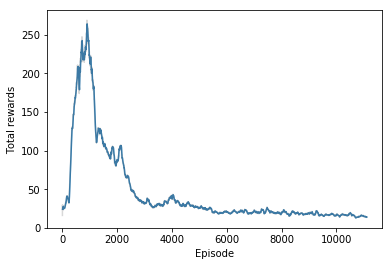

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

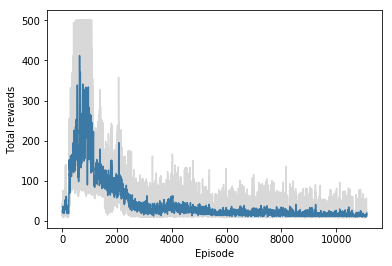

In [17]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

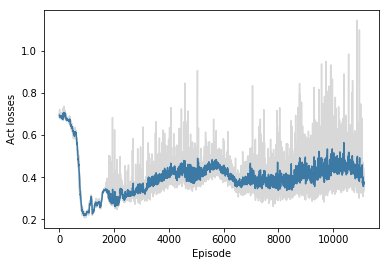

In [18]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

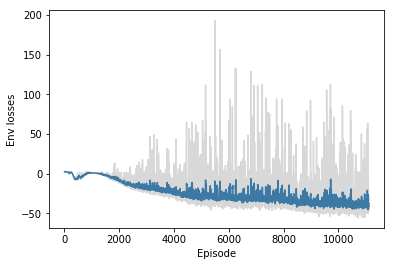

In [19]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Act losses 2')

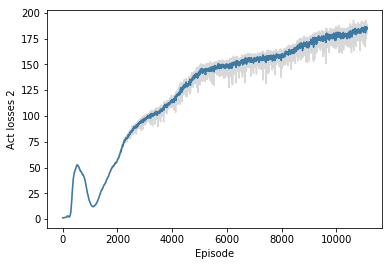

In [20]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

## Testing

Let's checkout how our trained agent plays the game.

In [24]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
